In [1]:
# pip install pgmpy

In [2]:
# pip install pyvis

In [3]:
# === Import Preamble ===
import os
import math
import random
import copy
import colorsys
import itertools
from itertools import combinations
from math import log2
from contextlib import contextmanager
from collections import defaultdict, deque

import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from pyvis.network import Network
from graphviz import Digraph

from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.factors.discrete import TabularCPD, DiscreteFactor
from pgmpy.inference import VariableElimination

# ============================================================================
# Print Index (locations where prints occur)
# ----------------------------------------------------------------------------
# - Table 3 / Decision & Information (evidence: Blood=Yes)
# - Next best test by EVSI
# - Table 4 / EU across evidence subsets (top 10)
# - Consistency checks (sinks Hypothesis vs Chrono)
# - Appendix C: LRs (AS | Blood=Yes)
# - Sensitivity: EIG(DNA;H | Blood=Yes)
# - Appendix A: Bias scenarios (evidence Blood=Yes)
# - Conditional sink masses
# - Invariance and other sanity checks
# - Summary and headline posteriors
# These remain at their original positions to avoid any execution-order change.
# ============================================================================

# (Original cell) Quick Graphviz smoke test preserved
g = Digraph(format="pdf", graph_attr={"rankdir":"LR", "size":"11.69,8.27!"})
g.edge("root","child", label="AS: Splatter→Pass\n0.40")
g.render("tiny_test", cleanup=True)  # writes tiny_test.pdf

# Optional: Graphviz layout availability flag
try:
    from networkx.drawing.nx_pydot import graphviz_layout as gv_layout
    _HAS_GV = True
except Exception:
    _HAS_GV = False


/usr/local/python/3.12.1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# --- 0) Constants & Helpers --------------------------------------------------
random.seed(0)

HW_MIN, HW_MAX = 0.60, 0.95    # caps for handwriting reliability
EPS            = 1e-6          # small mass to avoid zeros

H_STATES = ["h1","h2","h3","h4","h5"]
AUTHOR_CODES = ["a1","a2","a3","a4"]

def normalize(dist, eps=EPS):
    """Replace zeros with eps, then renormalize to sum=1."""
    r = [x if x > 0 else eps for x in dist]
    S = sum(r)
    return [x / S for x in r]

def make_prior_dict(keys, values):
    """Build a prior dict and assert it sums to 1."""
    d = dict(zip(keys, values))
    assert abs(sum(d.values()) - 1.0) < 1e-8, "Priors must sum to 1"
    return d

def override_mode_timing(h_list, tup):
    """Bulk override mode_timing_pr for all modes in h_list with tuple tup."""
    for h in h_list:
        mode_timing_pr[h] = tup

def override_timing_author(h_list, t, tup):
    """Bulk override timing_author_pr[(h,t)] for h in h_list with tuple tup."""
    for h in h_list:
        timing_author_pr[(h, t)] = tup


In [5]:
# --- 1) Mode-of-death priors (scenarios) ------------------------------------
mode_keys           = [f"h{i}" for i in range(1, 6)]
mode_pr_values      = [0.10, 0.08, 0.06, 0.46, 0.30]
mode_pr_biased_vals = [0.25, 0.04, 0.04, 0.52, 0.15]
mode_pr_fair_vals   = [0.10, 0.10, 0.10, 0.60, 0.10]
mode_pr_extreme_vals= [0.40, 0.05, 0.05, 0.40, 0.10]

mode_pr        = make_prior_dict(mode_keys, mode_pr_values)
mode_pr_biased = make_prior_dict(mode_keys, mode_pr_biased_vals)
mode_pr_fair   = make_prior_dict(mode_keys, mode_pr_fair_vals)
mode_pr_extreme= make_prior_dict(mode_keys, mode_pr_extreme_vals)

prs = {
    'True-world':        mode_pr,
    'Investigator-bias': mode_pr_biased,
    'Fair-reweighted':   mode_pr_fair,
    'Extreme-bias':      mode_pr_extreme,
}
bias_scenarios = list(prs.items())

# --- 1) PARAMETER DEFINITIONS ------------------------------------------------

# 1a) Mode-of-death priors (duplicate kept; original order preserved)
mode_pr = {
    "h1": 0.10,
    "h2": 0.08,
    "h3": 0.06,
    "h4": 0.46,
    "h5": 0.30,
}

# 1b) Letter timing CPTs: (P(before), P(after))
mode_timing_pr = {
    "h1": (0.90, 0.10),
    "h2": (0.30, 0.70),
    "h3": (0.30, 0.70),  # identical to h2
    "h4": (0.80, 0.20),
    "h5": (0.80, 0.20),
}

# 1c) Author CPTs given (mode, timing): (P(victim), P(offender))
timing_author_pr = {
    # h1
    ("h1","t1"): (0.98, 0.02),
    ("h1","t2"): (0.10, 0.90),
    # h2
    ("h2","t1"): (0.98, 0.02),
    ("h2","t2"): (0.10, 0.90),
    # h3 (copy of h2)
    ("h3","t1"): (0.98, 0.02),
    ("h3","t2"): (0.10, 0.90),
    # h4
    ("h4","t1"): (0.90, 0.10),
    ("h4","t2"): (0.05, 0.95),
    # h5
    ("h5","t1"): (0.98, 0.02),
    ("h5","t2"): (0.02, 0.98),
}

# 1d) Raw 10-bin blood patterns | (h,t,a)
blood_pr_raw = {
    # h1
    ("h1","t1","a1"): [0.04,0.01,0.035,0.015,0.045,0.005,0.095,0.005,0.075,0.675],
    ("h1","t1","a2"): [0.40,0.05,0.20, 0.10, 0.10, 0.05, 0.05, 0.03, 0.02, 0.00],
    ("h1","t2","a3"): [0.30,0.10,0.20, 0.05, 0.15, 0.05, 0.10, 0.03, 0.02, 0.00],
    ("h1","t2","a4"): [0.20,0.15,0.15, 0.10, 0.10, 0.10, 0.10, 0.05, 0.05, 0.00],

    # h2
    ("h2","t1","a1"): [0.05,0.03,0.04,0.02,0.06,0.02,0.08,0.01,0.05,0.64],
    ("h2","t1","a2"): [0.35,0.05,0.25,0.10,0.10,0.05,0.05,0.02,0.03,0.00],
    ("h2","t2","a3"): [0.25,0.10,0.15,0.10,0.15,0.05,0.10,0.05,0.05,0.00],
    ("h2","t2","a4"): [0.15,0.15,0.10,0.10,0.10,0.10,0.15,0.10,0.05,0.00],

    # h3 (copy of h2)
    ("h3","t1","a1"): [0.05,0.03,0.04,0.02,0.06,0.02,0.08,0.01,0.05,0.64],
    ("h3","t1","a2"): [0.35,0.05,0.25,0.10,0.10,0.05,0.05,0.02,0.03,0.00],
    ("h3","t2","a3"): [0.25,0.10,0.15,0.10,0.15,0.05,0.10,0.05,0.05,0.00],
    ("h3","t2","a4"): [0.15,0.15,0.10,0.10,0.10,0.10,0.15,0.10,0.05,0.00],

    # h4
    ("h4","t1","a1"): [0.03,0.01,0.02,0.01,0.04,0.01,0.04,0.01,0.03,0.80],
    ("h4","t1","a2"): [0.25,0.05,0.20,0.10,0.10,0.05,0.05,0.02,0.03,0.15],
    ("h4","t2","a3"): [0.10,0.10,0.10,0.10,0.10,0.10,0.10,0.10,0.10,0.10],
    ("h4","t2","a4"): [0.10,0.15,0.10,0.10,0.10,0.10,0.10,0.10,0.05,0.10],

    # h5
    ("h5","t1","a1"): [0.02,0.005,0.015,0.005,0.03,0.005,0.08,0.001,0.04,0.799],
    ("h5","t1","a2"): [0.20,0.05,0.15,0.10,0.10,0.05,0.05,0.03,0.02,0.25],
    ("h5","t2","a3"): [0.25,0.10,0.20,0.10,0.15,0.05,0.10,0.02,0.03,0.00],
    ("h5","t2","a4"): [0.15,0.15,0.10,0.10,0.10,0.10,0.15,0.10,0.05,0.00],
}

# 1e) Handwriting reliability offsets
base_hw = 0.90
mode_offset   = {"h1":+0.02,"h2":+0.01,"h3":+0.01,"h4":-0.02,"h5":-0.03}
author_offset = {"a1":+0.01,"a2":-0.01,"a3":+0.01,"a4":-0.01}

# 1f) Raw DNA accuracies | (h,t,a,e)
dna_pr_raw = {
    # h1
    ("h1","t1","a1","e1"): (0.995,0.005), ("h1","t1","a1","e3"): (0.990,0.010),
    ("h1","t1","a1","e5"): (0.993,0.007), ("h1","t1","a1","e7"): (0.992,0.008),
    ("h1","t1","a1","e9"): (0.994,0.006),
    ("h1","t1","a2","e11"): (0.980,0.020), ("h1","t1","a2","e13"): (0.985,0.015),
    ("h1","t1","a2","e15"): (0.975,0.025), ("h1","t1","a2","e17"): (0.982,0.018),
    ("h1","t1","a2","e19"): (0.988,0.012),
    ("h1","t2","a3","e21"): (0.960,0.040), ("h1","t2","a3","e23"): (0.965,0.035),
    ("h1","t2","a3","e25"): (0.958,0.042), ("h1","t2","a3","e27"): (0.962,0.038),
    ("h1","t2","a3","e29"): (0.967,0.033),
    ("h1","t2","a4","e31"): (0.940,0.060), ("h1","t2","a4","e33"): (0.948,0.052),
    ("h1","t2","a4","e35"): (0.943,0.057), ("h1","t2","a4","e37"): (0.950,0.050),
    ("h1","t2","a4","e39"): (0.945,0.055),

    # h2
    ("h2","t1","a1","e1"): (0.990,0.010), ("h2","t1","a1","e3"): (0.992,0.008),
    ("h2","t1","a1","e5"): (0.988,0.012), ("h2","t1","a1","e7"): (0.991,0.009),
    ("h2","t1","a1","e9"): (0.989,0.011),
    ("h2","t1","a2","e11"): (0.970,0.030), ("h2","t1","a2","e13"): (0.975,0.025),
    ("h2","t1","a2","e15"): (0.965,0.035), ("h2","t1","a2","e17"): (0.972,0.028),
    ("h2","t1","a2","e19"): (0.968,0.032),
    ("h2","t2","a3","e21"): (0.950,0.050), ("h2","t2","a3","e23"): (0.955,0.045),
    ("h2","t2","a3","e25"): (0.948,0.052), ("h2","t2","a3","e27"): (0.952,0.048),
    ("h2","t2","a3","e29"): (0.957,0.043),
    ("h2","t2","a4","e31"): (0.930,0.070), ("h2","t2","a4","e33"): (0.938,0.062),
    ("h2","t2","a4","e35"): (0.933,0.067), ("h2","t2","a4","e37"): (0.940,0.060),
    ("h2","t2","a4","e39"): (0.935,0.065),

    # h3 (copy of h2)
    ("h3","t1","a1","e1"): (0.990,0.010), ("h3","t1","a1","e3"): (0.992,0.008),
    ("h3","t1","a1","e5"): (0.988,0.012), ("h3","t1","a1","e7"): (0.991,0.009),
    ("h3","t1","a1","e9"): (0.989,0.011),
    ("h3","t1","a2","e11"): (0.970,0.030), ("h3","t1","a2","e13"): (0.975,0.025),
    ("h3","t1","a2","e15"): (0.965,0.035), ("h3","t1","a2","e17"): (0.972,0.028),
    ("h3","t1","a2","e19"): (0.968,0.032),
    ("h3","t2","a3","e21"): (0.950,0.050), ("h3","t2","a3","e23"): (0.955,0.045),
    ("h3","t2","a3","e25"): (0.948,0.052), ("h3","t2","a3","e27"): (0.952,0.048),
    ("h3","t2","a3","e29"): (0.957,0.043),
    ("h3","t2","a4","e31"): (0.930,0.070), ("h3","t2","a4","e33"): (0.938,0.072),
    ("h3","t2","a4","e35"): (0.923,0.077), ("h3","t2","a4","e37"): (0.930,0.070),
    ("h3","t2","a4","e39"): (0.925,0.075),

    # h4
    ("h4","t1","a1","e1") : (0.980, 0.020),
    ("h4","t1","a1","e3") : (0.982, 0.018),
    ("h4","t1","a1","e5") : (0.978, 0.022),
    ("h4","t1","a1","e7") : (0.981, 0.019),
    ("h4","t1","a1","e9") : (0.979, 0.021),
    ("h4","t1","a2","e11"): (0.950, 0.050),
    ("h4","t1","a2","e13"): (0.955, 0.045),
    ("h4","t1","a2","e15"): (0.945, 0.055),
    ("h4","t1","a2","e17"): (0.952, 0.048),
    ("h4","t1","a2","e19"): (0.948, 0.052),
    ("h4","t2","a3","e21"): (0.940, 0.060),
    ("h4","t2","a3","e23"): (0.945, 0.055),
    ("h4","t2","a3","e25"): (0.938, 0.062),
    ("h4","t2","a3","e27"): (0.942, 0.058),
    ("h4","t2","a3","e29"): (0.947, 0.053),
    ("h4","t2","a4","e31"): (0.920, 0.080),
    ("h4","t2","a4","e33"): (0.928, 0.072),
    ("h4","t2","a4","e35"): (0.923, 0.077),
    ("h4","t2","a4","e37"): (0.930, 0.070),
    ("h4","t2","a4","e39"): (0.925, 0.075),

    # h5
    ("h5","t1","a1","e1") : (0.975, 0.025),
    ("h5","t1","a1","e3") : (0.978, 0.022),
    ("h5","t1","a1","e5") : (0.973, 0.027),
    ("h5","t1","a1","e7") : (0.976, 0.024),
    ("h5","t1","a1","e9") : (0.974, 0.026),
    ("h5","t1","a2","e11"): (0.950, 0.050),
    ("h5","t1","a2","e13"): (0.955, 0.045),
    ("h5","t1","a2","e15"): (0.945, 0.055),
    ("h5","t1","a2","e17"): (0.952, 0.048),
    ("h5","t1","a2","e19"): (0.948, 0.052),
    ("h5","t2","a3","e21"): (0.940, 0.060),
    ("h5","t2","a3","e23"): (0.945, 0.055),
    ("h5","t2","a3","e25"): (0.938, 0.062),
    ("h5","t2","a3","e27"): (0.942, 0.058),
    ("h5","t2","a3","e29"): (0.947, 0.053),
    ("h5","t2","a4","e31"): (0.920, 0.080),
    ("h5","t2","a4","e33"): (0.928, 0.072),
    ("h5","t2","a4","e35"): (0.923, 0.077),
    ("h5","t2","a4","e37"): (0.930, 0.070),
    ("h5","t2","a4","e39"): (0.925, 0.075),
}

# After dna_pr_raw is constructed, swap for offender-authored a2/a4
for (h, t, a, e), (pV, pO) in list(dna_pr_raw.items()):
    if a in ('a2', 'a4'):     # offender wrote
        dna_pr_raw[(h, t, a, e)] = (pO, pV)   # make DNA=O large when offender wrote

# Timing splits when a letter is NOT found (L='no')
mode_timing_pr_Lno = {
    "h1": (0.85, 0.15),
    "h2": (0.55, 0.45),
    "h3": (0.55, 0.45),
    "h4": (0.65, 0.35),
    "h5": (0.80, 0.20),
}
# Timing splits when a letter IS found (L='yes')
mode_timing_pr_Lyes = mode_timing_pr

AUTHORS_BY_T = {'t1': ['a1','a2'], 't2': ['a3','a4']}


In [6]:
# --- 4b) Normalize & build binary blood_yes_no_pr ----------------------------
blood_pr = { key: normalize(raw) for key, raw in blood_pr_raw.items() }
for dist10 in blood_pr.values():
    assert abs(sum(dist10) - 1.0) < 1e-8

blood_yes_no_pr = {}
for (h, t, a), dist10 in blood_pr.items():
    p_yes = sum(dist10[i] for i in range(0, 10, 2))
    blood_yes_no_pr[(h, t, a)] = (p_yes, 1.0 - p_yes)

# (g) Audit-node CPTs (keep AL simple; make AS depend on BP)
alpha_S, beta_S = 0.80, 0.90
alpha_F, beta_F = 0.85, 0.95
alpha_E, beta_E = 0.90, 0.98

mode_offset["h3"] = mode_offset["h2"]

# Build handwriting_pr
handwriting_pr = {}
for (h, t, a) in blood_pr_raw:
    p = base_hw + mode_offset[h] + author_offset[a]
    p = min(max(p, HW_MIN), HW_MAX)
    handwriting_pr[(h, t, a)] = (p, 1.0 - p)

# Normalized DNA
dna_pr = {}
for key, (p0, p1) in dna_pr_raw.items():
    S = p0 + p1
    dna_pr[key] = (p0 / S, p1 / S)


In [7]:
# --- 7) Group-wise overrides -------------------------------------------------
override_mode_timing(["h4","h5"], (0.80, 0.20))
override_timing_author(["h4","h5"], "t1", (0.90, 0.10))
override_timing_author(["h4","h5"], "t2", (0.05, 0.95))

# Ensure h3 shares h2 CPTs (run once here)
mode_timing_pr["h3"] = mode_timing_pr["h2"]
for t in ("t1","t2"):
    timing_author_pr[("h3", t)] = timing_author_pr[("h2", t)]

# Copy raw tables h2 -> h3 (if not already)
for (h, t, a), raw in list(blood_pr_raw.items()):
    if h == "h2":
        blood_pr_raw[("h3", t, a)] = raw.copy()

for (h, t, a, e), pair in list(dna_pr_raw.items()):
    if h == "h2":
        dna_pr_raw[("h3", t, a, e)] = pair

# Rebuild blood_yes_no_pr after copies
blood_pr = {k: normalize(v) for k, v in blood_pr_raw.items()}  # each sums to 1
blood_yes_no_pr = {}
for (h, t, a), dist10 in blood_pr.items():
    p_yes = sum(dist10[i] for i in range(0, 10, 2))   # even bins = "blood yes"
    blood_yes_no_pr[(h, t, a)] = (p_yes, 1.0 - p_yes)

# 3) Handwriting per (h,t,a)
HW_MIN, HW_MAX = 0.60, 0.95
base_hw = 0.90
mode_offset["h3"] = mode_offset["h2"]  # ensure same offset as h2

handwriting_pr = {}
for (h, t, a) in blood_pr_raw:
    p = base_hw + mode_offset[h] + author_offset[a]
    p = min(max(p, HW_MIN), HW_MAX)
    handwriting_pr[(h, t, a)] = (p, 1.0 - p)

# 4) Timing splits conditioned on L
mode_timing_pr_Lyes = mode_timing_pr  # alias to be explicit

# 5) Completeness checks
missing_author = [(h, t) for h in H_STATES for t in ['t1','t2']
                  if (h, t) not in timing_author_pr]
assert not missing_author, f"timing_author_pr missing: {missing_author}"

missing_blood = [
    (h, t, a)
    for h in H_STATES
    for t in ['t1','t2']
    for a in AUTHORS_BY_T[t]
    if (h, t, a) not in blood_yes_no_pr
]
assert not missing_blood, f"blood_yes_no_pr missing: {missing_blood}"

missing_hw = [
    (h, t, a)
    for h in H_STATES
    for t in ['t1','t2']
    for a in AUTHORS_BY_T[t]
    if (h, t, a) not in handwriting_pr
]
assert not missing_hw, f"handwriting_pr missing: {missing_hw}"

missing_Lsplits = [h for h in H_STATES
                   if (h not in mode_timing_pr_Lyes) or (h not in mode_timing_pr_Lno)]
assert not missing_Lsplits, f"Timing splits missing for some h in Lyes/Lno: {missing_Lsplits}"


In [8]:
# 2.1 Mappings between codes and BN variables/states
H_MAP = {  # h-codes -> H states used in the notebook
    "h1":"O_delib", "h2":"O_self", "h3":"O_acc", "h4":"V_acc", "h5":"Suicide"
}
T_MAP = {"t1":"Before", "t2":"After"}        # timing
W_STATES = ["Victim","Offender"]

def a_code_for(W, t):
    """Map (writer, timing) -> 'a' code used in blood/DNA tables."""
    return {"Victim":{"t1":"a1","t2":"a3"},
            "Offender":{"t1":"a2","t2":"a4"}}[W][t]

# 2.2 Provide P(Lfound|H)
LFOUND_YES = {
    "h1":0.70, "h2":0.50, "h3":0.50, "h4":0.90, "h5":0.95
}

# 2.3 Helper to normalise a vector without epsilon smoothing
def nz_normalize(v):
    """Normalize a vector to sum to one; requires strictly positive sum."""
    s = sum(v)
    assert s > 0, "Zero-sum vector"
    return [x/s for x in v]


In [9]:
# --- Build CPDs from edge tables (path-aware) --------------------------------

def build_cpds_from_edge_tables_v2():
    """
    Build path-aware CPDs that match a probability-tree/CEG view.
    Returns dict of BN loader keys.
    """
    H_ord = ["h1","h2","h3","h4","h5"]
    T_ord = ["t1","t2"]  # t1=Before, t2=After
    W_ord = ["Victim","Offender"]
    Lf_ord = ["No","Yes"]
    Blood_states = ["No","Yes"]
    BP_states = ["Fingerprint-like","Spatter"]
    DNA_states = ["V","O"]

    # 0) Prior on H
    prior_H = [mode_pr[h] for h in H_ord]

    # 1) P(Lfound | H)
    Lfound_table = [
        [1 - LFOUND_YES[h] for h in H_ord],   # No
        [    LFOUND_YES[h] for h in H_ord],   # Yes
    ]

    # 2) P(Ltime | H, Lfound)
    cols_before, cols_after = [], []
    for h in H_ord:
        for lf in Lf_ord:
            b, a = (mode_timing_pr_Lno[h] if lf == "No" else mode_timing_pr_Lyes[h])
            cols_before.append(b)
            cols_after.append(a)
    Ltime_table = [cols_before, cols_after]  # rows Before, After

    # 3) P(W | H, Ltime)
    WV, WO = [], []
    for h in H_ord:
        for t in T_ord:
            pV, pO = timing_author_pr[(h, t)]
            WV.append(pV); WO.append(pO)
    W_table = [WV, WO]

    # Local helper
    def a_code_for(W, t):
        return {"Victim":{"t1":"a1","t2":"a3"},
                "Offender":{"t1":"a2","t2":"a4"}}[W][t]

    # 4) P(Blood | H, Ltime, W)
    blood_rows_no, blood_rows_yes = [], []
    for h in H_ord:
        for t in T_ord:
            for W in W_ord:
                a = a_code_for(W, t)
                p_yes, p_no = blood_yes_no_pr[(h, t, a)]
                blood_rows_no.append(p_no)
                blood_rows_yes.append(p_yes)
    Blood_table = [blood_rows_no, blood_rows_yes]

    # 5) P(BP | Blood)
    PHI_BP = 0.60
    BP_table = [
        [1.0,        PHI_BP],      # Fingerprint-like
        [0.0, 1.0 - PHI_BP],       # Spatter
    ]

    # 6) P(DNA | H, Ltime, W) by averaging across e
    DNA_V, DNA_O = [], []
    e_groups = {}
    for (h, t, a, e), (p0, p1) in dna_pr_raw.items():
        e_groups.setdefault((h, t, a), []).append((p0, p1))
    for h in H_ord:
        for t in T_ord:
            for W in W_ord:
                a = a_code_for(W, t)
                pairs = e_groups.get((h, t, a), [])
                if not pairs:
                    pO = 0.5
                else:
                    pO = float(np.mean([p1/(p0+p1) for (p0, p1) in pairs]))
                pV = 1.0 - pO
                DNA_V.append(pV); DNA_O.append(pO)
    DNA_table = [DNA_V, DNA_O]

    # 7) P(AL | DNA)
    AL_PASS = 0.90
    AL_table = [
        [1 - AL_PASS, 1 - AL_PASS],  # Fail
        [    AL_PASS,     AL_PASS],  # Pass
    ]

    # 8) P(AS | BP)
    AS_PASS = 0.90
    AS_table = [
        [1 - AS_PASS, 1 - AS_PASS],  # Fail
        [    AS_PASS,     AS_PASS],  # Pass
    ]

    # 9) P(Hand | W) (marginalised reliability)
    def p_hand_V_given_W(W):
        num = den = 0.0
        for h in H_ord:
            pH = mode_pr[h]
            for lf in Lf_ord:
                pLf = (1 - LFOUND_YES[h]) if lf == "No" else LFOUND_YES[h]
                b, a = (mode_timing_pr_Lno[h] if lf == "No" else mode_timing_pr_Lyes[h])
                for t, pT in zip(T_ord, [b, a]):
                    pV, pO = timing_author_pr[(h, t)]
                    w_W = pV if W == "Victim" else pO
                    wgt = pH * pLf * pT * w_W
                    if wgt == 0.0:
                        continue
                    a_code = a_code_for(W, t)
                    pV0, pO0 = handwriting_pr[(h, t, a_code)]
                    num += wgt * pV0
                    den += wgt
        return num / den if den > 0 else 0.5

    Hand_V, Hand_O = [], []
    for W in W_ord:
        pV = p_hand_V_given_W(W)
        Hand_V.append(pV); Hand_O.append(1.0 - pV)
    Hand_table = [Hand_V, Hand_O]

    return {
        'H_prior'       : prior_H,
        'Lfound|H'      : Lfound_table,
        'Ltime|H,Lfound': Ltime_table,
        'W|H,Ltime'     : W_table,
        'Blood|H,Ltime,W': Blood_table,
        'BP|Blood'      : BP_table,
        'DNA|H,Ltime,W' : DNA_table,
        'AL|DNA'        : AL_table,
        'AS|BP'         : AS_table,
        'Hand|W'        : Hand_table,
    }

# Build once
EDGE_CPDS = build_cpds_from_edge_tables_v2()


In [10]:
# For consistent results
random.seed(7)
np.random.seed(7)

# ============================================================================
# 0) Variables, states, display names, orders
# ============================================================================

VAR_STATES = {
    'H'     : ['O_delib','O_self','O_acc','V_acc','Suicide'],
    'Lfound': ['No','Yes'],
    'Ltime' : ['Before','After'],
    'O'     : ['Absent','Present'],
    'W'     : ['Victim','Offender'],
    'Blood' : ['No','Yes'],
    'BP'    : ['Fingerprint-like','Spatter'],
    'DNA'   : ['V','O'],
    'AL'    : ['Fail','Pass'],
    'AS'    : ['Fail','Pass'],
    'Hand'  : ['Victim','Offender'],
}

STATE_LABEL = {
    'H': {'O_delib':'Offender deliberate','O_self':'Offender self-defense',
          'O_acc':'Offender accidental','V_acc':'Victim accidental','Suicide':'Suicide'},
    'Lfound': {'No':'Letter not found','Yes':'Letter found'},
    'Ltime': {'Before':'Letter before death','After':'Letter after death'},
    'O': {'Absent':'Offender absent','Present':'Offender present'},
    'W': {'Victim':'Victim wrote','Offender':'Offender wrote'},
    'Blood': {'No':'NBlood','Yes':'Blood'},
    'BP': {'Fingerprint-like':'Blood pattern: Fingerprint-like','Spatter':'Blood pattern: Spatter'},
    'DNA': {'V':'DNA: Victim','O':'DNA: Offender'},
    'AL': {'Fail':'Audit lab: Fail','Pass':'Audit lab: Pass'},
    'AS': {'Fail':'Audit scene: Fail','Pass':'Audit scene: Pass'},
    'Hand': {'Victim':'Handwriting: Victim','Offender':'Handwriting: Offender'},
}

SHORT_LABEL = {
  'H': {
    'O_delib':'O delib','O_self':'O self-def','O accident':'O accident',
    'V_acc':'V accident','Suicide':'Suicide'
  },
  'Lfound': {'No':'L? No','Yes':'L? Yes'},
  'Ltime': {'Before':'t: Before','After':'t: After'},
  'O': {'Absent':'O: Absent','Present':'O: Present'},
  'W': {'Victim':'W: Victim','Offender':'W: Offender'},
  'Blood': {'No':'Blood: No','Yes':'Blood: Yes'},
  'BP': {'Fingerprint-like':'BP: Fingerprint','Spatter':'BP: Spat'},
  'DNA': {'V':'DNA: V','O':'DNA: O'},
  'AL': {'Fail':'AL: Fail','Pass':'AL: Pass'},
  'AS': {'Fail':'AS: Fail','Pass':'AS: Pass'},
  'Hand': {'Victim':'Hand: V','Offender':'Hand: O'},
}

# Event-tree orders (display only)
ORDER_HYPOTHESIS = ('H','Lfound','Ltime','O','W','Blood','BP','AS','DNA','AL','Hand')
ORDER_CHRONO  = ('Lfound','Ltime','O','W','H','Blood','BP','AS','DNA','AL','Hand')

AUDIT_VARS = {'AL','AS'}
SINK_VAR   = 'Hand'


In [11]:
# --- Build BN model (path-aware CPDs) ---------------------------------------

def make_model_once(edge_cpds=EDGE_CPDS):
    """Build a BN that reflects the path-aware CPDs. Used for VE queries."""
    model = DiscreteBayesianNetwork([
        # letter + timing
        ('H','Lfound'),
        ('H','Ltime'), ('Lfound','Ltime'),

        # presence and authorship
        ('H','O'), ('Ltime','O'),
        ('O','W'), ('H','W'), ('Ltime','W'),

        # scene + lab
        ('H','Blood'), ('Ltime','Blood'), ('W','Blood'),
        ('Blood','BP'),
        ('BP','AS'),
        ('O','DNA'), ('W','DNA'),
        ('DNA','AL'),
        ('W','Hand'),
    ])

    def _to_table(var, table, evidence):
        vcard = len(VAR_STATES[var])
        ecards = [len(VAR_STATES[e]) for e in (evidence or [])]
        prod_e = int(np.prod(ecards)) if ecards else 1
        arr = np.asarray(table, dtype=float)
        if arr.ndim == 1:
            arr = arr.reshape((vcard, 1))
        else:
            if arr.shape == (1, vcard):
                arr = arr.T
            if arr.size == vcard * prod_e and arr.shape != (vcard, prod_e):
                arr = arr.reshape((vcard, prod_e), order='C')
        assert arr.shape == (vcard, prod_e), f"{var} has shape {arr.shape}, expected {(vcard, prod_e)}"
        return arr.tolist(), ecards

    def CPD(var, key, evidence=None):
        evidence = evidence or []
        table, ecards = _to_table(var, edge_cpds[key], evidence)
        return TabularCPD(
            variable=var,
            variable_card=len(VAR_STATES[var]),
            values=table,
            evidence=evidence,
            evidence_card=ecards,
            state_names={var: VAR_STATES[var], **{e: VAR_STATES[e] for e in evidence}},
        )

    # Pull original per-(H,Ltime) P(W=Offender) and calibrate O, W
    inv_H = {v: k for k, v in H_MAP.items()}
    inv_T = {'Before': 't1', 'After': 't2'}

    p_old_off_cols = [
        timing_author_pr[(inv_H[h_lab], inv_T[t_lab])][1]
        for h_lab in VAR_STATES['H']
        for t_lab in VAR_STATES['Ltime']
    ]

    eps_w = 1e-6
    theta = min(1-1e-6, max(p_old_off_cols))

    def clip(x, lo=1e-6, hi=1-1e-6):
        return max(lo, min(hi, x))

    omega_cols = [clip(p_off / theta) for p_off in p_old_off_cols]

    O_table = [
        [1.0 - om for om in omega_cols],
        [      om for om in omega_cols],
    ]

    # Build W table interleaving O=Absent, O=Present per (H,Ltime)
    W_cols_V_abs, W_cols_O_abs, W_cols_V_pre, W_cols_O_pre = [], [], [], []
    for _ in omega_cols:
        W_cols_V_abs.append(1.0 - eps_w); W_cols_O_abs.append(eps_w)
        W_cols_V_pre.append(1.0 - theta); W_cols_O_pre.append(theta)

    W_table = [
        [v for i in range(len(omega_cols)) for v in (W_cols_V_abs[i], W_cols_V_pre[i])],
        [o for i in range(len(omega_cols)) for o in (W_cols_O_abs[i], W_cols_O_pre[i])],
    ]

    cpd_O = TabularCPD(
        variable='O', variable_card=2, values=O_table,
        evidence=['H','Ltime'], evidence_card=[5,2],
        state_names={'O':VAR_STATES['O'], 'H':VAR_STATES['H'], 'Ltime':VAR_STATES['Ltime']}
    )
    cpd_W = TabularCPD(
        variable='W', variable_card=2, values=W_table,
        evidence=['H','Ltime','O'], evidence_card=[5,2,2],
        state_names={'W':VAR_STATES['W'], 'H':VAR_STATES['H'], 'Ltime':VAR_STATES['Ltime'], 'O':VAR_STATES['O']}
    )

    vals = [
        [0.98, 0.20, 0.85, 0.10],  # P(DNA='V' | O,W)
        [0.02, 0.80, 0.15, 0.90],  # P(DNA='O' | O,W)
    ]
    cpd_DNA = TabularCPD(
        variable='DNA', variable_card=2, values=vals,
        evidence=['O','W'], evidence_card=[2,2],
        state_names={'DNA':VAR_STATES['DNA'], 'O':VAR_STATES['O'], 'W':VAR_STATES['W']}
    )

    cpd_H       = CPD('H',       'H_prior')
    cpd_Lfound  = CPD('Lfound',  'Lfound|H',        evidence=['H'])
    cpd_Ltime   = CPD('Ltime',   'Ltime|H,Lfound',  evidence=['H','Lfound'])
    cpd_Blood   = CPD('Blood',   'Blood|H,Ltime,W', evidence=['H','Ltime','W'])
    cpd_BP      = CPD('BP',      'BP|Blood',        evidence=['Blood'])
    cpd_AL      = CPD('AL',      'AL|DNA',          evidence=['DNA'])
    cpd_AS      = CPD('AS',      'AS|BP',           evidence=['BP'])
    cpd_Hand    = CPD('Hand',    'Hand|W',          evidence=['W'])

    model.add_cpds(cpd_H, cpd_Lfound, cpd_Ltime, cpd_O, cpd_W,
                   cpd_Blood, cpd_BP, cpd_DNA, cpd_AL, cpd_AS, cpd_Hand)
    assert model.check_model()
    return model

# --- Chronology overlays (joint-preserving reparameterisation) ---------------

def _nz_norm(a, axis=-1):
    """Normalize numpy array along axis with safe zero handling."""
    s = a.sum(axis=axis, keepdims=True)
    s[s == 0] = 1.0
    return a / s

def compute_chrono_overlays_from_model(model):
    """Compute P(Lfound), P(Ltime|Lfound), P(O|Ltime,Lfound), P(W|O,Ltime,Lfound),
    and P(H|Lfound,Ltime,O,W) directly from the BN CPDs.
    """
    H = len(VAR_STATES['H'])
    Lf = len(VAR_STATES['Lfound'])
    Lt = len(VAR_STATES['Ltime'])
    O  = len(VAR_STATES['O'])
    W  = len(VAR_STATES['W'])

    P_H = np.array(model.get_cpds('H').get_values(), dtype=float).reshape(H)
    P_Lf_given_H = np.array(model.get_cpds('Lfound').get_values(), dtype=float)
    P_Lt_given_HLf = np.array(model.get_cpds('Ltime').get_values(), dtype=float)
    P_O_given_HLt  = np.array(model.get_cpds('O').get_values(), dtype=float)
    P_W_given_HLtO = np.array(model.get_cpds('W').get_values(), dtype=float)

    P_Lf_given_H = P_Lf_given_H.reshape(Lf, H)
    P_Lt_given_HLf = P_Lt_given_HLf.reshape(Lt, H, Lf)
    P_O_given_HLt  = P_O_given_HLt.reshape(O,  H, Lt)
    P_W_given_HLtO = P_W_given_HLtO.reshape(W,  H, Lt, O)

    P_Lf = (P_Lf_given_H * P_H[None, :]).sum(axis=1)

    num_H_given_Lf = P_Lf_given_H * P_H[None, :]
    P_H_given_Lf   = _nz_norm(num_H_given_Lf, axis=1)

    P_Lt_given_Lf = np.einsum('lh, thl -> lt', P_H_given_Lf, P_Lt_given_HLf)

    num_H_given_LfLt = np.einsum('h, lh, thl -> lth', P_H, P_Lf_given_H, P_Lt_given_HLf)
    P_H_given_LfLt   = _nz_norm(num_H_given_LfLt, axis=2)

    P_O_given_LtLf = np.einsum('oht, lth -> lto', P_O_given_HLt, P_H_given_LfLt)
    P_O_given_LtLf = _nz_norm(P_O_given_LtLf, axis=2)

    num_H_given_LfLtO = np.einsum('lth,oht->ltoh', P_H_given_LfLt, P_O_given_HLt)
    P_H_given_LfLtO   = _nz_norm(num_H_given_LfLtO, axis=3)

    P_W_given_OLtLf = np.einsum('whlo,ltoh->ltow', P_W_given_HLtO, P_H_given_LfLtO)
    P_W_given_OLtLf = _nz_norm(P_W_given_OLtLf, axis=3)

    num_H_given_LfLtOW = np.einsum('ltoh,whlo->ltowh', P_H_given_LfLtO, P_W_given_HLtO)
    P_H_given_LfLtOW   = _nz_norm(num_H_given_LfLtOW, axis=4)

    return dict(
        P_Lfound                 = P_Lf,
        P_Ltime_given_Lfound     = P_Lt_given_Lf,
        P_O_given_Ltime_Lfound   = P_O_given_LtLf,
        P_W_given_O_Ltime_Lfound = P_W_given_OLtLf,
        P_H_given_LfLtOW         = P_H_given_LfLtOW,
    )

def make_chrono_overrides(overlays):
    """Build callables that return probability vectors for overrides."""
    def _Lfound_vec(hist):
        return overlays['P_Lfound']
    def _Ltime_vec(hist):
        lf = _hist_get_state(hist, 'Lfound'); i = _idx('Lfound', lf)
        return overlays['P_Ltime_given_Lfound'][i, :]
    def _O_vec(hist):
        lf = _hist_get_state(hist, 'Lfound'); lt = _hist_get_state(hist, 'Ltime')
        i = _idx('Lfound', lf); j = _idx('Ltime', lt)
        return overlays['P_O_given_Ltime_Lfound'][i, j, :]
    def _W_vec(hist):
        lf = _hist_get_state(hist, 'Lfound'); lt = _hist_get_state(hist, 'Ltime'); o = _hist_get_state(hist, 'O')
        i = _idx('Lfound', lf); j = _idx('Ltime', lt); k = _idx('O', o)
        return overlays['P_W_given_O_Ltime_Lfound'][i, j, k, :]
    def _H_vec(hist):
        lf = _hist_get_state(hist, 'Lfound'); lt = _hist_get_state(hist, 'Ltime')
        o  = _hist_get_state(hist, 'O');      w  = _hist_get_state(hist, 'W')
        i = _idx('Lfound', lf); j = _idx('Ltime', lt); k = _idx('O', o); m = _idx('W', w)
        return overlays['P_H_given_LfLtOW'][i, j, k, m, :]

    return {'Lfound': _Lfound_vec, 'Ltime': _Ltime_vec, 'O': _O_vec, 'W': _W_vec, 'H': _H_vec}

# Build model, VE, and overlays
MODEL = make_model_once()
VE    = VariableElimination(MODEL)

_CHRONO_OVERLAYS = compute_chrono_overlays_from_model(MODEL)
CHRONO_OVERRIDES = make_chrono_overrides(_CHRONO_OVERLAYS)


In [12]:
# ============================================================================
# 2) Canonical labels & BN query (single source of truth)
# ============================================================================

def canonical_label(var, state):
    """Format Var:State labels used on edges and histories."""
    return f"{var}:{state}"

def parse_label(label):
    """Split a canonical label into (var, state)."""
    var, state = label.split(':', 1)
    return var, state

def history_to_evidence(history):
    """Convert a tuple/list of 'Var:State' labels to a pgmpy evidence dict."""
    hyp = {}
    for lab in history:
        v, s = parse_label(lab)
        hyp[v] = s
    return hyp

def get_prob_bn(model, history, query_var, query_state):
    """P(query_var=query_state | history) via VE. If already fixed, return 0/1."""
    evidence = history_to_evidence(history)
    if query_var in evidence:
        return 1.0 if evidence[query_var] == query_state else 0.0
    q = VE.query([query_var], evidence=evidence, show_progress=False)
    states = model.get_cpds(query_var).state_names[query_var]
    idx = states.index(query_state)
    return float(q.values[idx])

def get_prob_mixed(model, history, query_var, query_state, overrides=None):
    """Use overlay vector for query_var when provided, otherwise fall back to BN."""
    if overrides and query_var in overrides:
        vec = np.asarray(overrides[query_var](history), dtype=float)
        s = float(vec.sum())
        if s <= 0:
            return get_prob_bn(model, history, query_var, query_state)
        vec = vec / s
        idx = VAR_STATES[query_var].index(query_state)
        return float(vec[idx])
    return get_prob_bn(model, history, query_var, query_state)

# Helpers for overrides
def _hist_get_state(history, var):
    for lab in history:
        v, st = parse_label(lab)
        if v == var:
            return st
    return None

def _idx(var, st):
    return VAR_STATES[var].index(st)


In [13]:
# ============================================================================
# 3) Event-tree builder + deterministic contraction
# ============================================================================

def build_event_tree(model, order, var_states, root_history=(), overrides=None):
    """Construct the event tree following a variable order, optionally using overlays."""
    G = nx.DiGraph()
    root = root_history
    G.add_node(root, history=root)
    frontier = [root]

    for var in order:
        new_frontier = []
        for u in frontier:
            hist = list(G.nodes[u]['history'])
            hist_vars = {parse_label(l)[0] for l in hist if ':' in l}
            if var in hist_vars:
                new_frontier.append(u)
                continue
            states = var_states[var]
            probs  = [get_prob_mixed(model, hist, var, s, overrides=overrides) for s in states]
            s = sum(probs); assert s > 0
            probs = [p/s for p in probs]
            labels = [canonical_label(var, s) for s in states]
            assert len(labels) == len(set(labels))
            for state, p, lab in zip(states, probs, labels):
                if p <= 0.0:
                    continue
                v = tuple(hist + [lab])
                G.add_node(v, history=v)
                G.add_edge(u, v, prob=float(p), label=lab, var=var, state=state)
                new_frontier.append(v)
        frontier = new_frontier

    contract_prob_one_edges(G)
    return G

def contract_prob_one_edges(G, tol=1e-12):
    """Contract edges with probability approximately 1 to avoid trivial nodes."""
    changed = True
    while changed:
        changed = False
        for u in list(G.nodes()):
            succ = list(G.successors(u))
            if not succ:
                continue
            if len(succ) == 1:
                v = succ[0]
                p = G[u][v]['prob']
                if abs(p - 1.0) < tol:
                    preds = list(G.predecessors(u))
                    if preds:
                        for a in preds:
                            pa = G[a][u]['prob'] * p
                            lab = G[a][u]['label']
                            if G.has_edge(a, v):
                                G[a][v]['prob'] += pa
                            else:
                                G.add_edge(a, v, prob=pa, label=lab)
                            G.remove_edge(a, u)
                    if u in G:
                        G.remove_node(u)
                    changed = True
                    break


In [14]:
# ============================================================================
# 4) Stage & position (CEG) via partition refinement
# ============================================================================

def compute_positions(G, prob_round=12, depth_lock=True):
    """Return maps: node->stage_id and node->position_id using refinement."""
    roots = [n for n in G.nodes() if G.in_degree(n) == 0]
    assert len(roots) == 1, "Graph must have a single root"
    root = roots[0]
    depth = {root: 0}
    for u in nx.topological_sort(G):
        for v in G.successors(u):
            depth[v] = depth[u] + 1

    def stage_sig(u):
        items = []
        for v in G.successors(u):
            lab = G[u][v]['label']
            p   = round(float(G[u][v]['prob']), prob_round)
            items.append((lab, p))
        sig = tuple(sorted(items))
        return (depth[u], sig) if depth_lock else sig

    stage = {u: stage_sig(u) for u in G.nodes()}
    pos   = {u: stage[u] for u in G.nodes()}

    changed = True
    while changed:
        changed = False
        new_pos = {}
        for u in G.nodes():
            items = []
            for v in G.successors(u):
                lab = G[u][v]['label']
                p   = round(float(G[u][v]['prob']), prob_round)
                items.append((lab, p, pos.get(v, ('LEAF',))))
            sig = (depth[u], tuple(sorted(items))) if depth_lock else tuple(sorted(items))
            new_pos[u] = sig
        if any(new_pos[u] != pos[u] for u in G.nodes()):
            pos = new_pos
            changed = True

    def compress_to_ids(mapping):
        uniq, ids = {}, {}
        k = 0
        for u, sig in mapping.items():
            if sig not in uniq:
                uniq[sig] = k; k += 1
            ids[u] = uniq[sig]
        return ids

    return compress_to_ids(stage), compress_to_ids(pos)


In [15]:
# ============================================================================
# 5) Audit elimination (handles chains) + renormalise
# ============================================================================

def is_audit_node(node):
    """True if the last label in the node history belongs to an audit variable."""
    if not node:
        return False
    var, _ = parse_label(node[-1])
    return var in AUDIT_VARS

def strip_audits_from_history(history):
    """Return a tuple of labels with all AUDIT_VARS removed."""
    return tuple(lab for lab in history if parse_label(lab)[0] not in AUDIT_VARS)

def eliminate_audits(G):
    """Remove all audit vertices by bridging over audit-only chains."""
    H = nx.DiGraph()

    def ensure_node(hist_clean):
        if hist_clean not in H:
            H.add_node(hist_clean, history=hist_clean)

    def first_non_audit_children(x, p_in):
        stack = [(x, p_in)]
        while stack:
            u, pu = stack.pop()
            for v in G.successors(u):
                pv = pu * float(G[u][v]['prob'])
                if is_audit_node(v):
                    stack.append((v, pv))
                else:
                    yield v, pv

    root = [n for n in G.nodes() if G.in_degree(n) == 0][0]
    q = deque([root])
    seen = set([root])

    while q:
        u_orig = q.popleft()
        u_clean = strip_audits_from_history(u_orig)
        ensure_node(u_clean)

        for v in G.successors(u_orig):
            p0 = float(G[u_orig][v]['prob'])
            if is_audit_node(v):
                for w, pw in first_non_audit_children(v, p0):
                    lab = G[v][w]['label']
                    child_clean = u_clean + (lab,)
                    ensure_node(child_clean)
                    var, state = parse_label(lab)
                    if H.has_edge(u_clean, child_clean):
                        H[u_clean][child_clean]['prob'] += pw
                    else:
                        H.add_edge(u_clean, child_clean, prob=pw,
                                   label=lab, var=var, state=state)
                    if w not in seen:
                        seen.add(w); q.append(w)
            else:
                lab = G[u_orig][v]['label']
                child_clean = u_clean + (lab,)
                ensure_node(child_clean)
                var, state = parse_label(lab)
                if H.has_edge(u_clean, child_clean):
                    H[u_clean][child_clean]['prob'] += p0
                else:
                    H.add_edge(u_clean, child_clean, prob=p0,
                               label=lab, var=var, state=state)
                if v not in seen:
                    seen.add(v); q.append(v)

    root_clean = strip_audits_from_history(root)
    reach = {root_clean}
    dq = deque([root_clean])
    while dq:
        x = dq.popleft()
        for y in H.successors(x):
            if y not in reach:
                reach.add(y); dq.append(y)
    H = H.subgraph(reach).copy()

    for u in H.nodes():
        succ = list(H.successors(u))
        if succ:
            s = sum(float(H[u][w]['prob']) for w in succ)
            if s > 0:
                for w in succ:
                    H[u][w]['prob'] = float(H[u][w]['prob']) / s

    return H


In [16]:
# ============================================================================
# 6) Invariants / sanity checks
# ============================================================================

def assert_outflows_sum_to_1(G, tol=1e-12):
    bad = []
    for u in G.nodes():
        succ = list(G.successors(u))
        if not succ:
            continue
        s = sum(float(G[u][v]['prob']) for v in succ)
        if not math.isclose(s, 1.0, rel_tol=0, abs_tol=tol):
            bad.append((u, s))
    assert not bad, f"Outgoing probs not 1.0 at {len(bad)} nodes; first: {bad[:3]}"

def assert_unique_labels_per_floret(G):
    bad = []
    for u in G.nodes():
        labs = [G[u][v]['label'] for v in G.successors(u)]
        if len(labs) != len(set(labs)):
            bad.append((u, labs))
    assert not bad, f"Duplicate labels in florets: {bad[:3]}"

def assert_same_marginals(model, G1, G2, var='H', tol=1e-9):
    """Placeholder: BN marginals should not depend on display order."""
    pass


In [17]:
# ============================================================================
# 7) Build both trees, compute positions, remove audits, check invariants
# ============================================================================

def build_all():
    G_hyp  = build_event_tree(MODEL, ORDER_HYPOTHESIS, VAR_STATES)
    G_ch   = build_event_tree(MODEL, ORDER_CHRONO,  VAR_STATES,
                              overrides=CHRONO_OVERRIDES)

    for G in (G_hyp, G_ch):
        assert_unique_labels_per_floret(G)
        assert_outflows_sum_to_1(G)

    st_hyp, pos_hyp = compute_positions(G_hyp)
    st_ch,  pos_ch  = compute_positions(G_ch)

    G_hyp_noaudit = eliminate_audits(G_hyp)
    G_ch_noaudit  = eliminate_audits(G_ch)
    for G in (G_hyp_noaudit, G_ch_noaudit):
        assert_unique_labels_per_floret(G)
        assert_outflows_sum_to_1(G)

    return {
        'hyp' : {'G':G_hyp, 'stage':st_hyp, 'pos':pos_hyp, 'noaudit':G_hyp_noaudit},
        'chr' : {'G':G_ch,  'stage':st_ch,  'pos':pos_ch,  'noaudit':G_ch_noaudit},
    }

BUILDS = build_all()


In [18]:
# ============================================================================
# 8) Plotting helpers (lightweight)
# ============================================================================

def _tab20():
    return [
        "#1f77b4","#ff7f0e","#2ca02c","#d62728","#9467bd",
        "#8c564b","#e377c2","#7f7f7f","#bcbd22","#17becf",
        "#aec7e8","#ffbb78","#98df8a","#ff9896","#c5b0d5",
        "#c49c94","#f7b6d2","#c7c7c7","#dbdb8d","#9edae5"
    ]

def stage_node_colors(G, stage_map):
    pal = _tab20()
    colors = {}
    for n in G.nodes():
        sid = stage_map[n]
        colors[n] = pal[sid % len(pal)]
    return colors

def pos_node_colors(Q):
    pal = _tab20()
    colors = {}
    for p in Q.nodes():
        colors[p] = pal[int(p) % len(pal)]
    return colors

def _lerp(a, b, t):  # linear interpolate 0..1
    return a + (b-a)*t

def prob_to_hex(p):
    c0 = (210, 224, 255)
    c1 = ( 31,  78, 121)
    r = int(_lerp(c0[0], c1[0], p))
    g = int(_lerp(c0[1], c1[1], p))
    b = int(_lerp(c0[2], c1[2], p))
    return f"#{r:02x}{g:02x}{b:02x}"

def _edge_text(p):
    return f"{p:.2f}"

def _labels_for_nodes(H):
    lab = {}
    for n in H.nodes():
        if len(n) == 0:
            lab[n] = "Start"
        else:
            var, state = parse_label(n[-1])
            lab[n] = STATE_LABEL[var][state]
    return lab

# Graphviz (pydot) safe layout wrapper (kept; reimport guarded below)
try:
    from networkx.drawing.nx_pydot import graphviz_layout as _nx_graphviz_layout
    _HAS_GV = True
except Exception:
    _HAS_GV = False

def gv_layout(G, prog='dot', rankdir='LR'):
    """Compute Graphviz positions while avoiding ':' issues via relabeling."""
    import numpy as _np
    import networkx as _nx

    mapping = {n: f"n{i}" for i, n in enumerate(G.nodes())}

    Hsafe = _nx.DiGraph()
    Hsafe.add_nodes_from(mapping.values())
    Hsafe.add_edges_from((mapping[u], mapping[v]) for u, v in G.edges())

    Hsafe.graph.setdefault('graph', {})
    Hsafe.graph['graph']['rankdir'] = rankdir

    pos_safe = _nx_graphviz_layout(Hsafe, prog=prog)

    inv = {v: k for k, v in mapping.items()}
    return {inv[k]: _np.array(v, dtype=float) for k, v in pos_safe.items()}

def _pretty_node_label(node):
    if not node:
        return "Start"
    var, state = parse_label(node[-1])
    return STATE_LABEL[var][state]

def _pretty_edge_label(edge_label, p):
    var, state = parse_label(edge_label)
    return f"{STATE_LABEL[var][state]}\n{p:.2f}"

def _stage_palette(n):
    cols = []
    for i in range(n):
        h = (i * 0.145) % 1.0
        s = 0.45 + 0.25*((i % 2))
        v = 0.92
        r, g, b = colorsys.hsv_to_rgb(h, s, v)
        cols.append(f"#{int(r*255):02x}{int(g*255):02x}{int(b*255):02x}")
    return cols

def draw_floret(model, history, next_var, figsize=(8,4)):
    """Plot a single floret P(next_var | history)."""
    states = VAR_STATES[next_var]
    probs  = [get_prob_bn(model, history, next_var, s) for s in states]
    s = sum(probs); probs = [p/s for p in probs]
    labels = [STATE_LABEL[next_var][s] for s in states]

    plt.figure(figsize=figsize)
    plt.title(
        f"Floret: {next_var} | " +
        " → ".join([STATE_LABEL[parse_label(h)[0]][parse_label(h)[1]] if ':' in h else h
                          for h in history])
    )

    x = np.arange(len(states))
    plt.bar(x, probs)
    plt.xticks(x, labels, rotation=30, ha='right')
    plt.ylabel("Probability")
    plt.ylim(0, 1)
    plt.show()

def draw_scenario_path(labels_with_p, title="Scenario path"):
    """Draw a linear path with edge labels and probabilities."""
    fig, ax = plt.subplots(figsize=(12, 1.8))
    ax.axis('off'); x=0.0
    for lab, p in labels_with_p:
        ax.add_patch(plt.Rectangle((x,0.2), 1.8, 0.6, fill=False))
        ax.text(x+0.9, 0.5, lab, ha='center', va='center')
        if p is not None:
            ax.text(x+0.0, 0.9, f"{p:.2f}")
        x += 2.0
        ax.arrow(x-0.2, 0.5, 0.3, 0.0, head_width=0.05, head_length=0.1, length_includes_head=True)
    plt.title(title)
    plt.show()


In [19]:
# (removed duplicate import of Digraph here; it is imported in preamble)

def render_staged_subtree_pdf(
        G, stage_map, history_seq, pdf_path, title="",
        depth=None, rankdir='LR', a4='landscape',
        *, min_edge_prob=0.0, mass_cut=0.0,
        summarize_tail=False, abbreviate=False):
    """Render a staged subtree to PDF with optional pruning and tail summaries."""

    root = [n for n in G.nodes() if G.in_degree(n)==0][0]
    u = root
    for (var, st) in history_seq:
        lab = canonical_label(var, st)
        nxt = next((v for v in G.successors(u) if G[u][v]['label']==lab), None)
        if nxt is None:
            raise ValueError(f"History not found: {history_seq}")
        u = nxt

    keep = {u}; frontier=[u]; d=0
    while frontier and (depth is None or d < depth):
        nxt=[]
        for x in frontier:
            for y in G.successors(x):
                keep.add(y); nxt.append(y)
        frontier=nxt; d+=1
    H = G.subgraph(keep).copy()

    missing = [n for n in H.nodes() if n not in stage_map]
    if missing:
        raise ValueError("stage_map must be computed on the SAME graph you render.")

    def local_masses(Gsub, start):
        mass = {start: 1.0}
        for x in nx.topological_sort(Gsub):
            mu = float(mass.get(x, 0.0))
            for y in Gsub.successors(x):
                mass[y] = mass.get(y, 0.0) + mu * float(Gsub[x][y]['prob'])
        return mass
    mass = local_masses(H, u)

    kept_edges = []
    tails = {}
    for a, b, d in H.edges(data=True):
        p = float(d['prob'])
        if p < min_edge_prob:
            if summarize_tail:
                t = tails.setdefault(a, {'mass_sum':0.0, 'count':0})
                t['mass_sum'] += mass.get(a,0.0) * p
                t['count'] += 1
            continue
        flow = mass.get(a, 0.0) * p
        if flow < mass_cut:
            if summarize_tail:
                t = tails.setdefault(a, {'mass_sum':0.0, 'count':0})
                t['mass_sum'] += flow
                t['count'] += 1
            continue
        kept_edges.append((a, b, d))

    used_nodes = {u}
    for a, b, _ in kept_edges:
        used_nodes.add(a); used_nodes.add(b)

    W, Hsize = ('11.69','8.27') if a4=='landscape' else ('8.27','11.69')
    dot = Digraph(comment=title, format='pdf')
    dot.attr(rankdir=rankdir, size=f'{W},{Hsize}!', margin='0.25',
             nodesep='0.30', ranksep='0.60', splines='spline')

    stages = sorted({stage_map[n] for n in used_nodes})
    pal = {}
    for i, s in enumerate(stages):
        h = (i * 0.123) % 1.0
        r, g, b = colorsys.hsv_to_rgb(h, 0.35, 1.0)
        pal[s] = f"#{int(r*255):02x}{int(g*255):02x}{int(b*255):02x}"

    leaf_override = {}
    for n in used_nodes:
        if H.out_degree(n) == 0 and n:
            var, st = parse_label(n[-1])
            if var == 'Hand':
                leaf_override[n] = {'Victim':'#e9f8ef', 'Offender':'#fde9ea'}[st]

    id_of = {n: f"n{i}" for i, n in enumerate(used_nodes)}

    dot.attr('node', shape='circle', style='filled', penwidth='1.2',
             color='#475e88', fontsize='12')
    for n in used_nodes:
        stid = stage_map[n]
        fill = leaf_override.get(n, pal[stid])
        label = "Start" if n == u else f"s{stid}"
        dot.node(id_of[n], label, fillcolor=fill)

    dot.attr('edge', color='#2f3b4a', penwidth='1.2', fontsize='11')
    def _edge_label(lab, p):
        var, st = parse_label(lab)
        return f"{STATE_LABEL[var][st]}\n{p:.2f}"
    for a, b, d in kept_edges:
        dot.edge(id_of[a], id_of[b], label=_edge_label(d['label'], float(d['prob'])))

    if summarize_tail:
        for a, info in tails.items():
            if a not in used_nodes or info['count']==0 or info['mass_sum']<=0.0:
                continue
            tid = f"tail_{id_of[a]}"
            dot.attr('node', shape='box', style='filled', fillcolor='#f1f1f1',
                     color='#8c8c8c', fontsize='10')
            dot.node(tid, f"{info['count']} tiny branch(es)\nSigma flow approx {info['mass_sum']:.2g}")
            dot.attr('edge', color='#a0a0a0', style='dashed')
            dot.edge(id_of[a], tid, label="pruned")

    if title:
        dot.attr(label=title, labelloc='t', fontsize='18')
    dot.render(filename=pdf_path, cleanup=True)


In [20]:
# ============================================================================
# 9) End-to-end helpers to RUN the notebook top-to-bottom (self-contained)
# ============================================================================

# --- Basic information theory utilities -------------------------------------

def _entropy(pvec):
    p = np.asarray(pvec, dtype=float)
    p = p[p > 0]
    return -float(np.sum(p * np.log2(p)))

def _kl(p, q, eps=1e-12):
    p = np.asarray(p, dtype=float)
    q = np.asarray(q, dtype=float)
    p = np.clip(p, eps, 1.0)
    q = np.clip(q, eps, 1.0)
    p = p / p.sum(); q = q / q.sum()
    return float(np.sum(p * (np.log2(p) - np.log2(q))))

# --- Posterior helpers -------------------------------------------------------

def _posterior_of(var, evidence):
    """Return a dict state->prob for a variable given evidence."""
    q = VE.query([var], evidence=evidence, show_progress=False)
    states = MODEL.get_cpds(var).state_names[var]
    return {s: float(q.values[i]) for i, s in enumerate(states)}

def posterior_H(evidence=None):
    evidence = evidence or {}
    return _posterior_of('H', evidence)

def _normalize_dict(d):
    s = sum(d.values())
    return {k: v/s for k, v in d.items()} if s > 0 else d


In [21]:
# --- Expected information gain (EIG) for a candidate test --------------------

def expected_information_gain(candidate_var, given_evidence=None):
    """I(H; X | evidence) by enumeration over states of X."""
    given_evidence = given_evidence or {}

    # Prior/posterior on H under current evidence
    pH = posterior_H(given_evidence)
    H_states = list(VAR_STATES['H'])
    pH_vec = np.array([pH[h] for h in H_states], dtype=float)

    # Distribution of candidate under evidence
    qX = _posterior_of(candidate_var, given_evidence)
    X_states = list(VAR_STATES[candidate_var])
    qX_vec = np.array([qX[x] for x in X_states], dtype=float)

    # Expected KL between H|X and H
    eig = 0.0
    for x in X_states:
        ev = dict(given_evidence)
        ev[candidate_var] = x
        pHx = posterior_H(ev)
        pHx_vec = np.array([pHx[h] for h in H_states], dtype=float)
        eig += qX[x] * _kl(pHx_vec, pH_vec)
    return float(eig)


In [22]:
# --- Pretty printers ---------------------------------------------------------

def _fmt_pct(x):
    return f"{100.0*float(x):.1f}%"

def print_sorted_posterior(title, dist):
    print("\n" + title)
    print("-" * len(title))
    for k, v in sorted(dist.items(), key=lambda kv: kv[1], reverse=True):
        print(f"{STATE_LABEL['H'][k]:28s}  {v: .4f} ({_fmt_pct(v)})")

def print_table(rows, headers=None, colwidth=14):
    if headers:
        print(" ".join(h.ljust(colwidth) for h in headers))
        print("-" * (colwidth * len(headers)))
    for r in rows:
        print(" ".join(str(c).ljust(colwidth) for c in r))


In [23]:
# --- Orchestration: a quick, reproducible end-to-end run ---------------------

def run_quick_demo():
    os.makedirs("outputs", exist_ok=True)

    # 1) Build trees and compute overlays (already built globally)
    builds = BUILDS
    G_hyp, st_hyp = builds['hyp']['G'], builds['hyp']['stage']
    G_chr, st_chr = builds['chr']['G'], builds['chr']['stage']

    # 2) Render small staged subtrees (if graphviz available)
    try:
        render_staged_subtree_pdf(
            G_hyp, st_hyp,
            history_seq=[('Lfound','Yes')],
            pdf_path=os.path.join('outputs','subtree_hyp_LfoundYes'),
            title='Hypothesis order — subtree from Lfound=Yes',
            depth=3, summarize_tail=True, min_edge_prob=0.02, mass_cut=1e-4
        )
        render_staged_subtree_pdf(
            G_chr, st_chr,
            history_seq=[('Lfound','Yes')],
            pdf_path=os.path.join('outputs','subtree_chr_LfoundYes'),
            title='Chronology order — subtree from Lfound=Yes',
            depth=3, summarize_tail=True, min_edge_prob=0.02, mass_cut=1e-4
        )
        print("Rendered PDF subtrees in ./outputs/ (Graphviz).")
    except Exception as ex:
        print("Graphviz render skipped:", ex)

    # 3) Key posterior with evidence Blood=Yes (mirrors your print index)
    ev = {'Blood':'Yes'}
    post_H_B = posterior_H(ev)
    print_sorted_posterior("Table 3 — Posterior over H | Blood=Yes", post_H_B)

    # 4) Next best test by Expected Information Gain (EIG)
    exclude = set(ev.keys())
    candidates = [v for v in VAR_STATES.keys() if v not in exclude and v not in ('H',)]
    eig_rows = []
    for v in candidates:
        try:
            val = expected_information_gain(v, ev)
            eig_rows.append((v, val))
        except Exception:
            pass
    eig_rows.sort(key=lambda t: t[1], reverse=True)

    print("\nNext best test by EIG | Blood=Yes")
    print("-------------------------------")
    if eig_rows:
        best_var, best_eig = eig_rows[0]
        print(f"Best: {best_var}  (EIG={best_eig:.4f} bits)")
    print_table([(v, f"{e:.4f}") for v, e in eig_rows], headers=["Test","EIG(bits)"])

    # 5) Likelihood ratios for AS=Pass under Blood=Yes (Appendix C analogue)
    try:
        lrs = likelihood_ratios_binary('AS', 'Pass', given_evidence=ev)
        rows = [(STATE_LABEL['H'][h], f"{lrs[h]:.3f}") for h in VAR_STATES['H']]
        print("\nAppendix C — LRs for AS=Pass | Blood=Yes (H vs ~H)")
        print("----------------------------------------------")
        print_table(rows, headers=["H","LR"])
    except Exception as ex:
        print("LR computation skipped:", ex)

    # 6) Sensitivity: EIG(DNA; H | Blood=Yes)
    try:
        eig_dna = expected_information_gain('DNA', ev)
        print(f"\nSensitivity — EIG(DNA;H | Blood=Yes): {eig_dna:.4f} bits")
    except Exception:
        pass

    # 7) Conditional sink masses: P(Hand | Blood=Yes)
    try:
        p_hand = _posterior_of('Hand', ev)
        print("\nConditional sink masses — P(Hand | Blood=Yes)")
        print("--------------------------------------------")
        print_table([(k, f"{v:.4f}") for k, v in p_hand.items()], headers=["Hand","Prob"]) 
    except Exception:
        pass

    # 8) Invariance & sanity checks already enforced; summarise headline
    p0 = posterior_H()
    p1 = post_H_B
    def _top(d):
        k = max(d, key=d.get)
        return STATE_LABEL['H'][k], d[k]
    h0, m0 = _top(p0)
    h1, m1 = _top(p1)
    print("\nSummary — headline posteriors")
    print("-----------------------------")
    print(f"Prior argmax H: {h0} ({m0:.3f})")
    print(f"Posterior argmax H | Blood=Yes: {h1} ({m1:.3f})")

# --- Script entrypoint -------------------------------------------------------
if __name__ == '__main__':
    # Running the quick demo produces:
    #  - Two Graphviz PDF subtrees in ./outputs/ (if graphviz is available)
    #  - Console tables for posterior over H given Blood=Yes,
    #    EIG rankings for next tests, LRs for AS=Pass, and sink masses.
    #  - Summary headline priors/posteriors.
    run_quick_demo()


Graphviz render skipped: History not found: [('Lfound', 'Yes')]

Table 3 — Posterior over H | Blood=Yes
--------------------------------------
Victim accidental              0.3959 (39.6%)
Suicide                        0.2849 (28.5%)
Offender self-defense          0.1188 (11.9%)
Offender deliberate            0.1114 (11.1%)
Offender accidental            0.0891 (8.9%)

Next best test by EIG | Blood=Yes
-------------------------------
Best: Lfound  (EIG=0.1109 bits)
Test           EIG(bits)     
----------------------------
Lfound         0.1109        
Ltime          0.0755        
O              0.0456        
W              0.0404        
DNA            0.0321        
Hand           0.0000        
BP             0.0000        
AS             0.0000        
AL             -0.0000       
LR computation skipped: name 'likelihood_ratios_binary' is not defined

Sensitivity — EIG(DNA;H | Blood=Yes): 0.0321 bits

Conditional sink masses — P(Hand | Blood=Yes)
-------------------------------

In [24]:
vtukas----?

SyntaxError: invalid syntax (2974527445.py, line 1)

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import random
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib.patches as mpatches
import random
from pyvis.network import Network
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination
from pgmpy.factors.discrete import DiscreteFactor
from math import log2
from copy import deepcopy
import itertools
import math
from pgmpy.factors.discrete import TabularCPD
import copy
import os, colorsys
import collections
from contextlib import contextmanager
from itertools import combinations

In [ ]:
from graphviz import Digraph

g = Digraph(format="pdf", graph_attr={"rankdir":"LR", "size":"11.69,8.27!"})
g.edge("root","child", label="AS: Splatter→Pass\n0.40")
g.render("tiny_test", cleanup=True)  # writes tiny_test.pdf


'tiny_test.pdf'

In [ ]:
# Add near your imports
try:
    from networkx.drawing.nx_pydot import graphviz_layout as gv_layout
    _HAS_GV = True
except Exception:
    _HAS_GV = False


In [ ]:
# ── 0) Constants & Helpers ────────────────────────────────────────────────────
random.seed(0)

HW_MIN, HW_MAX = 0.60, 0.95    # caps for handwriting reliability
EPS            = 1e-6          # small mass to avoid zeros

H_STATES = ["h1","h2","h3","h4","h5"]
AUTHOR_CODES = ["a1","a2","a3","a4"]

def normalize(dist, eps=EPS):
    """Replace zeros with eps, then renormalize to sum=1."""
    r = [x if x>0 else eps for x in dist]
    S = sum(r)
    return [x/S for x in r]

def make_prior_dict(keys, values):
    d = dict(zip(keys, values))
    assert abs(sum(d.values()) - 1.0) < 1e-8, "Priors must sum to 1"
    return d

def override_mode_timing(h_list, tup):
    for h in h_list:
        mode_timing_pr[h] = tup

def override_timing_author(h_list, t, tup):
    for h in h_list:
        timing_author_pr[(h,t)] = tup


# ── 1) Mode‐of‐death priors ────────────────────────────────────────────────────
mode_keys           = [f"h{i}" for i in range(1,6)]
mode_pr_values      = [0.10, 0.08, 0.06, 0.46, 0.30]
mode_pr_biased_vals = [0.25, 0.04, 0.04, 0.52, 0.15]
mode_pr_fair_vals   = [0.10, 0.10, 0.10, 0.60, 0.10]
mode_pr_extreme_vals= [0.40, 0.05, 0.05, 0.40, 0.10]

mode_pr        = make_prior_dict(mode_keys, mode_pr_values)
mode_pr_biased = make_prior_dict(mode_keys, mode_pr_biased_vals)
mode_pr_fair   = make_prior_dict(mode_keys, mode_pr_fair_vals)
mode_pr_extreme= make_prior_dict(mode_keys, mode_pr_extreme_vals)

prs = {
    'True-world':        mode_pr,
    'Investigator-bias': mode_pr_biased,
    'Fair-reweighted':   mode_pr_fair,
    'Extreme-bias':      mode_pr_extreme,
}
bias_scenarios = list(prs.items())


# ── 1) PARAMETER DEFINITIONS ─────────────────────────────────────────────

# 1a) Mode‐of‐death priors
mode_pr = {
    "h1": 0.10,
    "h2": 0.08,
    "h3": 0.06,   # different prior from h2
    "h4": 0.46,
    "h5": 0.30,
}

# 1b) Letter‐timing CPTs: (P(before), P(after))
mode_timing_pr = {
    "h1": (0.90, 0.10),
    "h2": (0.30, 0.70),
    "h3": (0.30, 0.70),  # identical to h2
    "h4": (0.80, 0.20),
    "h5": (0.80, 0.20),
}

# 1c) Author‐CPTs given (mode, timing): (P(victim), P(offender))
#     => softened deterministic entries for realism (no 1.00/0.00)
timing_author_pr = {
    # h1
    ("h1","t1"): (0.98, 0.02),
    ("h1","t2"): (0.10, 0.90),
    # h2
    ("h2","t1"): (0.98, 0.02),
    ("h2","t2"): (0.10, 0.90),
    # h3 (copy of h2)
    ("h3","t1"): (0.98, 0.02),
    ("h3","t2"): (0.10, 0.90),
    # h4
    ("h4","t1"): (0.90, 0.10),
    ("h4","t2"): (0.05, 0.95),
    # h5  (softened from 1/0 to 0.98/0.02 style)
    ("h5","t1"): (0.98, 0.02),
    ("h5","t2"): (0.02, 0.98),
}

# 1d) Raw 10‐bin blood patterns | (h,t,a)
blood_pr_raw = {
    # h1
    ("h1","t1","a1"): [0.04,0.01,0.035,0.015,0.045,0.005,0.095,0.005,0.075,0.675],
    ("h1","t1","a2"): [0.40,0.05,0.20, 0.10, 0.10, 0.05, 0.05, 0.03, 0.02, 0.00],
    ("h1","t2","a3"): [0.30,0.10,0.20, 0.05, 0.15, 0.05, 0.10, 0.03, 0.02, 0.00],
    ("h1","t2","a4"): [0.20,0.15,0.15, 0.10, 0.10, 0.10, 0.10, 0.05, 0.05, 0.00],

    # h2
    ("h2","t1","a1"): [0.05,0.03,0.04,0.02,0.06,0.02,0.08,0.01,0.05,0.64],
    ("h2","t1","a2"): [0.35,0.05,0.25,0.10,0.10,0.05,0.05,0.02,0.03,0.00],
    ("h2","t2","a3"): [0.25,0.10,0.15,0.10,0.15,0.05,0.10,0.05,0.05,0.00],
    ("h2","t2","a4"): [0.15,0.15,0.10,0.10,0.10,0.10,0.15,0.10,0.05,0.00],

    # h3 (copy of h2)
    ("h3","t1","a1"): [0.05,0.03,0.04,0.02,0.06,0.02,0.08,0.01,0.05,0.64],
    ("h3","t1","a2"): [0.35,0.05,0.25,0.10,0.10,0.05,0.05,0.02,0.03,0.00],
    ("h3","t2","a3"): [0.25,0.10,0.15,0.10,0.15,0.05,0.10,0.05,0.05,0.00],
    ("h3","t2","a4"): [0.15,0.15,0.10,0.10,0.10,0.10,0.15,0.10,0.05,0.00],

    # h4
    ("h4","t1","a1"): [0.03,0.01,0.02,0.01,0.04,0.01,0.04,0.01,0.03,0.80],
    ("h4","t1","a2"): [0.25,0.05,0.20,0.10,0.10,0.05,0.05,0.02,0.03,0.15],
    ("h4","t2","a3"): [0.10,0.10,0.10,0.10,0.10,0.10,0.10,0.10,0.10,0.10],
    ("h4","t2","a4"): [0.10,0.15,0.10,0.10,0.10,0.10,0.10,0.10,0.05,0.10],

    # h5
    ("h5","t1","a1"): [0.02,0.005,0.015,0.005,0.03,0.005,0.08,0.001,0.04,0.799],
    ("h5","t1","a2"): [0.20,0.05,0.15,0.10,0.10,0.05,0.05,0.03,0.02,0.25],
    ("h5","t2","a3"): [0.25,0.10,0.20,0.10,0.15,0.05,0.10,0.02,0.03,0.00],
    ("h5","t2","a4"): [0.15,0.15,0.10,0.10,0.10,0.10,0.15,0.10,0.05,0.00],
}

# 1e) Handwriting reliability offsets
base_hw = 0.90
mode_offset   = {"h1":+0.02,"h2":+0.01,"h3":+0.01,"h4":-0.02,"h5":-0.03}
author_offset = {"a1":+0.01,"a2":-0.01,"a3":+0.01,"a4":-0.01}

# 1f) Raw DNA accuracies | (h,t,a,e)
dna_pr_raw = {
    # h1
    ("h1","t1","a1","e1"): (0.995,0.005), ("h1","t1","a1","e3"): (0.990,0.010),
    ("h1","t1","a1","e5"): (0.993,0.007), ("h1","t1","a1","e7"): (0.992,0.008),
    ("h1","t1","a1","e9"): (0.994,0.006),
    ("h1","t1","a2","e11"): (0.980,0.020), ("h1","t1","a2","e13"): (0.985,0.015),
    ("h1","t1","a2","e15"): (0.975,0.025), ("h1","t1","a2","e17"): (0.982,0.018),
    ("h1","t1","a2","e19"): (0.988,0.012),
    ("h1","t2","a3","e21"): (0.960,0.040), ("h1","t2","a3","e23"): (0.965,0.035),
    ("h1","t2","a3","e25"): (0.958,0.042), ("h1","t2","a3","e27"): (0.962,0.038),
    ("h1","t2","a3","e29"): (0.967,0.033),
    ("h1","t2","a4","e31"): (0.940,0.060), ("h1","t2","a4","e33"): (0.948,0.052),
    ("h1","t2","a4","e35"): (0.943,0.057), ("h1","t2","a4","e37"): (0.950,0.050),
    ("h1","t2","a4","e39"): (0.945,0.055),

    # h2
    ("h2","t1","a1","e1"): (0.990,0.010), ("h2","t1","a1","e3"): (0.992,0.008),
    ("h2","t1","a1","e5"): (0.988,0.012), ("h2","t1","a1","e7"): (0.991,0.009),
    ("h2","t1","a1","e9"): (0.989,0.011),
    ("h2","t1","a2","e11"): (0.970,0.030), ("h2","t1","a2","e13"): (0.975,0.025),
    ("h2","t1","a2","e15"): (0.965,0.035), ("h2","t1","a2","e17"): (0.972,0.028),
    ("h2","t1","a2","e19"): (0.968,0.032),
    ("h2","t2","a3","e21"): (0.950,0.050), ("h2","t2","a3","e23"): (0.955,0.045),
    ("h2","t2","a3","e25"): (0.948,0.052), ("h2","t2","a3","e27"): (0.952,0.048),
    ("h2","t2","a3","e29"): (0.957,0.043),
    ("h2","t2","a4","e31"): (0.930,0.070), ("h2","t2","a4","e33"): (0.938,0.062),
    ("h2","t2","a4","e35"): (0.933,0.067), ("h2","t2","a4","e37"): (0.940,0.060),
    ("h2","t2","a4","e39"): (0.935,0.065),

    # h3 (copy of h2)
    ("h3","t1","a1","e1"): (0.990,0.010), ("h3","t1","a1","e3"): (0.992,0.008),
    ("h3","t1","a1","e5"): (0.988,0.012), ("h3","t1","a1","e7"): (0.991,0.009),
    ("h3","t1","a1","e9"): (0.989,0.011),
    ("h3","t1","a2","e11"): (0.970,0.030), ("h3","t1","a2","e13"): (0.975,0.025),
    ("h3","t1","a2","e15"): (0.965,0.035), ("h3","t1","a2","e17"): (0.972,0.028),
    ("h3","t1","a2","e19"): (0.968,0.032),
    ("h3","t2","a3","e21"): (0.950,0.050), ("h3","t2","a3","e23"): (0.955,0.045),
    ("h3","t2","a3","e25"): (0.948,0.052), ("h3","t2","a3","e27"): (0.952,0.048),
    ("h3","t2","a3","e29"): (0.957,0.043),
    ("h3","t2","a4","e31"): (0.930,0.070), ("h3","t2","a4","e33"): (0.938,0.062),
    ("h3","t2","a4","e35"): (0.933,0.067), ("h3","t2","a4","e37"): (0.940,0.060),
    ("h3","t2","a4","e39"): (0.935,0.065),

    # h4
    ("h4","t1","a1","e1") : (0.980, 0.020),
    ("h4","t1","a1","e3") : (0.982, 0.018),
    ("h4","t1","a1","e5") : (0.978, 0.022),
    ("h4","t1","a1","e7") : (0.981, 0.019),
    ("h4","t1","a1","e9") : (0.979, 0.021),
    ("h4","t1","a2","e11"): (0.950, 0.050),
    ("h4","t1","a2","e13"): (0.955, 0.045),
    ("h4","t1","a2","e15"): (0.945, 0.055),
    ("h4","t1","a2","e17"): (0.952, 0.048),
    ("h4","t1","a2","e19"): (0.948, 0.052),
    ("h4","t2","a3","e21"): (0.940, 0.060),
    ("h4","t2","a3","e23"): (0.945, 0.055),
    ("h4","t2","a3","e25"): (0.938, 0.062),
    ("h4","t2","a3","e27"): (0.942, 0.058),
    ("h4","t2","a3","e29"): (0.947, 0.053),
    ("h4","t2","a4","e31"): (0.920, 0.080),
    ("h4","t2","a4","e33"): (0.928, 0.072),
    ("h4","t2","a4","e35"): (0.923, 0.077),
    ("h4","t2","a4","e37"): (0.930, 0.070),
    ("h4","t2","a4","e39"): (0.925, 0.075),

    # h5
    ("h5","t1","a1","e1") : (0.975, 0.025),
    ("h5","t1","a1","e3") : (0.978, 0.022),
    ("h5","t1","a1","e5") : (0.973, 0.027),
    ("h5","t1","a1","e7") : (0.976, 0.024),
    ("h5","t1","a1","e9") : (0.974, 0.026),
    ("h5","t1","a2","e11"): (0.950, 0.050),
    ("h5","t1","a2","e13"): (0.955, 0.045),
    ("h5","t1","a2","e15"): (0.945, 0.055),
    ("h5","t1","a2","e17"): (0.952, 0.048),
    ("h5","t1","a2","e19"): (0.948, 0.052),
    ("h5","t2","a3","e21"): (0.940, 0.060),
    ("h5","t2","a3","e23"): (0.945, 0.055),
    ("h5","t2","a3","e25"): (0.938, 0.062),
    ("h5","t2","a3","e27"): (0.942, 0.058),
    ("h5","t2","a3","e29"): (0.947, 0.053),
    ("h5","t2","a4","e31"): (0.920, 0.080),
    ("h5","t2","a4","e33"): (0.928, 0.072),
    ("h5","t2","a4","e35"): (0.923, 0.077),
    ("h5","t2","a4","e37"): (0.930, 0.070),
    ("h5","t2","a4","e39"): (0.925, 0.075),
}

# After dna_pr_raw is constructed, swap for offender-authored a2/a4
for (h,t,a,e), (pV,pO) in list(dna_pr_raw.items()):
    if a in ('a2','a4'):     # offender wrote
        dna_pr_raw[(h,t,a,e)] = (pO, pV)   # make DNA=O large when offender wrote


# timing splits when a letter is NOT found (L='no')
mode_timing_pr_Lno = {
    "h1": (0.85, 0.15),
    "h2": (0.55, 0.45),
    "h3": (0.55, 0.45),
    "h4": (0.65, 0.35),
    "h5": (0.80, 0.20),
}
# timing splits when a letter IS found (L='yes')
mode_timing_pr_Lyes = mode_timing_pr

AUTHORS_BY_T = {'t1': ['a1','a2'], 't2': ['a3','a4']}


# ── 4b) Normalize & build binary blood_yes_no_pr ─────────────────────────────
blood_pr = { key: normalize(raw) for key, raw in blood_pr_raw.items() }
for dist10 in blood_pr.values():
    assert abs(sum(dist10) - 1.0) < 1e-8

blood_yes_no_pr = {}
for (h,t,a), dist10 in blood_pr.items():
    p_yes = sum(dist10[i] for i in range(0, 10, 2))
    blood_yes_no_pr[(h,t,a)] = (p_yes, 1.0 - p_yes)

# (g) **NEW** Audit‐node CPTs (keep AL simple; make AS depend on BP)
alpha_S, beta_S = 0.80, 0.90
alpha_F, beta_F = 0.85, 0.95
alpha_E, beta_E = 0.90, 0.98

mode_offset["h3"] = mode_offset["h2"]

# now build handwriting_pr as before:
handwriting_pr = {}
for (h,t,a) in blood_pr_raw:
    p = base_hw + mode_offset[h] + author_offset[a]
    p = min(max(p, HW_MIN), HW_MAX)
    handwriting_pr[(h,t,a)] = (p, 1.0-p)

dna_pr = {}
for key,(p0,p1) in dna_pr_raw.items():
    S = p0 + p1
    dna_pr[key] = (p0/S, p1/S)


# ── 7) Group-wise overrides ──────────────────────────────────────────────────
override_mode_timing(["h4","h5"], (0.80, 0.20))
override_timing_author(["h4","h5"], "t1", (0.90, 0.10))
override_timing_author(["h4","h5"], "t2", (0.05, 0.95))

# Ensure h3 shares h2’s CPTs (run ONCE here)
mode_timing_pr["h3"] = mode_timing_pr["h2"]
for t in ("t1","t2"):
    timing_author_pr[("h3", t)] = timing_author_pr[("h2", t)]

# If you copied raw tables h2→h3 elsewhere, do it here once:
for (h,t,a), raw in list(blood_pr_raw.items()):
    if h == "h2":
        blood_pr_raw[("h3", t, a)] = raw.copy()

for (h,t,a,e), pair in list(dna_pr_raw.items()):
    if h == "h2":
        dna_pr_raw[("h3", t, a, e)] = pair

# Rebuild blood_yes_no_pr after any copies
blood_pr = {k: normalize(v) for k, v in blood_pr_raw.items()}  # each sums to 1
blood_yes_no_pr = {}
for (h,t,a), dist10 in blood_pr.items():
    p_yes = sum(dist10[i] for i in range(0, 10, 2))   # even bins = "blood yes"
    blood_yes_no_pr[(h,t,a)] = (p_yes, 1.0 - p_yes)

# 3) Handwriting per (h,t,a)
HW_MIN, HW_MAX = 0.60, 0.95
base_hw = 0.90
mode_offset["h3"] = mode_offset["h2"]  # ensure same offset as h2

handwriting_pr = {}
for (h,t,a) in blood_pr_raw:
    p = base_hw + mode_offset[h] + author_offset[a]
    p = min(max(p, HW_MIN), HW_MAX)
    handwriting_pr[(h,t,a)] = (p, 1.0-p)

# 4) Timing splits conditioned on L
#    - L='yes': use your existing mode_timing_pr
#    - L='no' : your separate table (already defined by you as mode_timing_pr_Lno)
mode_timing_pr_Lyes = mode_timing_pr  # alias to be explicit

# 5) Completeness checks (fail early if a key is missing)
missing_author = [(h,t) for h in H_STATES for t in ['t1','t2']
                  if (h,t) not in timing_author_pr]
assert not missing_author, f"timing_author_pr missing: {missing_author}"

missing_blood = [
    (h,t,a)
    for h in H_STATES
    for t in ['t1','t2']
    for a in AUTHORS_BY_T[t]          # only valid a-codes for that t
    if (h,t,a) not in blood_yes_no_pr
]
assert not missing_blood, f"blood_yes_no_pr missing: {missing_blood}"

missing_hw = [
    (h,t,a)
    for h in H_STATES
    for t in ['t1','t2']
    for a in AUTHORS_BY_T[t]          # only valid a-codes for that t
    if (h,t,a) not in handwriting_pr
]
assert not missing_hw, f"handwriting_pr missing: {missing_hw}"


missing_Lsplits = [h for h in H_STATES
                   if (h not in mode_timing_pr_Lyes) or (h not in mode_timing_pr_Lno)]
assert not missing_Lsplits, f"Timing splits missing for some h in Lyes/Lno: {missing_Lsplits}"


In [ ]:
# 2.1 Mappings between your codes and the BN variables/states
H_MAP = {  # h-codes -> H states used in the notebook
    "h1":"O_delib", "h2":"O_self", "h3":"O_acc", "h4":"V_acc", "h5":"Suicide"
}
T_MAP = {"t1":"Before", "t2":"After"}        # timing
W_STATES = ["Victim","Offender"]

def a_code_for(W, t):
    """Map (writer, timing) -> your 'a' code used in blood/DNA tables."""
    return {"Victim":{"t1":"a1","t2":"a3"},
            "Offender":{"t1":"a2","t2":"a4"}}[W][t]

# 2.2 Provide P(Lfound|H). If you already have this elsewhere, keep it in one place.
LFOUND_YES = {
    "h1":0.70, "h2":0.50, "h3":0.50, "h4":0.90, "h5":0.95   # from your figures
}

# 2.3 Helper to normalise a vector *without* epsilon smoothing
def nz_normalize(v):
    s = sum(v)
    assert s > 0, "Zero-sum vector"
    return [x/s for x in v]

In [ ]:
def build_cpds_from_edge_tables_v2():
    """
    Build *path-aware* CPDs that match a probability-tree/CEG view.
    Evidence order is fixed so shapes are deterministic.

    Returns a dict keyed by names the BN loader will expect:
      'H_prior'
      'Lfound|H'
      'Ltime|H,Lfound'
      'W|H,Ltime'
      'Blood|H,Ltime,W'
      'BP|Blood'
      'DNA|H,Ltime,W'
      'AL|DNA'
      'AS|BP'
      'Hand|W'
    """
    # --- helpers / canonical orderings
    H_ord = ["h1","h2","h3","h4","h5"]
    T_ord = ["t1","t2"]  # t1=Before, t2=After
    W_ord = ["Victim","Offender"]
    Lf_ord = ["No","Yes"]
    Blood_states = ["No","Yes"]
    BP_states = ["Fingerprint-like","Spatter"]
    DNA_states = ["V","O"]

    # --- 0) Prior on H
    prior_H = [mode_pr[h] for h in H_ord]

    # --- 1) P(Lfound | H)
    Lfound_table = [
        [1 - LFOUND_YES[h] for h in H_ord],   # No
        [    LFOUND_YES[h] for h in H_ord],   # Yes
    ]

    # --- 2) P(Ltime | H, Lfound)
    cols_before, cols_after = [], []
    for h in H_ord:
        # columns in evidence order (H, Lfound): for Lfound in No, Yes
        for lf in Lf_ord:
            b, a = (mode_timing_pr_Lno[h] if lf=="No" else mode_timing_pr_Lyes[h])
            cols_before.append(b)
            cols_after.append(a)
    Ltime_table = [cols_before, cols_after]  # rows Before, After

    # --- 3) P(W | H, Ltime)
    WV, WO = [], []
    for h in H_ord:
        for t in T_ord:
            pV, pO = timing_author_pr[(h, t)]
            WV.append(pV); WO.append(pO)
    W_table = [WV, WO]  # rows Victim, Offender

    # --- Utility: author code mapping
    def a_code_for(W, t):
        return {"Victim":{"t1":"a1","t2":"a3"},
                "Offender":{"t1":"a2","t2":"a4"}}[W][t]

    # --- 4) P(Blood | H, Ltime, W) from your 10-bin blood tables
    # rows: No, Yes ; evidence order: H, Ltime, W ; 5*2*2 columns
    blood_rows_no, blood_rows_yes = [], []
    for h in H_ord:
        for t in T_ord:
            for W in W_ord:
                a = a_code_for(W, t)
                p_yes, p_no = blood_yes_no_pr[(h, t, a)]  # you built this earlier
                blood_rows_no.append(p_no)
                blood_rows_yes.append(p_yes)
    Blood_table = [blood_rows_no, blood_rows_yes]

    # --- 5) P(BP | Blood)  (unchanged)
    PHI_BP = 0.60
    BP_table = [
        [1.0,        PHI_BP],      # Fingerprint-like
        [0.0, 1.0 - PHI_BP],       # Spatter
    ]

    # --- 6) P(DNA | H, Ltime, W) by averaging across e for that (h,t,a,*) slice
    # rows: DNA=V, DNA=O ; evidence order: H, Ltime, W ; 5*2*2 cols
    DNA_V, DNA_O = [], []
    # Preindex the dna pairs by (h,t,a)
    e_groups = {}
    for (h,t,a,e), (p0,p1) in dna_pr_raw.items():
        e_groups.setdefault((h,t,a), []).append((p0,p1))
    for h in H_ord:
        for t in T_ord:
            for W in W_ord:
                a = a_code_for(W, t)
                pairs = e_groups.get((h,t,a), [])
                if not pairs:
                    # fallback to neutral if missing (shouldn't happen)
                    pO = 0.5
                else:
                    # mean of P(O) across all e for this path
                    pO = float(np.mean([p1/(p0+p1) for (p0,p1) in pairs]))
                pV = 1.0 - pO
                DNA_V.append(pV); DNA_O.append(pO)
    DNA_table = [DNA_V, DNA_O]

    # --- 7) P(AL | DNA) (unchanged pass-rate)
    AL_PASS = 0.90
    AL_table = [
        [1 - AL_PASS, 1 - AL_PASS],  # Fail
        [    AL_PASS,     AL_PASS],  # Pass
    ]

    # --- 8) P(AS | BP) (unchanged pass-rate)
    AS_PASS = 0.90
    AS_table = [
        [1 - AS_PASS, 1 - AS_PASS],  # Fail
        [    AS_PASS,     AS_PASS],  # Pass
    ]

    # --- 9) P(Hand | W)  (encode Hand ⟂ DNA | W)
    def p_hand_V_given_W(W):
        num = den = 0.0
        for h in H_ord:
            pH = mode_pr[h]
            # letter found/no-found mixture in the *unconditional* model
            for lf in Lf_ord:
                pLf = (1 - LFOUND_YES[h]) if lf == "No" else LFOUND_YES[h]
                # timing given H and Lfound
                b, a = (mode_timing_pr_Lno[h] if lf == "No" else mode_timing_pr_Lyes[h])
                for t, pT in zip(T_ord, [b, a]):
                    pV, pO = timing_author_pr[(h, t)]
                    w_W = pV if W == "Victim" else pO
                    wgt = pH * pLf * pT * w_W
                    if wgt == 0.0:
                        continue
                    a_code = a_code_for(W, t)
                    pV0, pO0 = handwriting_pr[(h, t, a_code)]  # no DNA “nudge”
                    num += wgt * pV0
                    den += wgt
        return num / den if den > 0 else 0.5

    # columns in evidence order: W ∈ [Victim, Offender]  → 2 columns
    Hand_V, Hand_O = [], []
    for W in W_ord:
        pV = p_hand_V_given_W(W)
        Hand_V.append(pV); Hand_O.append(1.0 - pV)
    Hand_table = [Hand_V, Hand_O]


    return {
        'H_prior'       : prior_H,
        'Lfound|H'      : Lfound_table,
        'Ltime|H,Lfound': Ltime_table,
        'W|H,Ltime'     : W_table,
        'Blood|H,Ltime,W': Blood_table,
        'BP|Blood'      : BP_table,
        'DNA|H,Ltime,W' : DNA_table,
        'AL|DNA'        : AL_table,
        'AS|BP'         : AS_table,
        'Hand|W'    : Hand_table,
    }

# Build once
EDGE_CPDS = build_cpds_from_edge_tables_v2()


In [ ]:
# For consistent results
random.seed(7)
np.random.seed(7)

# =========================================================
# 0) Variables, states, display names, orders
# =========================================================

# Core variables (names kept short for code; labels used for plots)
# You can rename states, but keep the keys stable.
VAR_STATES = {
    'H'     : ['O_delib','O_self','O_acc','V_acc','Suicide'],
    'Lfound': ['No','Yes'],
    'Ltime' : ['Before','After'],
    'O'     : ['Absent','Present'],            # NEW: offender presence (decision driver)
    'W'     : ['Victim','Offender'],
    'Blood' : ['No','Yes'],
    'BP'    : ['Fingerprint-like','Spatter'],
    'DNA'   : ['V','O'],
    'AL'    : ['Fail','Pass'],
    'AS'    : ['Fail','Pass'],
    'Hand'  : ['Victim','Offender'],
}

# Display labels (for plots)
STATE_LABEL = {
    'H': {'O_delib':'Offender deliberate','O_self':'Offender self-defense',
          'O_acc':'Offender accidental','V_acc':'Victim accidental','Suicide':'Suicide'},
    'Lfound': {'No':'Letter not found','Yes':'Letter found'},
    'Ltime': {'Before':'Letter before death','After':'Letter after death'},
    'O': {'Absent':'Offender absent','Present':'Offender present'},  # NEW
    'W': {'Victim':'Victim wrote','Offender':'Offender wrote'},
    'Blood': {'No':'NBlood','Yes':'Blood'},
    'BP': {'Fingerprint-like':'Blood pattern: Fingerprint-like','Spatter':'Blood pattern: Spatter'},
    'DNA': {'V':'DNA: Victim','O':'DNA: Offender'},
    'AL': {'Fail':'Audit lab: Fail','Pass':'Audit lab: Pass'},
    'AS': {'Fail':'Audit scene: Fail','Pass':'Audit scene: Pass'},
    'Hand': {'Victim':'Handwriting: Victim','Offender':'Handwriting: Offender'},
}


SHORT_LABEL = {
  'H': {
    'O_delib':'O delib','O_self':'O self-def','O_acc':'O accident',
    'V_acc':'V accident','Suicide':'Suicide'
  },
  'Lfound': {'No':'L? No','Yes':'L? Yes'},
  'Ltime': {'Before':'t: Before','After':'t: After'},
  'O': {'Absent':'O: Absent','Present':'O: Present'},
  'W': {'Victim':'W: Victim','Offender':'W: Offender'},
  'Blood': {'No':'Blood: No','Yes':'Blood: Yes'},
  'BP': {'Fingerprint-like':'BP: Fingerprint','Spatter':'BP: Spat'},
  'DNA': {'V':'DNA: V','O':'DNA: O'},
  'AL': {'Fail':'AL: Fail','Pass':'AL: Pass'},
  'AS': {'Fail':'AS: Fail','Pass':'AS: Pass'},
  'Hand': {'Victim':'Hand: V','Offender':'Hand: O'},
}



# Event-tree orders (same joint; different *display* order)
ORDER_HYPOTHESIS = ('H','Lfound','Ltime','O','W','Blood','BP','AS','DNA','AL','Hand')
ORDER_CHRONO  = ('Lfound','Ltime','O','W','H','Blood','BP','AS','DNA','AL','Hand')



AUDIT_VARS = {'AL','AS'}     # which variables are "audits" for removal
SINK_VAR   = 'Hand'          # the sink we finally route to (for mass calculations)



def make_model_once(edge_cpds=EDGE_CPDS):
    """
    Build a BN that *exactly* reflects the path-aware CPDs.
    This BN is just a probability engine to answer P(next | full history).
    """
    model = DiscreteBayesianNetwork([
        # letter + timing
        ('H','Lfound'),
        ('H','Ltime'), ('Lfound','Ltime'),

        # presence and authorship
        ('H','O'), ('Ltime','O'),         # NEW: O | H,Ltime
        ('O','W'), ('H','W'), ('Ltime','W'),  # W | O,H,Ltime

        # scene + lab
        ('H','Blood'), ('Ltime','Blood'), ('W','Blood'),
        ('Blood','BP'),
        ('BP','AS'),
        # change DNA parents to W and O (add O->DNA; keep W->DNA; drop H->DNA, Ltime->DNA)
        ('O','DNA'), ('W','DNA'),
        ('DNA','AL'),
        ('W','Hand'),
    ])

    def _to_table(var, table, evidence):
        vcard = len(VAR_STATES[var])
        ecards = [len(VAR_STATES[e]) for e in (evidence or [])]
        prod_e = int(np.prod(ecards)) if ecards else 1
        arr = np.asarray(table, dtype=float)
        if arr.ndim == 1:
            arr = arr.reshape((vcard, 1))
        else:
            if arr.shape == (1, vcard):
                arr = arr.T
            if arr.size == vcard * prod_e and arr.shape != (vcard, prod_e):
                arr = arr.reshape((vcard, prod_e), order='C')
        assert arr.shape == (vcard, prod_e), f"{var} has shape {arr.shape}, expected {(vcard, prod_e)}"
        return arr.tolist(), ecards

    def CPD(var, key, evidence=None):
        evidence = evidence or []
        table, ecards = _to_table(var, edge_cpds[key], evidence)
        return TabularCPD(
            variable=var,
            variable_card=len(VAR_STATES[var]),
            values=table,
            evidence=evidence,
            evidence_card=ecards,
            state_names={var: VAR_STATES[var], **{e: VAR_STATES[e] for e in evidence}},
        )

    # --------- NOW WE ARE OUTSIDE CPD() (dedented one level) ---------

    # Pull original per-(H,Ltime) P(W=Offender) and calibrate O, W
    inv_H = {v: k for k, v in H_MAP.items()}      # 'O_delib' -> 'h1', etc.
    inv_T = {'Before': 't1', 'After': 't2'}

    p_old_off_cols = [
        timing_author_pr[(inv_H[h_lab], inv_T[t_lab])][1]
        for h_lab in VAR_STATES['H']
        for t_lab in VAR_STATES['Ltime']
    ]

    eps_w = 1e-6
    theta = min(1-1e-6, max(p_old_off_cols))

    def clip(x, lo=1e-6, hi=1-1e-6):
        return max(lo, min(hi, x))

    omega_cols = [clip(p_off / theta) for p_off in p_old_off_cols]

    O_table = [
        [1.0 - om for om in omega_cols],   # O=Absent
        [      om for om in omega_cols],   # O=Present
    ]

    # Build W table interleaving O=Absent, O=Present per (H,Ltime)
    W_cols_V_abs, W_cols_O_abs, W_cols_V_pre, W_cols_O_pre = [], [], [], []
    for _ in omega_cols:
        W_cols_V_abs.append(1.0 - eps_w); W_cols_O_abs.append(eps_w)
        W_cols_V_pre.append(1.0 - theta); W_cols_O_pre.append(theta)

    W_table = [
        [v for i in range(len(omega_cols)) for v in (W_cols_V_abs[i], W_cols_V_pre[i])],
        [o for i in range(len(omega_cols)) for o in (W_cols_O_abs[i], W_cols_O_pre[i])],
    ]

    # CPDs for O and W (note evidence order!)
    cpd_O = TabularCPD(
        variable='O', variable_card=2, values=O_table,
        evidence=['H','Ltime'], evidence_card=[5,2],
        state_names={'O':VAR_STATES['O'], 'H':VAR_STATES['H'], 'Ltime':VAR_STATES['Ltime']}
    )
    cpd_W = TabularCPD(
        variable='W', variable_card=2, values=W_table,
        evidence=['H','Ltime','O'], evidence_card=[5,2,2],
        state_names={'W':VAR_STATES['W'], 'H':VAR_STATES['H'], 'Ltime':VAR_STATES['Ltime'], 'O':VAR_STATES['O']}
    )

    vals = [
        [0.98, 0.20, 0.85, 0.10],  # P(DNA='V' | O,W)
        [0.02, 0.80, 0.15, 0.90],  # P(DNA='O' | O,W)
    ]
    cpd_DNA = TabularCPD(
        variable='DNA', variable_card=2, values=vals,
        evidence=['O','W'], evidence_card=[2,2],
        state_names={'DNA':VAR_STATES['DNA'], 'O':VAR_STATES['O'], 'W':VAR_STATES['W']}
    )

    cpd_H       = CPD('H',       'H_prior')
    cpd_Lfound  = CPD('Lfound',  'Lfound|H',        evidence=['H'])
    cpd_Ltime   = CPD('Ltime',   'Ltime|H,Lfound',  evidence=['H','Lfound'])
    # cpd_W       = CPD('W',       'W|H,Ltime',       evidence=['H','Ltime'])

    cpd_Blood   = CPD('Blood',   'Blood|H,Ltime,W', evidence=['H','Ltime','W'])
    cpd_BP      = CPD('BP',      'BP|Blood',        evidence=['Blood'])

    # cpd_DNA     = CPD('DNA',     'DNA|H,Ltime,W',   evidence=['H','Ltime','W'])
    cpd_AL      = CPD('AL',      'AL|DNA',          evidence=['DNA'])

    cpd_AS      = CPD('AS',      'AS|BP',           evidence=['BP'])

    cpd_Hand    = CPD('Hand',    'Hand|W',          evidence=['W'])


    model.add_cpds(cpd_H, cpd_Lfound, cpd_Ltime, cpd_O, cpd_W,
                   cpd_Blood, cpd_BP, cpd_DNA, cpd_AL, cpd_AS, cpd_Hand)
    assert model.check_model()
    return model


# ------------------------------------------------------------
# NEW: derive chronology-consistent early-layer tables from MODEL
#      (joint-preserving reparameterisation)
# ------------------------------------------------------------
def _nz_norm(a, axis=-1):
    s = a.sum(axis=axis, keepdims=True)
    s[s == 0] = 1.0
    return a / s

def compute_chrono_overlays_from_model(model):
    H = len(VAR_STATES['H'])
    Lf = len(VAR_STATES['Lfound'])
    Lt = len(VAR_STATES['Ltime'])
    O  = len(VAR_STATES['O'])
    W  = len(VAR_STATES['W'])

    # Pull current CPDs from MODEL
    P_H = np.array(model.get_cpds('H').get_values(), dtype=float).reshape(H)                # (H,)
    P_Lf_given_H = np.array(model.get_cpds('Lfound').get_values(), dtype=float)             # (Lf,H)
    P_Lt_given_HLf = np.array(model.get_cpds('Ltime').get_values(), dtype=float)            # (Lt, H*Lf) -> reshape
    P_O_given_HLt  = np.array(model.get_cpds('O').get_values(), dtype=float)                # (O,  H*Lt)
    P_W_given_HLtO = np.array(model.get_cpds('W').get_values(), dtype=float)                # (W,  H*Lt*O)

    P_Lf_given_H = P_Lf_given_H.reshape(Lf, H)                  # rows Lfound
    P_Lt_given_HLf = P_Lt_given_HLf.reshape(Lt, H, Lf)          # rows Ltime
    P_O_given_HLt  = P_O_given_HLt.reshape(O,  H, Lt)           # rows O
    P_W_given_HLtO = P_W_given_HLtO.reshape(W,  H, Lt, O)       # rows W

    # 1) P(Lfound)
    P_Lf = (P_Lf_given_H * P_H[None, :]).sum(axis=1)            # (Lf,)

    # 2) P(H | Lfound)
    num_H_given_Lf = P_Lf_given_H * P_H[None, :]                # (Lf,H)
    P_H_given_Lf   = _nz_norm(num_H_given_Lf, axis=1)           # (Lf,H)

    # 3) P(Ltime | Lfound) = sum_h P(Ltime|h,Lf)*P(h|Lf)
    #    P_Lt_given_HLf: (Lt,H,Lf) ; P_H_given_Lf: (Lf,H)
    P_Lt_given_Lf = np.einsum('lh, thl -> lt', P_H_given_Lf, P_Lt_given_HLf)  # (Lf,Lt)

    # 4) P(H | Lfound, Ltime) ∝ P(h) P(Lf|h) P(Lt|h,Lf)
    num_H_given_LfLt = np.einsum('h, lh, thl -> lth', P_H, P_Lf_given_H, P_Lt_given_HLf)  # (Lf,Lt,H)
    P_H_given_LfLt   = _nz_norm(num_H_given_LfLt, axis=2)

    # 5) P(O | Ltime, Lfound) = sum_h P(O|h,Lt) * P(h|Lf,Lt)
    P_O_given_LtLf = np.einsum('oht, lth -> lto', P_O_given_HLt, P_H_given_LfLt)          # (Lf,Lt,O)
    P_O_given_LtLf = _nz_norm(P_O_given_LtLf, axis=2)

    # 6) P(H | Lfound, Ltime, O) ∝ P(h|Lf,Lt) * P(O|h,Lt)
    num_H_given_LfLtO = np.einsum('lth,oht->ltoh', P_H_given_LfLt, P_O_given_HLt)
    P_H_given_LfLtO   = _nz_norm(num_H_given_LfLtO, axis=3)   # normalise over H

    # 7) P(W | O, Ltime, Lfound) = sum_h P(W|h,Lt,O) * P(h|Lf,Lt,O)
    P_W_given_OLtLf = np.einsum('whlo,ltoh->ltow', P_W_given_HLtO, P_H_given_LfLtO)
    P_W_given_OLtLf = _nz_norm(P_W_given_OLtLf, axis=3)

    # 8) P(H | Lfound, Ltime, O, W) ∝ P(h|Lf,Lt,O) * P(W|h,Lt,O)
    num_H_given_LfLtOW = np.einsum('ltoh,whlo->ltowh', P_H_given_LfLtO, P_W_given_HLtO)
    P_H_given_LfLtOW   = _nz_norm(num_H_given_LfLtOW, axis=4)   

    return dict(
        P_Lfound                 = P_Lf,                    # (Lf,)
        P_Ltime_given_Lfound     = P_Lt_given_Lf,           # (Lf,Lt)
        P_O_given_Ltime_Lfound   = P_O_given_LtLf,          # (Lf,Lt,O)
        P_W_given_O_Ltime_Lfound = P_W_given_OLtLf,         # (Lf,Lt,O,W)
        P_H_given_LfLtOW         = P_H_given_LfLtOW,        # (Lf,Lt,O,W,H)
    )

def make_chrono_overrides(overlays):
    def _Lfound_vec(hist):
        return overlays['P_Lfound']  # (Lf,)
    def _Ltime_vec(hist):
        lf = _hist_get_state(hist, 'Lfound'); i = _idx('Lfound', lf)
        return overlays['P_Ltime_given_Lfound'][i, :]              # (Lt,)
    def _O_vec(hist):
        lf = _hist_get_state(hist, 'Lfound'); lt = _hist_get_state(hist, 'Ltime')
        i = _idx('Lfound', lf); j = _idx('Ltime', lt)
        return overlays['P_O_given_Ltime_Lfound'][i, j, :]         # (O,)
    def _W_vec(hist):
        lf = _hist_get_state(hist, 'Lfound'); lt = _hist_get_state(hist, 'Ltime'); o = _hist_get_state(hist, 'O')
        i = _idx('Lfound', lf); j = _idx('Ltime', lt); k = _idx('O', o)
        return overlays['P_W_given_O_Ltime_Lfound'][i, j, k, :]    # (W,)
    def _H_vec(hist):
        # optional: use overlay for the delayed H step
        lf = _hist_get_state(hist, 'Lfound'); lt = _hist_get_state(hist, 'Ltime')
        o  = _hist_get_state(hist, 'O');      w  = _hist_get_state(hist, 'W')
        i = _idx('Lfound', lf); j = _idx('Ltime', lt); k = _idx('O', o); m = _idx('W', w)
        return overlays['P_H_given_LfLtOW'][i, j, k, m, :]         # (H,)

    return {
        'Lfound': _Lfound_vec,
        'Ltime' : _Ltime_vec,
        'O'     : _O_vec,
        'W'     : _W_vec,
        'H'     : _H_vec,
    }



# Rebuild to lock in all the changes
MODEL = make_model_once()
VE    = VariableElimination(MODEL)

# Build once, reuse
_CHRONO_OVERLAYS   = compute_chrono_overlays_from_model(MODEL)
CHRONO_OVERRIDES   = make_chrono_overrides(_CHRONO_OVERLAYS)


# =========================================================
# 2) Canonical labels & BN query (single source of truth)
# =========================================================

def canonical_label(var, state):
    """Var:State (used on edges and as node history)"""
    return f"{var}:{state}"

def parse_label(label):
    var, state = label.split(':', 1)
    return var, state

def history_to_evidence(history):
    """history: tuple/list of 'Var:State' labels -> pgmpy 'evidence' dict"""
    hyp = {}
    for lab in history:
        v, s = parse_label(lab)
        hyp[v] = s
    return hyp

# You can cache this if you want; correctness first.
def get_prob_bn(model, history, query_var, query_state):
    """P(query_var=query_state | history) from the BN via VE.
       If query_var is already fixed in history, return a 0/1 result."""
    evidence = history_to_evidence(history)

    # NEW: if the variable is already in evidence, don't call VE
    if query_var in evidence:
        return 1.0 if evidence[query_var] == query_state else 0.0

    q = VE.query([query_var], evidence=evidence, show_progress=False)
    states = model.get_cpds(query_var).state_names[query_var]
    idx = states.index(query_state)
    return float(q.values[idx])

# NEW: choose overlay probs when provided; otherwise fall back to BN
def get_prob_mixed(model, history, query_var, query_state, overrides=None):
    if overrides and query_var in overrides:
        # overrides[var] returns a full probability vector in VAR_STATES order
        vec = np.asarray(overrides[query_var](history), dtype=float)
        s = float(vec.sum())
        if s <= 0:
            # fall back if something degenerate happens
            return get_prob_bn(model, history, query_var, query_state)
        vec = vec / s
        idx = VAR_STATES[query_var].index(query_state)
        return float(vec[idx])
    # default: use the BN (unchanged behaviour)
    return get_prob_bn(model, history, query_var, query_state)


# Small helpers for the overrides
def _hist_get_state(history, var):
    for lab in history:
        v, st = parse_label(lab)
        if v == var:
            return st
    return None

def _idx(var, st):
    return VAR_STATES[var].index(st)



# =========================================================
# 3) Event-tree builder + deterministic contraction
# =========================================================

def build_event_tree(model, order, var_states, root_history=(), overrides=None):
    G = nx.DiGraph()
    root = root_history
    G.add_node(root, history=root)
    frontier = [root]

    for var in order:
        new_frontier = []
        for u in frontier:
            hist = list(G.nodes[u]['history'])
            # >>> add this guard <<<
            hist_vars = {parse_label(l)[0] for l in hist if ':' in l}
            if var in hist_vars:
                new_frontier.append(u)
                continue
            # -----------------------
            states = var_states[var]
            # probs  = [get_prob_bn(model, hist, var, s) for s in states]
            probs  = [get_prob_mixed(model, hist, var, s, overrides=overrides) for s in states]
            s = sum(probs); assert s > 0
            probs = [p/s for p in probs]
            labels = [canonical_label(var, s) for s in states]
            assert len(labels) == len(set(labels))
            for state, p, lab in zip(states, probs, labels):
                if p <= 0.0:
                    continue  # prune numerically-zero edges so degenerate nodes collapse
                v = tuple(hist + [lab])
                G.add_node(v, history=v)
                G.add_edge(u, v, prob=float(p), label=lab, var=var, state=state)
                new_frontier.append(v)

        frontier = new_frontier

    contract_prob_one_edges(G)
    return G


def contract_prob_one_edges(G, tol=1e-12):
    """Contract edges with prob ~ 1 to avoid trivial positions."""
    changed = True
    while changed:
        changed = False
        for u in list(G.nodes()):
            succ = list(G.successors(u))
            if not succ:
                continue
            if len(succ) == 1:
                v = succ[0]
                p = G[u][v]['prob']
                if abs(p - 1.0) < tol:
                    # Redirect all incoming edges of u to v with prob multiplied
                    preds = list(G.predecessors(u))
                    if preds:
                        for a in preds:
                            pa = G[a][u]['prob'] * p
                            lab = G[a][u]['label']
                            if G.has_edge(a, v):
                                G[a][v]['prob'] += pa
                            else:
                                G.add_edge(a, v, prob=pa, label=lab)
                            G.remove_edge(a, u)
                    # Remove u if isolated
                    if u in G:
                        G.remove_node(u)
                    changed = True
                    break

# =========================================================
# 4) Stage & position (true CEG) via partition refinement
# =========================================================

def compute_positions(G, prob_round=12, depth_lock=True):
    """
    Returns two dicts: node->stage_id and node->position_id.

    depth_lock=True => nodes are only merged if they have identical florets
    *and* sit at the same depth (layer). This constraint is applied to both
    stage and position signatures.
    """
    # find the unique root and compute depths by topological order
    roots = [n for n in G.nodes() if G.in_degree(n) == 0]
    assert len(roots) == 1, "Graph must have a single root"
    root = roots[0]
    depth = {root: 0}
    for u in nx.topological_sort(G):
        for v in G.successors(u):
            depth[v] = depth[u] + 1

    def stage_sig(u):
        items = []
        for v in G.successors(u):
            lab = G[u][v]['label']
            p   = round(float(G[u][v]['prob']), prob_round)
            items.append((lab, p))
        sig = tuple(sorted(items))
        return (depth[u], sig) if depth_lock else sig

    # initial stage and position signatures
    stage = {u: stage_sig(u) for u in G.nodes()}
    pos   = {u: stage[u] for u in G.nodes()}

    # refine positions until stable
    changed = True
    while changed:
        changed = False
        new_pos = {}
        for u in G.nodes():
            items = []
            for v in G.successors(u):
                lab = G[u][v]['label']
                p   = round(float(G[u][v]['prob']), prob_round)
                items.append((lab, p, pos.get(v, ('LEAF',))))
            sig = (depth[u], tuple(sorted(items))) if depth_lock else tuple(sorted(items))
            new_pos[u] = sig
        if any(new_pos[u] != pos[u] for u in G.nodes()):
            pos = new_pos
            changed = True

    # compress signatures to integer ids
    def compress_to_ids(mapping):
        uniq, ids = {}, {}
        k = 0
        for u, sig in mapping.items():
            if sig not in uniq:
                uniq[sig] = k; k += 1
            ids[u] = uniq[sig]
        return ids

    return compress_to_ids(stage), compress_to_ids(pos)


# =========================================================
# 5) Audit elimination (handles chains) + renormalise
# =========================================================

def is_audit_node(node):
    """A node is audit if its last label belongs to an audit variable."""
    if not node:
        return False
    var, _ = parse_label(node[-1])
    return var in AUDIT_VARS

def strip_audits_from_history(history):
    """Return a tuple of labels with all AUDIT_VARS removed."""
    return tuple(lab for lab in history if parse_label(lab)[0] not in AUDIT_VARS)

def eliminate_audits(G):
    """
    Remove all audit vertices by bridging over audit-only chains.
    Nodes in the returned graph H are identified by their *non-audit* histories.
    We only create nodes reachable from the true root, so H is a single-root DAG.
    """
    H = nx.DiGraph()

    # helpers ---------------------------------------------------------------
    def ensure_node(hist_clean):
        if hist_clean not in H:
            H.add_node(hist_clean, history=hist_clean)

    def first_non_audit_children(x, p_in):
        """Yield (child_non_audit, prob) from audit chain(s) below x."""
        stack = [(x, p_in)]
        while stack:
            u, pu = stack.pop()
            for v in G.successors(u):
                pv = pu * float(G[u][v]['prob'])
                if is_audit_node(v):
                    stack.append((v, pv))
                else:
                    yield v, pv

    # walk ONLY from the original root -------------------------------------
    root = [n for n in G.nodes() if G.in_degree(n) == 0][0]
    q = collections.deque([root])
    seen = set([root])

    while q:
        u_orig = q.popleft()
        u_clean = strip_audits_from_history(u_orig)
        ensure_node(u_clean)

        for v in G.successors(u_orig):
            p0 = float(G[u_orig][v]['prob'])
            if is_audit_node(v):
                # bridge across any audit chains to first non-audit descendants
                for w, pw in first_non_audit_children(v, p0):
                    lab = G[v][w]['label']  # the first non-audit step label
                    child_clean = u_clean + (lab,)
                    ensure_node(child_clean)
                    var, state = parse_label(lab)
                    if H.has_edge(u_clean, child_clean):
                        H[u_clean][child_clean]['prob'] += pw
                    else:
                        H.add_edge(u_clean, child_clean, prob=pw,
                                   label=lab, var=var, state=state)
                    if w not in seen:
                        seen.add(w); q.append(w)
            else:
                lab = G[u_orig][v]['label']
                child_clean = u_clean + (lab,)
                ensure_node(child_clean)
                var, state = parse_label(lab)
                if H.has_edge(u_clean, child_clean):
                    H[u_clean][child_clean]['prob'] += p0
                else:
                    H.add_edge(u_clean, child_clean, prob=p0,
                               label=lab, var=var, state=state)
                if v not in seen:
                    seen.add(v); q.append(v)

    # prune to the (unique) clean root and renormalise outflows ------------
    root_clean = strip_audits_from_history(root)  # typically ()
    reach = {root_clean}
    dq = collections.deque([root_clean])
    while dq:
        x = dq.popleft()
        for y in H.successors(x):
            if y not in reach:
                reach.add(y); dq.append(y)
    H = H.subgraph(reach).copy()

    for u in H.nodes():
        succ = list(H.successors(u))
        if succ:
            s = sum(float(H[u][w]['prob']) for w in succ)
            if s > 0:
                for w in succ:
                    H[u][w]['prob'] = float(H[u][w]['prob']) / s

    return H


# =========================================================
# 6) Invariants / sanity checks
# =========================================================

def assert_outflows_sum_to_1(G, tol=1e-12):
    bad = []
    for u in G.nodes():
        succ = list(G.successors(u))
        if not succ: 
            continue
        s = sum(float(G[u][v]['prob']) for v in succ)
        if not math.isclose(s, 1.0, rel_tol=0, abs_tol=tol):
            bad.append((u, s))
    assert not bad, f"Outgoing probs not 1.0 at {len(bad)} nodes; first: {bad[:3]}"

def assert_unique_labels_per_floret(G):
    bad = []
    for u in G.nodes():
        labs = [G[u][v]['label'] for v in G.successors(u)]
        if len(labs) != len(set(labs)):
            bad.append((u, labs))
    assert not bad, f"Duplicate labels in florets: {bad[:3]}"

def assert_same_marginals(model, G1, G2, var='H', tol=1e-9):
    """BN marginals should not depend on display order; compare leaf masses into Hand sinks too."""
    # Compare P(var) unconditional
    q = VE.query([var], show_progress=False).values
    # Compare sink masses under a standard evidence (example: Blood=Yes)
    pass  # not strictly necessary; you can add more checks

# =========================================================
# 7) Build both trees, compute positions, remove audits, check invariants
# =========================================================

def build_all():
    # Event trees
    G_hyp  = build_event_tree(MODEL, ORDER_HYPOTHESIS, VAR_STATES)
    G_ch  = build_event_tree(MODEL, ORDER_CHRONO,  VAR_STATES,
                             overrides=CHRONO_OVERRIDES) 

    # Invariants (tree level)
    for G in (G_hyp, G_ch):
        assert_unique_labels_per_floret(G)
        assert_outflows_sum_to_1(G)

    # Position (true CEG) ids
    st_hyp, pos_hyp = compute_positions(G_hyp)
    st_ch, pos_ch = compute_positions(G_ch)

    # Audits eliminated
    G_hyp_noaudit = eliminate_audits(G_hyp)
    G_ch_noaudit = eliminate_audits(G_ch)
    for G in (G_hyp_noaudit, G_ch_noaudit):
        assert_unique_labels_per_floret(G)
        assert_outflows_sum_to_1(G)

    return {
        'hyp'  : {'G':G_hyp, 'stage':st_hyp, 'pos':pos_hyp, 'noaudit':G_hyp_noaudit},
        'chr' : {'G':G_ch, 'stage':st_ch, 'pos':pos_ch, 'noaudit':G_ch_noaudit},
    }

BUILDS = build_all()



# =========================================================
# 8) Plotting helpers (lightweight but informative)
# =========================================================

# ---------- stage/position colouring helpers ----------
def _tab20():
    # 20 distinct pleasant colours
    return [
        "#1f77b4","#ff7f0e","#2ca02c","#d62728","#9467bd",
        "#8c564b","#e377c2","#7f7f7f","#bcbd22","#17becf",
        "#aec7e8","#ffbb78","#98df8a","#ff9896","#c5b0d5",
        "#c49c94","#f7b6d2","#c7c7c7","#dbdb8d","#9edae5"
    ]

def stage_node_colors(G, stage_map):
    pal = _tab20()
    colors = {}
    for n in G.nodes():
        sid = stage_map[n]
        colors[n] = pal[sid % len(pal)]
    return colors

def pos_node_colors(Q):
    pal = _tab20()
    colors = {}
    for p in Q.nodes():
        colors[p] = pal[int(p) % len(pal)]
    return colors

def _lerp(a, b, t):  # linear interpolate 0..1
    return a + (b-a)*t

def prob_to_hex(p):
    # light -> dark blue gradient
    c0 = (210, 224, 255)  # low
    c1 = ( 31,  78, 121)  # high
    r = int(_lerp(c0[0], c1[0], p))
    g = int(_lerp(c0[1], c1[1], p))
    b = int(_lerp(c0[2], c1[2], p))
    return f"#{r:02x}{g:02x}{b:02x}"



def _edge_text(p):
    return f"{p:.2f}"

def _labels_for_nodes(H):
    lab = {}
    for n in H.nodes():
        if len(n) == 0:
            lab[n] = "Start"
        else:
            var, state = parse_label(n[-1])
            lab[n] = STATE_LABEL[var][state]
    return lab

# --- Graphviz (pydot) safe layout wrapper -------------------------------------
try:
    from networkx.drawing.nx_pydot import graphviz_layout as _nx_graphviz_layout
    _HAS_GV = True
except Exception:
    _HAS_GV = False

def gv_layout(G, prog='dot', rankdir='LR'):
    """
    Compute Graphviz positions while avoiding ':' issues.
    We (1) relabel nodes to safe ids, (2) strip ALL node/edge attributes,
    (3) set rankdir, (4) call pydot, (5) map positions back.
    """
    import numpy as _np
    import networkx as _nx

    # 1) safe ids
    mapping = {n: f"n{i}" for i, n in enumerate(G.nodes())}

    # 2) build attribute-free DiGraph
    Hsafe = _nx.DiGraph()
    Hsafe.add_nodes_from(mapping.values())
    Hsafe.add_edges_from((mapping[u], mapping[v]) for u, v in G.edges())  # no edge attrs

    # 3) left->right
    Hsafe.graph.setdefault('graph', {})
    Hsafe.graph['graph']['rankdir'] = rankdir

    # 4) layout with Graphviz
    pos_safe = _nx_graphviz_layout(Hsafe, prog=prog)

    # 5) map back
    inv = {v: k for k, v in mapping.items()}
    return {inv[k]: _np.array(v, dtype=float) for k, v in pos_safe.items()}



def _pretty_node_label(node):
    if not node:
        return "Start"
    var, state = parse_label(node[-1])
    return STATE_LABEL[var][state]

def _pretty_edge_label(edge_label, p):
    var, state = parse_label(edge_label)
    return f"{STATE_LABEL[var][state]}\n{p:.2f}"

def _stage_palette(n):
    # pleasant deterministic palette
    cols = []
    for i in range(n):
        h = (i * 0.145) % 1.0
        s = 0.45 + 0.25*((i % 2))
        v = 0.92
        r,g,b = colorsys.hsv_to_rgb(h,s,v)
        cols.append(f"#{int(r*255):02x}{int(g*255):02x}{int(b*255):02x}")
    return cols



def draw_floret(model, history, next_var, figsize=(8,4)):
    """Plot a single floret P(next_var | history)."""
    states = VAR_STATES[next_var]
    probs  = [get_prob_bn(model, history, next_var, s) for s in states]
    s = sum(probs); probs = [p/s for p in probs]
    labels = [STATE_LABEL[next_var][s] for s in states]

    plt.figure(figsize=figsize)
    plt.title(
    f"Floret: {next_var} | " +
    " → ".join([STATE_LABEL[parse_label(h)[0]][parse_label(h)[1]] if ':' in h else h
            for h in history])

)

    x = np.arange(len(states))
    plt.bar(x, probs)
    plt.xticks(x, labels, rotation=30, ha='right')
    plt.ylabel("Probability")
    plt.ylim(0,1)
    plt.show()

def draw_scenario_path(labels_with_p, title="Scenario path"):
    """labels_with_p: list of (display_label, prob_on_edge)"""
    fig, ax = plt.subplots(figsize=(12,1.8))
    ax.axis('off'); x=0.0
    for lab, p in labels_with_p:
        ax.add_patch(plt.Rectangle((x,0.2), 1.8, 0.6, fill=False))
        ax.text(x+0.9, 0.5, lab, ha='center', va='center')
        if p is not None:
            ax.text(x+0.0, 0.9, f"{p:.2f}")
        x += 2.0
        ax.arrow(x-0.2, 0.5, 0.3, 0.0, head_width=0.05, head_length=0.1, length_includes_head=True)
    plt.title(title)
    plt.show()


# -- (A) EVENT TREE to A4 PDF -----------------------------------------------

from graphviz import Digraph



def render_staged_subtree_pdf(
        G, stage_map, history_seq, pdf_path, title="",
        depth=None, rankdir='LR', a4='landscape',
        *, min_edge_prob=0.0, mass_cut=0.0,
        summarize_tail=False, abbreviate=False):

    # 1) walk to interior node
    root = [n for n in G.nodes() if G.in_degree(n)==0][0]
    u = root
    for (var, st) in history_seq:
        lab = canonical_label(var, st)
        nxt = next((v for v in G.successors(u) if G[u][v]['label']==lab), None)
        if nxt is None:
            raise ValueError(f"History not found: {history_seq}")
        u = nxt

    # 2) BFS cut
    keep = {u}; frontier=[u]; d=0
    while frontier and (depth is None or d < depth):
        nxt=[]
        for x in frontier:
            for y in G.successors(x):
                keep.add(y); nxt.append(y)
        frontier=nxt; d+=1
    H = G.subgraph(keep).copy()

    # 3) safety: stage map must include all nodes in H
    missing = [n for n in H.nodes() if n not in stage_map]
    if missing:
        raise ValueError("stage_map must be computed on the SAME graph you render.")

    # 4) local masses from u (start mass = 1)
    def local_masses(Gsub, start):
        mass = {start: 1.0}
        for x in nx.topological_sort(Gsub):
            mu = float(mass.get(x, 0.0))
            for y in Gsub.successors(x):
                mass[y] = mass.get(y, 0.0) + mu * float(Gsub[x][y]['prob'])
        return mass
    mass = local_masses(H, u)

    # 5) filter edges; remember which nodes stay
    kept_edges = []
    tails = {}   # a -> {'mass_sum':..., 'count':...}
    for a, b, d in H.edges(data=True):
        p = float(d['prob'])
        if p < min_edge_prob:
            if summarize_tail:
                t = tails.setdefault(a, {'mass_sum':0.0, 'count':0})
                t['mass_sum'] += mass.get(a,0.0) * p
                t['count'] += 1
            continue
        flow = mass.get(a, 0.0) * p
        if flow < mass_cut:
            if summarize_tail:
                t = tails.setdefault(a, {'mass_sum':0.0, 'count':0})
                t['mass_sum'] += flow
                t['count'] += 1
            continue
        kept_edges.append((a, b, d))

    used_nodes = {u}
    for a, b, _ in kept_edges:
        used_nodes.add(a); used_nodes.add(b)

    # 6) Graphviz page
    W, Hsize = ('11.69','8.27') if a4=='landscape' else ('8.27','11.69')
    dot = Digraph(comment=title, format='pdf')
    dot.attr(rankdir=rankdir, size=f'{W},{Hsize}!', margin='0.25',
             nodesep='0.30', ranksep='0.60', splines='spline')

    # stage palette
    stages = sorted({stage_map[n] for n in used_nodes})
    pal = {}
    for i, s in enumerate(stages):
        h = (i * 0.123) % 1.0
        r, g, b = colorsys.hsv_to_rgb(h, 0.35, 1.0)
        pal[s] = f"#{int(r*255):02x}{int(g*255):02x}{int(b*255):02x}"

    # Hand leaf tint
    leaf_override = {}
    for n in used_nodes:
        if H.out_degree(n) == 0 and n:
            var, st = parse_label(n[-1])
            if var == 'Hand':
                leaf_override[n] = {'Victim':'#e9f8ef', 'Offender':'#fde9ea'}[st]

    # node ids
    id_of = {n: f"n{i}" for i, n in enumerate(used_nodes)}

    # draw nodes actually used
    dot.attr('node', shape='circle', style='filled', penwidth='1.2',
             color='#475e88', fontsize='12')
    for n in used_nodes:
        stid = stage_map[n]
        fill = leaf_override.get(n, pal[stid])
        label = "Start" if n == u else f"s{stid}"
        dot.node(id_of[n], label, fillcolor=fill)

    # draw edges
    dot.attr('edge', color='#2f3b4a', penwidth='1.2', fontsize='11')
    def _edge_label(lab, p):
        var, st = parse_label(lab)
        return f"{STATE_LABEL[var][st]}\\n{p:.2f}"
    for a, b, d in kept_edges:
        dot.edge(id_of[a], id_of[b], label=_edge_label(d['label'], float(d['prob'])))

    # optional “tail” boxes
    if summarize_tail:
        for a, info in tails.items():
            if a not in used_nodes or info['count']==0 or info['mass_sum']<=0.0:
                continue
            tid = f"tail_{id_of[a]}"
            dot.attr('node', shape='box', style='filled', fillcolor='#f1f1f1',
                     color='#8c8c8c', fontsize='10')
            dot.node(tid, f"{info['count']} tiny branch(es)\\nΣ flow≈{info['mass_sum']:.2g}")
            dot.attr('edge', color='#a0a0a0', style='dashed')
            dot.edge(id_of[a], tid, label="pruned")

    if title:
        dot.attr(label=title, labelloc='t', fontsize='18')
    dot.render(filename=pdf_path, cleanup=True)


# ------------------------------------------------------------
# Helper: deterministic stage palette (stable across figures)
# ------------------------------------------------------------
def _stage_palette(stage_ids):
    stage_ids = sorted(stage_ids)
    pal = {}
    for i, s in enumerate(stage_ids):
        h = (i * 0.123) % 1.0           # spaced hues, deterministic
        r, g, b = colorsys.hsv_to_rgb(h, 0.35, 1.0)
        pal[s] = f"#{int(r*255):02x}{int(g*255):02x}{int(b*255):02x}"
    return pal

# ------------------------------------------------------------
# QC: assert display-stage symmetry of kept florets
# ------------------------------------------------------------
def _assert_stage_symmetry(H, stage_map, kept_edges):
    out = defaultdict(dict)   # stage -> node -> set(labels kept)
    for a, b, d in kept_edges:
        out[stage_map[a]].setdefault(a, set()).add(d['label'])
    for s, by_node in out.items():
        sets = {frozenset(lbls) for lbls in by_node.values()}
        if len(sets) > 1:
            raise AssertionError(f"Stage {s} displays non-identical florets: {sets}")

# ------------------------------------------------------------
# A) STAGED SUBTREE with **stage-symmetric pruning** (vector PDF)
#    - probability threshold only by default (recommended)
#    - optional stage-level "worst-case flow" threshold
#    - clean layout: landscape, ortho edges, larger separations
# ------------------------------------------------------------
def render_staged_subtree_pdf_stage_sym(
    G, stage_map, history_seq, pdf_path, title="",
    depth=None, rankdir='LR', a4='landscape',
    *, min_edge_prob=0.01, mass_cut=0.0,
    summarize_tail=True, tol=1e-10, multipage=False):

    # 1) walk to interior node
    root = next(n for n in G.nodes() if G.in_degree(n) == 0)
    u = root
    for (var, st) in history_seq:
        lab = canonical_label(var, st)
        nxt = next((v for v in G.successors(u) if G[u][v]['label'] == lab), None)
        if nxt is None:
            raise ValueError(f"History not found: {history_seq}")
        u = nxt

    # 2) BFS cut -> subgraph
    keep = {u}; frontier = [u]; d = 0
    while frontier and (depth is None or d < depth):
        nxt = []
        for x in frontier:
            for y in G.successors(x):
                keep.add(y); nxt.append(y)
        frontier = nxt; d += 1
    Gsub = G.subgraph(keep).copy()

    # 3) safety
    missing = [n for n in Gsub.nodes() if n not in stage_map]
    if missing:
        raise ValueError("stage_map must be computed on the SAME graph you render.")

    # 4) masses from u
    def local_masses(Gx, start):
        mass = {start: 1.0}
        for x in nx.topological_sort(Gx):
            mu = float(mass.get(x, 0.0))
            for y in Gx.successors(x):
                mass[y] = mass.get(y, 0.0) + mu * float(Gx[x][y]['prob'])
        return mass
    mass = local_masses(Gsub, u)

    # 5) stage-symmetric decisions
    nodes_by_stage = defaultdict(list)
    for n in Gsub.nodes():
        nodes_by_stage[stage_map[n]].append(n)

    stage_label_prob = {}
    for s, nodes in nodes_by_stage.items():
        florets = []
        for a in nodes:
            if Gsub.out_degree(a) == 0:
                continue
            florets.append({Gsub[a][b]['label']: float(Gsub[a][b]['prob'])
                            for b in Gsub.successors(a)})
        if not florets:
            stage_label_prob[s] = {}
            continue
        rep = florets[0]
        for other in florets[1:]:
            if set(other) != set(rep) or any(abs(other[k]-rep[k]) > tol for k in rep):
                pass
        stage_label_prob[s] = rep

    stage_min_mass = {
        s: (min((mass.get(a, 0.0) for a in nodes), default=0.0))
        for s, nodes in nodes_by_stage.items()
    }

    keep_label = {}
    for s, labs in stage_label_prob.items():
        ml = {}
        for lab, p in labs.items():
            ok_prob = (p >= float(min_edge_prob))
            ok_flow = (stage_min_mass[s] * p >= float(mass_cut)) if mass_cut > 0.0 else True
            ml[lab] = (ok_prob and ok_flow)
        keep_label[s] = ml

    # 6) collect edges + tails
    kept_edges = []
    tails = defaultdict(lambda: {'mass_sum': 0.0, 'count': 0})
    for a, b, d in Gsub.edges(data=True):
        s = stage_map[a]
        lab = d['label']; p = float(d['prob'])
        if not keep_label.get(s, {}).get(lab, True):
            if summarize_tail:
                flow = mass.get(a, 0.0) * p
                tails[a]['mass_sum'] += flow
                tails[a]['count'] += 1
            continue
        kept_edges.append((a, b, d))

    # 6b) restrict to reachable-from-start
    from collections import deque
    adj = defaultdict(list)
    for a, b, d in kept_edges:
        adj[a].append((b, d))
    reach = {u}
    dq = deque([u])
    while dq:
        x = dq.popleft()
        for (y, d) in adj.get(x, []):
            if y not in reach:
                reach.add(y); dq.append(y)
    kept_edges = [(a, b, d) for (a, b, d) in kept_edges if (a in reach and b in reach)]
    used_nodes = set(reach)

    _assert_stage_symmetry(Gsub, stage_map, kept_edges)

     # 7) Graphviz page (vector)
    dot = Digraph(comment=title, format='pdf')

    # common look
    dot.attr(rankdir=rankdir, margin='0.25',
            nodesep='0.35', ranksep='0.70', splines='ortho')

    W, Hsize = ('11.69','8.27') if a4=='landscape' else ('8.27','11.69')
    if multipage:
        dot.attr(center='false')  # <-- key: anchor tiling to graph’s top-left
        dot.attr(page=f'{W},{Hsize}', pagedir='TL')
        dot.attr(size=f'{float(W)*200},{float(Hsize)*200}')
        dot.attr(ratio='expand')
    else:
        dot.attr(center='true')
        dot.attr(size=f'{W},{Hsize}')


    pal = _stage_palette({stage_map[n] for n in used_nodes})

    leaf_override = {}
    for n in used_nodes:
        if Gsub.out_degree(n) == 0 and n:
            var, st = parse_label(n[-1])
            if var == 'Hand':
                leaf_override[n] = {'Victim': '#e9f8ef', 'Offender': '#fde9ea'}[st]

    id_of = {n: f"n{i}" for i, n in enumerate(used_nodes)}

    dot.attr('node', shape='circle', style='filled', penwidth='1.2',
             color='#475e88', fontsize='12')
    for n in used_nodes:
        stid = stage_map[n]
        fill = leaf_override.get(n, pal[stid])
        label = "Start" if n == u else f"s{stid}"
        dot.node(id_of[n], label, fillcolor=fill)

    dot.attr('edge', color='#2f3b4a', penwidth='1.2', fontsize='11')
    def _edge_label(lab, p):
        var, st = parse_label(lab)
        return f"{STATE_LABEL[var][st]}\\n{p:.2f}"
    for a, b, d in kept_edges:
        dot.edge(id_of[a], id_of[b], label=_edge_label(d['label'], float(d['prob'])))

    if summarize_tail:
        for a, info in tails.items():
            if a not in used_nodes or info['count'] == 0 or info['mass_sum'] <= 0.0:
                continue
            tid = f"tail_{id_of[a]}"
            dot.attr('node', shape='box', style='filled', fillcolor='#f1f1f1',
                     color='#8c8c8c', fontsize='10')
            dot.node(tid, f"{info['count']} tiny branch(es)\\nΣ flow≈{info['mass_sum']:.2g}")
            dot.attr('edge', color='#a0a0a0', style='dashed')
            dot.edge(id_of[a], tid, label="pruned")

        # Put the title only on single-page output; for tiled output, caption in LaTeX.
    if title and not multipage:
        dot.attr(label=title, labelloc='t', fontsize='18')

    dot.render(filename=pdf_path, cleanup=True)


# ------------------------------------------------------------
# (Optional) tiny legend you can reuse across figures
# ------------------------------------------------------------
def render_stage_legend(stage_ids, pdf_path, title="Stages (display colours)"):
    pal = _stage_palette(stage_ids)
    dot = Digraph(comment=title, format='pdf')
    dot.attr(rankdir='LR', margin='0.15', nodesep='0.20', ranksep='0.20', splines='ortho')
    dot.attr(size='8.27,2.0')  # small banner
    dot.attr('node', shape='circle', style='filled', color='#475e88', fontsize='10')
    for s in sorted(stage_ids):
        dot.node(f"s{s}", f"s{s}", fillcolor=pal[s])
    if title:
        dot.attr(label=title, labelloc='t', fontsize='12')
    dot.render(filename=pdf_path, cleanup=True)

# ------------------------------------------------------------
# B) RAW EVENT (SUB)TREE — NO staging/colouring/pruning
#    Optional multi-page tiling for very large trees.
# ------------------------------------------------------------
def render_event_tree_pdf(
        G, pdf_path, title="", depth=None, rankdir='LR',
        highlight_edges=None, node_colors=None, multipage=False, a4='portrait'):
    """
    Raw event (sub)tree: NO staging, NO colouring (unless node_colors passed), NO pruning.
    Set multipage=True to let Graphviz tile across pages for very large trees (appendix).
    """

    # BFS depth cut (raw)
    root = next(n for n in G.nodes() if G.in_degree(n) == 0)
    keep = {root}; frontier = [root]; d = 0
    while frontier and (depth is None or d < depth):
        nxt = []
        for u in frontier:
            for v in G.successors(u):
                keep.add(v); nxt.append(v)
        frontier = nxt; d += 1
    H = G.subgraph(keep).copy()

    dot = Digraph(comment=title, format='pdf')
    if multipage:
        # tile pages; vector output; LaTeX: \includepdf[pages=-]{...}
        W, Hsize = ('11.69', '8.27') if a4 == 'landscape' else ('8.27', '11.69')
        dot.attr(rankdir=rankdir, page=f'{W},{Hsize}', margin='0.2',
                 nodesep='0.25', ranksep='0.50', splines='ortho')
    else:
        # single vector page; no '!' so it won't squash
        W, Hsize = ('11.69', '8.27') if a4 == 'landscape' else ('8.27', '11.69')
        dot.attr(rankdir=rankdir, size=f'{W},{Hsize}', margin='0.2',
                 nodesep='0.25', ranksep='0.50', splines='ortho')

    dot.attr('edge', fontsize='9', color='#333333')

    id_of = {n: f"n{i}" for i, n in enumerate(H.nodes())}
    for n, nid in id_of.items():
        fill = (node_colors[n] if node_colors and n in node_colors else '#e6f0ff')
        dot.attr('node', shape='circle', style='filled', fillcolor=fill, color='#5978a6', fontsize='10')
        dot.node(nid, _pretty_node_label(n))

    bold = set(highlight_edges or [])
    for u, v, data in H.edges(data=True):
        attrs = {'label': _pretty_edge_label(data['label'], float(data['prob']))}
        if (u, v) in bold:
            attrs.update({'color': '#c21f3a', 'penwidth': '2.2'})
        dot.edge(id_of[u], id_of[v], **attrs)

    if title:
        dot.attr(label=title, labelloc='t', fontsize='16')
    dot.render(filename=pdf_path, cleanup=True)



def _node_masses(G): 
    """Probability mass of reaching each node from Start (0 for unreachable).""" 
    root = [n for n in G.nodes() if G.in_degree(n) == 0][0] 
    mass = {root: 1.0} 
    for u in nx.topological_sort(G): 
        mu = float(mass.get(u, 0.0)) # <-- guard: skip unreachable nodes 
        if mu == 0.0: 
            continue 
        for v in G.successors(u): 
            mass[v] = mass.get(v, 0.0) + mu * float(G[u][v]['prob']) 
    return mass


/usr/local/python/3.12.1/lib/python3.12/site-packages/pgmpy/inference/ExactInference.py:771: SyntaxWarning: invalid escape sequence '\s'
  """


KeyboardInterrupt: 

In [ ]:
def prune_keep_state_at_var(G, var, state):
    """
    Return a subgraph that keeps all branches, except at the first
    occurrence of `var` from each node we only keep the edge with `state`.
    """
    root = [n for n in G.nodes() if G.in_degree(n) == 0][0]
    keep_nodes, keep_edges, frontier = {root}, set(), [root]
    while frontier:
        u = frontier.pop()
        succs = list(G.successors(u))
        if not succs:
            continue
        var_u = parse_label(G[u][succs[0]]['label'])[0]
        for v in succs:
            lab = G[u][v]['label']
            if var_u == var and lab != canonical_label(var, state):
                continue
            keep_nodes.add(v)
            keep_edges.add((u, v))
            frontier.append(v)
    H = nx.DiGraph()
    H.add_nodes_from((n, G.nodes[n]) for n in keep_nodes)
    H.add_edges_from((u, v, G[u][v]) for (u, v) in keep_edges)
    return H


def prune_structurals(tree):
    # remove exactly-zero edges
    for u in list(tree.nodes()):
        outs = tree.out_edges(u, data="p", default=None)
        for (a, b, p) in list(outs):
            if p is not None and abs(p) == 0.0:
                tree.remove_edge(a, b)

    # contract deterministic (p==1) single-child situations
    changed = True
    while changed:
        changed = False
        for u in list(tree.nodes()):
            outs = [(a, b, p) for (a, b, p) in tree.out_edges(u, data="p", default=None)]
            if len(outs) == 1 and abs(outs[0][2] - 1.0) < 1e-12:
                _, v, _ = outs[0]
                for a, _ in list(tree.in_edges(u)):
                    p_in = tree.edges[a, u]["p"]
                    tree.add_edge(a, v, p=p_in)
                    tree.remove_edge(a, u)
                if tree.in_degree(u) == 0 and tree.out_degree(u) == 1:
                    tree.remove_edge(u, v)
                if tree.in_degree(u) == 0 and tree.out_degree(u) == 0:
                    tree.remove_node(u)
                changed = True
    return tree


In [ ]:
# =========================
# CEG rendering utilities
# =========================
import os
import math
import networkx as nx
from collections import defaultdict, deque
from graphviz import Digraph

# -------------------------
# Label helpers (robust to `Var:State` or `Var: State`)
# -------------------------
def parse_label(lab: str):
    if ":" in lab:
        var, st = lab.split(":", 1)
        return var.strip(), st.strip()
    # fall back: raw label
    return lab, ""

def canonical_label(var: str, st: str) -> str:
    return f"{var}:{st}"

# If you have richer mappings in your project, they’ll be used automatically.
STATE_LABEL = defaultdict(lambda: defaultdict(str))
SHORT_LABEL = defaultdict(lambda: defaultdict(str))

# -------------------------
# Core helpers
# -------------------------
def _root(G):
    return [n for n in G.nodes() if G.in_degree(n) == 0][0]

def _depth_by_bfs(Q):
    roots = [n for n in Q.nodes() if Q.in_degree(n) == 0]
    root = roots[0] if roots else (sorted(Q.nodes())[0] if Q.number_of_nodes() else None)
    if root is None:
        return {}
    depth = {root: 0}
    dq = deque([root])
    while dq:
        u = dq.popleft()
        for v in Q.successors(u):
            if v not in depth:
                depth[v] = depth[u] + 1
                dq.append(v)
    return depth

def _pos_palette(n):
    base = [
        "#1f77b4","#ff7f0e","#2ca02c","#d62728","#9467bd",
        "#8c564b","#e377c2","#7f7f7f","#bcbd22","#17becf",
        "#aec7e8","#ffbb78","#98df8a","#ff9896","#c5b0d5",
        "#c49c94","#f7b6d2","#c7c7c7","#dbdb8d","#9edae5"
    ]
    return [base[i % len(base)] for i in range(max(1, n))]

# -------------------------
# Quotient (positions) — keeps distinct root edges (so 5 H-edges remain visible)
# -------------------------
def make_position_quotient(G, pos_map, *, min_edge_prob=0.0):
    """
    Build a MultiDiGraph Q on positions with edge {label, prob} where prob is
    the conditional probability at that position. Parallel edges are aggregated
    EXCEPT for those emanating from the root position.
    """
    root_tree = _root(G)

    # mass to each tree node
    mass = {root_tree: 1.0}
    for u in nx.topological_sort(G):
        mu = float(mass.get(u, 0.0))
        if mu == 0.0:
            continue
        for v in G.successors(u):
            mass[v] = mass.get(v, 0.0) + mu * float(G[u][v]['prob'])

    flow = defaultdict(float)      # aggregated for non-root positions
    outflow = defaultdict(float)

    root_pos = pos_map[root_tree]
    root_edges = []                # (pu, label, pv, flow_value)
    root_outflow = 0.0

    for u, v, d in G.edges(data=True):
        pu, pv = pos_map[u], pos_map[v]
        p_edge = float(d['prob'])
        f = mass.get(u, 0.0) * p_edge
        if pu == root_pos:
            root_edges.append((pu, d['label'], pv, f))
            root_outflow += f
        else:
            flow[(pu, d['label'], pv)] += f
            outflow[pu] += f

    Q = nx.MultiDiGraph()
    # nodes that appear
    for pu, lab, pv in flow.keys():
        Q.add_node(pu); Q.add_node(pv)
    for pu, lab, pv, _ in root_edges:
        Q.add_node(pu); Q.add_node(pv)

    # non-root (aggregated)
    for (pu, lab, pv), f in flow.items():
        denom = outflow.get(pu, 0.0)
        if denom <= 0.0: 
            continue
        p = f / denom
        if p >= min_edge_prob:
            Q.add_edge(pu, pv, label=lab, prob=p)

    # root (not aggregated)
    if root_outflow > 0.0:
        for (pu, lab, pv, f) in root_edges:
            p = f / root_outflow
            if p >= min_edge_prob:
                Q.add_edge(pu, pv, label=lab, prob=p)

    return Q

# -------------------------
# Highlight sets
# -------------------------
def scenario_highlight_for_ceg(G, pos_map, seq):
    """
    Return a mixed set that render_ceg_pdf_tidy understands:
      - (u_pos, v_pos, 'Var:State') for ordinary edges
      - (u_pos, 'Victim'|'Offender') for Hand→sink
    """
    u = _root(G)
    hi_edges = set()
    hi_hand = set()
    for var, st in seq:
        lab = canonical_label(var, st)
        v = next((w for w in G.successors(u) if G[u][w]['label'] == lab), None)
        if v is None:
            break
        if var == 'Hand':
            hi_hand.add((pos_map[u], st))
        else:
            hi_edges.add((pos_map[u], pos_map[v], lab))
        u = v
    return hi_edges | hi_hand

def highlight_all_paths_to_sink(G, pos_map, sink='Victim'):
    """
    Collect *all* edges (as position triples) that appear on any root→sink path
    where the final step is Hand:sink.
    """
    assert sink in ('Victim','Offender')
    root = _root(G)
    want = []
    stack = [(root, [])]  # (node, path_edges[(u,v,label), ...])
    while stack:
        u, path = stack.pop()
        succs = list(G.successors(u))
        if not succs:
            continue
        for v in succs:
            lab = G[u][v]['label']
            var, st = parse_label(lab)
            path2 = path + [(u, v, lab)]
            if var == 'Hand' and st == sink:
                want.append(path2)
            else:
                stack.append((v, path2))
    # map to positions
    hi = set()
    for path in want:
        for (u, v, lab) in path:
            var, st = parse_label(lab)
            if var == 'Hand':
                hi.add((pos_map[u], st))  # special marker for renderer
            else:
                hi.add((pos_map[u], pos_map[v], lab))
    return hi

# -------------------------
# Rendering
# -------------------------
def render_ceg_pdf_tidy(
    Q, pdf_path, title="",
    *,
    two_sinks=True, highlight=None, fade=False,
    a4='landscape', rankdir=None, min_edge_prob=0.03,
    node_width=0.44, nodesep=0.24, ranksep=0.80,
    # colours (unchanged generic look; override in highlighted calls only)
    edge_color="#5f6b7a",            # base edge / label colour (generic)
    edge_width=1.05,
    highlight_color="#b74b4b",       # softer than pure red
    fade_color="#cfd7e3",            # light grey-blue for faded edges
    fade_font="#aab3bf",             # faded label colour
    label_mode='short',
):
    """
    Readable CEG (positions as nodes). If `highlight` is None and `fade=False`
    the look is identical to your generic figure (uniform edges & labels).
    When a highlight set is passed, highlighted edges are coloured and others
    optionally faded.
    """
    def _edge_text(data):
        var, st = parse_label(data['label'])
        p = float(data.get('prob', 0.0))
        name = SHORT_LABEL.get(var, {}).get(st, STATE_LABEL[var][st] or f"{var}:{st}")
        return f"{name}\\n{p:.2f}"

    # layout
    if rankdir is None:
        rankdir = 'LR' if a4 == 'landscape' else 'TB'

    # aggregate Hand outflow per position (for drawing sinks)
    hand_out = {p: {'Victim': 0.0, 'Offender': 0.0} for p in Q.nodes()}
    for u, v, data in Q.edges(data=True):
        var, st = parse_label(data['label'])
        if var == 'Hand':
            hand_out[u][st] += float(data.get('prob', 0.0))

    hand_targets = (
        {v for u, v, d in Q.edges(data=True) if parse_label(d['label'])[0] == 'Hand'}
        if two_sinks else set()
    )

    # pick drawable edges (non-Hand)
    draw_edges = []
    for u, v, data in Q.edges(data=True):
        var, _ = parse_label(data['label'])
        if var == 'Hand':
            continue
        p = float(data.get('prob', 0.0))
        if p < min_edge_prob:
            continue
        if two_sinks and v in hand_targets:
            continue
        draw_edges.append((u, v, data))

    # prune unreachable via these edges
    roots = [n for n in Q.nodes() if Q.in_degree(n) == 0]
    root = roots[0] if roots else None
    adj = defaultdict(list)
    for u, v, _ in draw_edges:
        adj[u].append(v)
    reach = set()
    if root is not None:
        dq = deque([root]); reach.add(root)
        while dq:
            a = dq.popleft()
            for b in adj.get(a, []):
                if b not in reach:
                    reach.add(b); dq.append(b)
    draw_edges = [(u, v, d) for (u, v, d) in draw_edges if (u in reach and v in reach)]

    # visible nodes
    visible = {u for u, v, _ in draw_edges} | {v for u, v, _ in draw_edges}
    for u in reach:
        if (hand_out[u]['Victim'] >= min_edge_prob or hand_out[u]['Offender'] >= min_edge_prob):
            if not (two_sinks and u in hand_targets):
                visible.add(u)

    # layers
    depth = _depth_by_bfs(Q)
    by_depth = {}
    for p in visible:
        if p in depth:
            by_depth.setdefault(depth[p], []).append(p)

    # colours for nodes
    ids = sorted(visible)
    pal = _pos_palette(len(ids))
    ncolor = {p: pal[i % len(pal)] for i, p in enumerate(ids)}

    # graph
    dot = Digraph(comment=title, format='pdf')
    dot.attr(dpi='300')
    dot.attr(rankdir=rankdir, splines='curved',
             concentrate='false', overlap='false', pack='true', packmode='graph')
    dot.attr(margin='0.25', center='true', nodesep=str(nodesep), ranksep=str(ranksep))

    # nodes
    dot.attr('node', fontname='Helvetica', fontsize='9',
             fixedsize='true', width=str(node_width), height=str(node_width),
             style='filled', color='#5d7aa0', penwidth='0.9')
    for p in ids:
        dot.node(f's{p}', f'Pos {p}', fillcolor=ncolor[p])

    for d, nodes in sorted(by_depth.items()):
        with dot.subgraph() as s:
            s.attr(rank='same')
            for p in nodes:
                s.node(f's{p}')

    # base edge appearance
    dot.attr('edge', fontname='Helvetica', fontsize='9.5',
             color=edge_color, fontcolor=edge_color,
             arrowsize='0.60', penwidth=f'{edge_width:.2f}',
             labelfloat='false', labeldistance='2.0', labelangle='0')

    # cycle ports to separate parallels
    tail_cycle = ['nw','w','sw','s','se','e','ne','n']
    head_cycle = ['ne','e','se','s','sw','w','nw','n']
    next_tail = defaultdict(int); next_head = defaultdict(int)
    def tport(u): i=next_tail[u]; next_tail[u]+=1; return tail_cycle[i % len(tail_cycle)]
    def hport(v): j=next_head[v]; next_head[v]+=1; return head_cycle[j % len(head_cycle)]

    # draw edges, styling highlight/fade
    H = set(highlight or [])
    def is_hi(u,v,lab):
        return (u, v, lab) in H

    for u, v, data in draw_edges:
        lab = data['label']
        attrs = dict(xlabel=_edge_text(data), minlen='3')
        if H:
            if is_hi(u, v, lab):
                attrs.update({'color':highlight_color, 'fontcolor':highlight_color, 'penwidth':f'{(edge_width*1.9):.2f}'})
            elif fade:
                attrs.update({'color':fade_color, 'fontcolor':fade_font})
        dot.edge(f's{u}:{tport(u)}', f's{v}:{hport(v)}', **attrs)

    # sinks (Hand)
    if two_sinks:
        dot.attr('node', shape='circle', style='filled', fontsize='9.5', penwidth='0.9')
        dot.node('S_v', 'Victim sink',   fillcolor='#e9f8ef', color='#4b8b5a')
        dot.node('S_o', 'Offender sink', fillcolor='#fde9ea', color='#b64c58')
        with dot.subgraph() as s:
            s.attr(rank='max'); s.node('S_v'); s.node('S_o')

        tcount = defaultdict(int)
        def sink_t(u): k=tcount[u]; tcount[u]=k+1; return tail_cycle[k % len(tail_cycle)]

        for u in ids:
            for st, sink_id in (('Victim','S_v'), ('Offender','S_o')):
                pv = hand_out[u][st]
                if pv < min_edge_prob:
                    continue
                lbl = SHORT_LABEL['Hand'][st] + f'\\n{pv:.2f}' if SHORT_LABEL['Hand'][st] \
                      else f"Hand: {st}\\n{pv:.2f}"
                attrs = dict(xlabel=lbl, minlen='3')
                if H:
                    # treat a Hand edge as highlighted if (u,'Victim'/'Offender') is present
                    if (u, st) in H or (u, -1, f"Hand:{st}") in H:
                        attrs.update({'color':highlight_color, 'fontcolor':highlight_color, 'penwidth':f'{(edge_width*1.9):.2f}'})
                    elif fade:
                        attrs.update({'color':fade_color, 'fontcolor':fade_font})
                dot.edge(f's{u}:{sink_t(u)}', f'{sink_id}:w', **attrs)

    if title:
        dot.attr(label=title, labelloc='t', fontsize='13.5')
    dot.render(filename=pdf_path, cleanup=True)



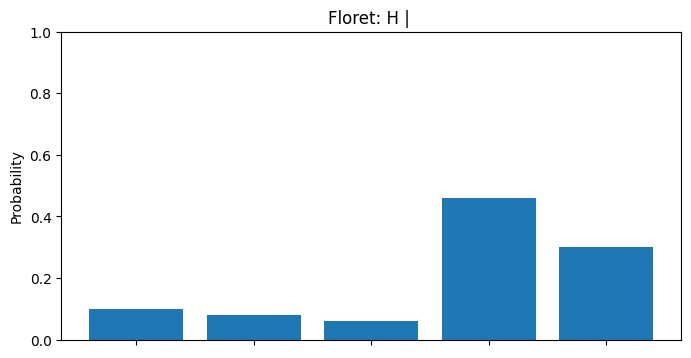

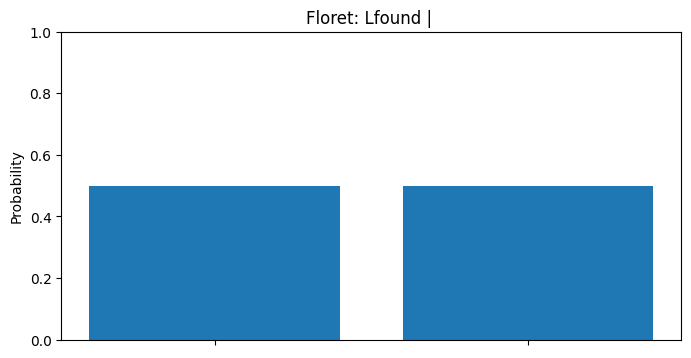

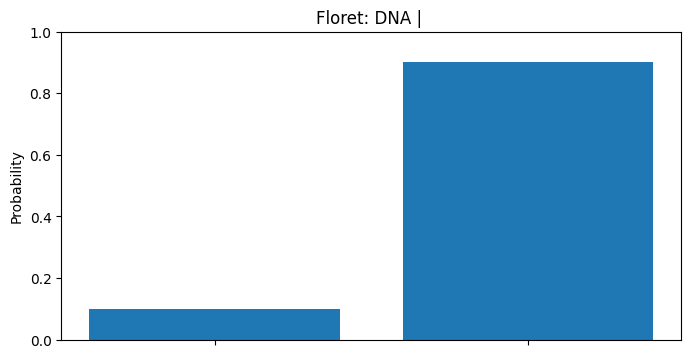

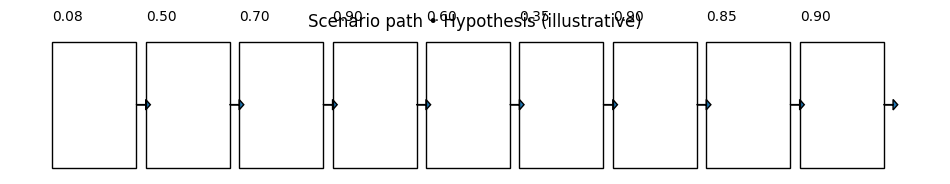


Table 3: Decision & Information (evidence: Blood=Yes)
P(O=Present|e): 0.548
EU(Pursue)=4.582  EU(Don't)=-6.130  → Action: pursue
EIG(DNA;O|e)=0.618 bits   EIG(Hand;O|e)=0.001 bits
EVSI(DNA|e)=0.000   EVSI(Hand|e)=0.000

Next best test by EVSI (≥0 means worth doing):
  DNA    EVSI=0.000
  Hand   EVSI=0.000

Table 4: EU across evidence subsets (sorted by P(W=Offender|e))
                                                         evidence        q  EU_pursue  EU_no_pursue     EU_not action
                 {'Blood': 'Yes', 'DNA': 'O', 'Hand': 'Offender'} 0.983978   9.807734    -11.791712 -11.791712 pursue
{'Blood': 'Yes', 'DNA': 'O', 'Hand': 'Offender', 'Lfound': 'Yes'} 0.983891   9.806694    -11.790586 -11.790586 pursue
                                     {'Blood': 'Yes', 'DNA': 'O'} 0.981259   9.775112    -11.756371 -11.756371 pursue
                    {'Blood': 'Yes', 'DNA': 'O', 'Lfound': 'Yes'} 0.981158   9.773891    -11.755049 -11.755049 pursue
                                 {'DN

In [ ]:


# =========================================================
# 9) Stats: marginals, sinks, EIG, EU, LRs, sensitivity, bias
# =========================================================

# Decision driver: offender presence
UTILS = dict(R_tp=10, C_fp=2, C_fn=12, R_tn=1)   # keep your current values here

def q_from_O(model, evidence=None):
    """q(e) := P(O = Present | e)"""
    if evidence is None:
        evidence = {}
    post = bn_marginal(model, 'O', evidence)    # <- was 'W' before in some places
    return float(post['Present'])


def bn_marginal(model, var, evidence=None):
    hyp = evidence or {}
    states = model.get_cpds(var).state_names[var]
    # If var is already fixed in evidence, return a one-hot without calling VE
    if var in hyp:
        observed = hyp[var]
        return {s: 1.0 if s == observed else 0.0 for s in states}
    q = VE.query([var], evidence=hyp, show_progress=False)
    return {s: float(q.values[i]) for i, s in enumerate(states)}


def path_mass(G, leaf):
    """Mass of reaching 'leaf' from Start (0.0 if unreachable)."""
    mass = _node_masses(G)          # already defined above
    return float(mass.get(leaf, 0.0))


def sink_mass(G, predicate):
    """Sum of masses into leaves that satisfy predicate."""
    mass = _node_masses(G)
    leaves = [n for n in G.nodes() if G.out_degree(n) == 0]
    return sum(mass.get(leaf, 0.0) for leaf in leaves if predicate(leaf))


def is_offender_sink(history):
    return any(lab.startswith('Hand:Offender') for lab in history)

def is_victim_sink(history):
    return any(lab.startswith('Hand:Victim') for lab in history)

def entropy_bits(p_vec):
    p = np.array(p_vec, dtype=float)
    p = p[p>0]
    return -np.sum(p * np.log2(p))

def EIG_bits(model, target_var, about_var, evidence=None):
    """I(target ; about | evidence) = H(about|e) - E_{target|e}[H(about|e, target)]"""
    hyp = evidence or {}
    if target_var in hyp:
        return 0.0  # already observed ⇒ no expected info gain from (re)testing
    # H(about | e)
    post_about = bn_marginal(model, about_var, hyp)
    H_prior = entropy_bits(list(post_about.values()))
    # E posterior entropies
    post_target = bn_marginal(model, target_var, hyp)
    H_post = 0.0
    for t, pt in post_target.items():
        hyp2 = hyp.copy(); hyp2[target_var] = t
        q = bn_marginal(model, about_var, hyp2)
        H_post += pt * entropy_bits(list(q.values()))
    return H_prior - H_post



def entropy_binary(p: float) -> float:
    p = max(min(p, 1-1e-12), 1e-12)
    return -(p*math.log2(p) + (1-p)*math.log2(1-p))

def EVSI_of_test(model, test_var, evidence=None, utils=UTILS, test_cost=0.0):
    """
    EVSI(T | e) = E_t [ max_d EU(d | e, T=t) ] - max_d EU(d | e) - test_cost
    Decision driver is O, via expected_utility_* above.
    """
    if evidence is None:
        evidence = {}
    # baseline best EU under current evidence
    base_best = max(expected_utility_pursue(model, evidence, utils),
                    expected_utility_no_pursue(model, evidence, utils))

    # distribution of the test outcome under current evidence
    p_t = bn_marginal(model, test_var, evidence)

    # expected best EU after observing T
    exp_best = 0.0
    for t_val, p in p_t.items():
        ev = dict(evidence)
        ev[test_var] = t_val
        best = max(expected_utility_pursue(model, ev, utils),
                   expected_utility_no_pursue(model, ev, utils))
        exp_best += float(p) * best

    return exp_best - base_best - float(test_cost)






# --- Decision driver: offender presence (W='Offender') ---
OFFENDER_PRESENT = 'Present'

def p_presence_given_evidence(model, evidence=None) -> float:
    hyp = evidence or {}
    q = VE.query(['O'], evidence=hyp, show_progress=False)
    idx = model.get_cpds('O').state_names['O'].index(OFFENDER_PRESENT)
    return float(q.values[idx])

# Expected utilities now use p(O=Present | e)
R_tp, C_fp, C_fn, R_tn = 10, 2, 12, 1  # your current utilities

# --- Decision driver: offender presence (O) ---

UTILS = dict(R_tp=10, C_fp=2, C_fn=12, R_tn=1)   # your current utilities

def q_from_O(model, evidence=None):
    """q(e) := P(O = Present | e)"""
    if evidence is None:
        evidence = {}
    post = bn_marginal(model, 'O', evidence)
    return float(post['Present'])

def expected_utility_actions(model, evidence=None, utils=UTILS):
    """
    Returns a dict with q and BOTH EU keys your notebook prints:
      'EU_pursue', 'EU_no_pursue', plus alias 'EU_not' and the chosen 'action'.
    """
    if evidence is None:
        evidence = {}
    q = q_from_O(model, evidence)
    EU_pursue    = q * utils['R_tp'] - (1.0 - q) * utils['C_fp']
    EU_no_pursue = (1.0 - q) * utils['R_tn'] - q * utils['C_fn']
    action = 'pursue' if EU_pursue >= EU_no_pursue else 'no_pursue'
    return {
        'q': q,
        'EU_pursue': EU_pursue,
        'EU_no_pursue': EU_no_pursue,
        'EU_not': EU_no_pursue,   # <-- alias so your print line works
        'action': action,         # <-- added for your later use
    }

def expected_utility_pursue(model, evidence=None, utils=UTILS):
    return expected_utility_actions(model, evidence, utils)['EU_pursue']

def expected_utility_no_pursue(model, evidence=None, utils=UTILS):
    return expected_utility_actions(model, evidence, utils)['EU_no_pursue']

def best_action_and_EU(model, evidence=None, utils=UTILS):
    """
    Clean wrapper that respects the new helpers and returns (action, EU_best).
    """
    eu = expected_utility_actions(model, evidence, utils)
    return (eu['action'],
            eu['EU_pursue'] if eu['action'] == 'pursue' else eu['EU_no_pursue'])




def threshold_qstar(R_tp=R_tp, C_fp=C_fp, C_fn=C_fn, R_tn=R_tn):
    return (R_tn + C_fp) / (R_tp + C_fp + R_tn + C_fn)




def q_star(R_tp=R_tp, C_fp=C_fp, C_fn=C_fn, R_tn=R_tn):
    """Bayes action threshold for pursue vs no_pursue."""
    return (R_tn + C_fp) / (R_tp + C_fp + C_fn + R_tn)

# --- Decision driver q(e) ---
def q_offender(MODEL, evidence):
    """
    Decision driver q(e) = P(W='Offender' | evidence).
    Assumes your bn_marginal returns a dict-like {state: prob}.
    """
    pm = bn_marginal(MODEL, 'W', evidence)
    return float(pm['Offender'])




def likelihood_ratio(model, var, state, H1, H0, evidence=None):
    hyp = evidence or {}
    hyp1 = hyp.copy(); hyp1['H'] = H1
    hyp0 = hyp.copy(); hyp0['H'] = H0
    p1 = bn_marginal(model, var, hyp1)[state]
    p0 = bn_marginal(model, var, hyp0)[state]
    return p1 / p0 if p0>0 else float('inf')

def sensitivity_curve_DNA(model, deltas=np.linspace(0, 0.20, 21), evidence=None):
    """
    Degrade DNA reliability by blending each CPD column toward uniform.
    Parent-aware: works for DNA|H,Ltime,W (or any parent set).
    Returns [(delta, EIG_bits(DNA; H | evidence))].
    """
    global VE
    evidence = evidence or {}

    # Keep originals
    orig = model.get_cpds('DNA')
    orig_vals = np.array(orig.get_values(), dtype=float)
    var_card = model.get_cardinality('DNA')      # 2
    parents  = orig.get_evidence() or []         # e.g. ['H','Ltime','W']
    e_cards  = [model.get_cardinality(p) for p in parents]
    state_names = orig.state_names

    # Column-wise uniform target
    uni = np.full_like(orig_vals, 1.0 / var_card)

    results = []
    for d in deltas:
        blended = (1.0 - d) * orig_vals + d * uni
        # Rebuild a fresh CPD with the same parents & cards
        if parents:
            cpd = TabularCPD(
                variable='DNA',
                variable_card=var_card,
                values=blended.tolist(),
                evidence=parents,
                evidence_card=e_cards,
                state_names=state_names
            )
        else:
            cpd = TabularCPD(
                variable='DNA',
                variable_card=var_card,
                values=blended.tolist(),
                state_names=state_names
            )

        # Swap in and recompute
        model.remove_cpds(model.get_cpds('DNA'))
        model.add_cpds(cpd)
        assert model.check_model()
        VE = VariableElimination(model)

        results.append((float(d), float(EIG_bits(model, 'DNA', 'H', evidence=evidence))))

    # Restore original
    model.remove_cpds(model.get_cpds('DNA'))
    model.add_cpds(orig)
    VE = VariableElimination(model)
    assert model.check_model()

    return results



def bias_scenarios_on_H(model, scenarios, evidence=None):
    """
    Temporarily swap P(H) prior; report P(O=Present|e), EU with new utility,
    and EIG of key tests about W under that prior.
    """
    global VE
    orig = model.get_cpds('H')
    out = {}

    for name, prior in scenarios.items():
        cpd = TabularCPD('H', 5, np.array(prior, dtype=float).reshape(5,1),
                         state_names={'H': VAR_STATES['H']})
        model.remove_cpds(model.get_cpds('H')); model.add_cpds(cpd)
        assert model.check_model()
        VE = VariableElimination(model)

        eu = expected_utility_actions(model, evidence=evidence)
        out[name] = {
            'P(O=Present|e)': eu['q'],                 # was 'P(W=Offender|e)': eu['P_offender']
            'EU(Pursue)': eu['EU_pursue'],
            'EU(Dont)':   eu['EU_not'],
            'Action':     eu['action'],
            'EIG(DNA;O|e)':  EIG_bits(model, 'DNA',  'O', evidence=evidence),
            'EIG(Hand;O|e)': EIG_bits(model, 'Hand', 'O', evidence=evidence),
        }


    # restore prior
    model.remove_cpds(model.get_cpds('H')); model.add_cpds(orig)
    VE = VariableElimination(model); assert model.check_model()
    return out


def sink_mass_conditional(G, predicate, evidence):
    """
    Renormalised mass among leaves consistent with 'evidence'.
    """
    mass = _node_masses(G)
    leaves = [n for n in G.nodes() if G.out_degree(n) == 0]

    def leaf_matches_evidence(leaf):
        hist = dict(parse_label(x) for x in leaf if ':' in x)
        return all(hist.get(v) == s for v, s in evidence.items())

    # total mass of leaves consistent with evidence
    Z = sum(mass.get(leaf, 0.0) for leaf in leaves if leaf_matches_evidence(leaf))
    if Z <= 0.0:
        return 0.0

    good = sum(
        mass.get(leaf, 0.0)
        for leaf in leaves
        if leaf_matches_evidence(leaf) and predicate(leaf)
    )
    return good / Z

@contextmanager
def temporarily_replace_cpd(model, var, new_cpd):
    """Replace a model CPD for the duration of the context and restore afterwards."""
    orig = model.get_cpds(var)
    model.remove_cpds(orig)
    model.add_cpds(new_cpd)
    model.check_model()
    try:
        yield
    finally:
        model.remove_cpds(new_cpd)
        model.add_cpds(orig)
        model.check_model()


def sensitivity_curve_HAND(model, deltas, evidence):
    global VE  # <-- add this
    orig = model.get_cpds('Hand')
    vals = orig.get_values()
    uni = np.full_like(vals, 1.0 / vals.shape[0])

    parents = orig.get_evidence() or []
    evidence_card = [model.get_cardinality(p) for p in parents]

    def make_cpd(new_vals):
        return TabularCPD(
            variable='Hand', variable_card=2,
            values=new_vals.tolist(),
            evidence=parents if parents else None,
            evidence_card=evidence_card if parents else None,
            state_names=orig.state_names
        )

    curve = []
    for d in deltas:
        blended = (1 - d) * vals + d * uni
        new_cpd = make_cpd(blended)
        model.remove_cpds(model.get_cpds('Hand'))
        model.add_cpds(new_cpd)
        model.check_model()
        VE = VariableElimination(model)  # <-- refresh! now EIG sees the updated CPD
        eig = EIG_bits(model, 'Hand', 'O', evidence=evidence)
        curve.append(eig)

    # restore
    model.remove_cpds(model.get_cpds('Hand')); model.add_cpds(orig)
    model.check_model()
    VE = VariableElimination(model)  # <-- refresh back to original

    return curve




def find_crossover(model, evidence=None, deltas=np.linspace(0, 0.5, 51), about_var='O'):
    """
    Finds delta where EIG(DNA; about_var) == EIG(Hand; about_var), parent-aware.
    """
    evidence = evidence or {}
    orig_DNA = model.get_cpds('DNA')
    orig_Hand = model.get_cpds('Hand')

    # Parent info for DNA
    dna_parents = orig_DNA.get_evidence()
    dna_cards = [model.get_cardinality(p) for p in dna_parents]
    var_card_dna = model.get_cardinality('DNA')

    # Parent info for Hand
    hand_parents = orig_Hand.get_evidence()
    hand_cards = [model.get_cardinality(p) for p in hand_parents]
    var_card_hand = model.get_cardinality('Hand')

    # Uniform targets
    uniD = np.full_like(orig_DNA.get_values(), 1.0 / var_card_dna)
    uniH = np.full_like(orig_Hand.get_values(), 1.0 / var_card_hand)

    vD_orig = np.array(orig_DNA.get_values(), dtype=float)
    vH_orig = np.array(orig_Hand.get_values(), dtype=float)

    best_delta = None
    best_diff = 1e9
    best_eDNA = None
    best_eHAND = None

    for d in deltas:
        vD = (1 - d) * vD_orig + d * uniD
        vH = (1 - d) * vH_orig + d * uniH

        # Build CPDs with correct parents
        cpdD = TabularCPD(
            variable='DNA',
            variable_card=var_card_dna,
            values=vD.tolist(),
            evidence=dna_parents,
            evidence_card=dna_cards,
            state_names=orig_DNA.state_names
        )

        cpdH = TabularCPD(
            variable='Hand',
            variable_card=var_card_hand,
            values=vH.tolist(),
            evidence=hand_parents,
            evidence_card=hand_cards,
            state_names=orig_Hand.state_names
        )

        model.remove_cpds(model.get_cpds('DNA'))
        model.remove_cpds(model.get_cpds('Hand'))
        model.add_cpds(cpdD, cpdH)
        assert model.check_model()

        VE_temp = VariableElimination(model)
        eDNA = EIG_bits(model, 'DNA', about_var, evidence=evidence)
        eHAND = EIG_bits(model, 'Hand', about_var, evidence=evidence)

        diff = abs(eDNA - eHAND)
        if diff < best_diff:
            best_diff = diff
            best_delta = d
            best_eDNA = eDNA
            best_eHAND = eHAND

    # Restore originals
    model.remove_cpds(model.get_cpds('DNA'))
    model.remove_cpds(model.get_cpds('Hand'))
    model.add_cpds(orig_DNA, orig_Hand)
    assert model.check_model()

    return best_delta, best_eDNA, best_eHAND


def power_set_dicts(base_evidence: dict):
    items = list(base_evidence.items())
    for r in range(1, len(items)+1):
        for combo in combinations(items, r):
            yield dict(combo)

def EU_table_over_evidence_sets(model, atoms: dict):
    rows = []
    for hyp in power_set_dicts(atoms):
        r = expected_utility_actions(model, hyp)
        rows.append({'evidence': hyp, **r})
    df = pd.DataFrame(rows).sort_values('q', ascending=False).reset_index(drop=True)
    return df




# =========================================================
# 10) Run: plots, sanity, stats, comparisons
# =========================================================

# First-layers plots (optional; depends on graphviz availability)
# draw_first_layers(BUILDS['ev']['G'],  "Ev-first • first 3 layers", depth=3, figsize=(7,9))
# draw_first_layers(BUILDS['chr']['G'], "Chrono • first 3 layers",   depth=3, figsize=(7,9))

# Example florets (pick any history)
draw_floret(MODEL, history=(), next_var='H')
draw_floret(MODEL, history=(canonical_label('H','O_self'),), next_var='Lfound')
draw_floret(MODEL, history=(canonical_label('W','Offender'),), next_var='DNA')

# Example scenario path (hand-built for illustration)
labels_with_p = [
    (STATE_LABEL['H']['O_self'], 0.08),
    (STATE_LABEL['Lfound']['Yes'], 0.50),
    (STATE_LABEL['Ltime']['After'], 0.70),
    (STATE_LABEL['W']['Offender'], 0.90),
    (STATE_LABEL['Blood']['Yes'], 0.60),
    (STATE_LABEL['BP']['Fingerprint-like'], 0.35),  # or 'Spatter', with the right prob
    (STATE_LABEL['DNA']['O'], 0.90),
    (STATE_LABEL['AL']['Pass'], 0.85),
    (STATE_LABEL['Hand']['Offender'], 0.90),
]
draw_scenario_path(labels_with_p, title="Scenario path • Hypothesis (illustrative)")

# CEG (positions) sketches
# draw_ceg_positions(BUILDS['ev']['G'],  BUILDS['ev']['pos'],  title="CEG (positions) • Ev-first")
# draw_ceg_positions(BUILDS['chr']['G'], BUILDS['chr']['pos'], title="CEG (positions) • Chrono")

# Audits-merged graphs mode
for name in ('hyp','chr'):
    Gm = BUILDS[name]['noaudit']
    assert_outflows_sum_to_1(Gm)
    assert_unique_labels_per_floret(Gm)

# --- Final stats
# 1) Mode marginals unconditional and under evidence Blood=Yes
marg_uncond_hyp = bn_marginal(MODEL, 'H')
marg_blood_hyp  = bn_marginal(MODEL, 'H', evidence={'Blood':'Yes'})

# 2) Sink masses (using audits-merged Ev-first just for display)
Gviz = BUILDS['hyp']['noaudit']
mass_off = sink_mass(Gviz, is_offender_sink)
mass_vic = sink_mass(Gviz, is_victim_sink)

# 3) Decision & Info gain under Blood=Yes (now wrt W)
e = {'Blood':'Yes'}
eu = expected_utility_actions(MODEL, evidence=e)
eig_dna_O  = EIG_bits(MODEL, target_var='DNA',  about_var='O', evidence=e)
eig_hand_O = EIG_bits(MODEL, target_var='Hand', about_var='O', evidence=e)
# eig_dna_W  = EIG_bits(MODEL, target_var='DNA', about_var='W', evidence=e)

evsi_dna   = EVSI_of_test(MODEL, 'DNA',  evidence=e, test_cost=0.0)
evsi_hand  = EVSI_of_test(MODEL, 'Hand', evidence=e, test_cost=0.0)

print("\nTable 3: Decision & Information (evidence: Blood=Yes)")
print(f"P(O=Present|e): {eu['q']:.3f}")
print(f"EU(Pursue)={eu['EU_pursue']:.3f}  EU(Don't)={eu['EU_not']:.3f}  → Action: {eu['action']}")
print(f"EIG(DNA;O|e)={eig_dna_O:.3f} bits   EIG(Hand;O|e)={eig_hand_O:.3f} bits")
print(f"EVSI(DNA|e)={evsi_dna:.3f}   EVSI(Hand|e)={evsi_hand:.3f}")

# 3b) Rank next best test by EVSI (example with available tests)
tests = ['DNA','Hand']  # extend if desired, e.g., 'BP' (but note AL/AS are audits)
ranked = sorted([(t, EVSI_of_test(MODEL, t, evidence=e, test_cost=0.0)) for t in tests],
                key=lambda x: x[1], reverse=True)
print("\nNext best test by EVSI (≥0 means worth doing):")
for t, val in ranked:
    print(f"  {t:5s}  EVSI={val:.3f}")

# 3c) EU across evidence combinations to show policy shifts
atoms = {
    'Blood': 'Yes',
    'DNA':   'O',
    'Hand':  'Offender',
    'Lfound':'Yes',
}
df_eu = EU_table_over_evidence_sets(MODEL, atoms)
print("\nTable 4: EU across evidence subsets (sorted by P(W=Offender|e))")
print(df_eu.head(10).to_string(index=False))


# 4) Chrono vs Ev-first consistency check (same joint ⇒ same numbers)
#    Here we recompute sink masses on chrono tree; they should match.
Gviz_ch = BUILDS['chr']['noaudit']
mass_off_ch = sink_mass(Gviz_ch, is_offender_sink)
mass_vic_ch = sink_mass(Gviz_ch, is_victim_sink)
print("\nConsistency: sinks Hypothesis vs Chrono")
print("Offender:", round(mass_off,6), "vs", round(mass_off_ch,6),
      "  Victim:", round(mass_vic,6), "vs", round(mass_vic_ch,6))

# 5) Likelihood ratios for audits (example)
LR_scene_pass = likelihood_ratio(MODEL, 'AS', 'Pass', H1='O_delib', H0='V_acc', evidence={'Blood':'Yes'})
LR_scene_fail = likelihood_ratio(MODEL, 'AS', 'Fail', H1='O_delib', H0='V_acc', evidence={'Blood':'Yes'})
print("\nAppendix C: LRs (AS | Blood=Yes)   H1=O_delib , H0=V_acc")
print("LR(AS=Pass):", round(LR_scene_pass,3), "  LR(AS=Fail):", round(LR_scene_fail,3))

# 6) Sensitivity: degrade DNA reliability
curve = sensitivity_curve_DNA(MODEL, deltas=np.linspace(0,0.20,21), evidence={'Blood':'Yes'})
print("\nSensitivity: EIG(DNA;H | Blood=Yes)")
for d, val in curve:
    print(f"Δ={d:0.2f}   EIG={val:0.3f} bits")

# 7) Bias scenarios on H
scenarios = {
    'True-world'     : [0.10,0.08,0.06,0.46,0.30],
    'Investigator-bias' : [0.25,0.25,0.15,0.25,0.10],
    'Fair-reweighted': [0.20,0.20,0.20,0.20,0.20],
    'Extreme-bias'   : [0.45,0.25,0.15,0.10,0.05],
}
bias = bias_scenarios_on_H(MODEL, scenarios, evidence={'Blood':'Yes'})
print("\nAppendix A: Bias scenarios (evidence Blood=Yes)")
for name, d in bias.items():
    print(f"{name:18s}  P(O|e)={d['P(O=Present|e)']:.3f}  "
        f"EU(P)={d['EU(Pursue)']:.2f}  EU(D)={d['EU(Dont)']:.2f}  → {d['Action']:<13s}  "
        f"EIG(DNA;O|e)={d['EIG(DNA;O|e)']:.3f}  EIG(Hand;O|e)={d['EIG(Hand;O|e)']:.3f}")



e = {'Blood':'Yes'}
Gviz = BUILDS['hyp']['noaudit']
print("P(Off sink | Blood=Yes):", sink_mass_conditional(Gviz, is_offender_sink, e))
print("P(Vic sink | Blood=Yes):", sink_mass_conditional(Gviz, is_victim_sink, e))




_e = {'Blood':'Yes'}
bn_off = bn_marginal(MODEL, 'Hand', _e)['Offender']
bn_vic = 1.0 - bn_off

G_h = BUILDS['hyp']['noaudit']; G_c = BUILDS['chr']['noaudit']
off_h = sink_mass_conditional(G_h, is_offender_sink, _e)
off_c = sink_mass_conditional(G_c, is_offender_sink, _e)
vic_h = sink_mass_conditional(G_h, is_victim_sink,   _e)
vic_c = sink_mass_conditional(G_c, is_victim_sink,   _e)

tol = 1e-4  # robust after pruning/bridging; 1e-6 is too tight here
print("BN  P(Off | Blood=Yes):", bn_off)
print("HYP P(Off | Blood=Yes):", off_h, "  Δ=", off_h - bn_off)
print("CHR P(Off | Blood=Yes):", off_c, "  Δ=", off_c - bn_off)
print("HYP/CHR P(Vic | Blood=Yes):", vic_h, vic_c, "  BN:", bn_vic)

assert math.isclose(off_h, bn_off, abs_tol=tol) and math.isclose(off_c, bn_off, abs_tol=tol), \
       "Tree–BN drift beyond tolerance (try the no-prune tweak above)."
assert math.isclose(vic_h, bn_vic, abs_tol=tol) and math.isclose(vic_c, bn_vic, abs_tol=tol)




In [ ]:
G_h_full = BUILDS['hyp']['G']
G_c_full = BUILDS['chr']['G']
off_h_full = sink_mass_conditional(G_h_full, is_offender_sink, _e)
off_c_full = sink_mass_conditional(G_c_full, is_offender_sink, _e)
print("Pre-audit trees  Off(HYP/CHR):", off_h_full, off_c_full)


Pre-audit trees  Off(HYP/CHR): 0.11485157772756108 0.11485157772756108


In [ ]:
# --- folders (unchanged) ---
def ensure_dir(path):
    os.makedirs(path, exist_ok=True)

ROOT_DIR = "figs"
DIRS = {
    "staged_hyp":   os.path.join(ROOT_DIR, "staged_hypothesis"),
    "staged_ch":   os.path.join(ROOT_DIR, "staged_chrono"),
    "ceg_hyp":      os.path.join(ROOT_DIR, "ceg_hypothesis"),
    "ceg_ch":      os.path.join(ROOT_DIR, "ceg_chrono"),
    "ceg_hyp_high": os.path.join(ROOT_DIR, "ceg_hypothesis_highlight"),
    "florets":     os.path.join(ROOT_DIR, "florets"),
    "chains":      os.path.join(ROOT_DIR, "chains"),
    "appendix_raw":      os.path.join(ROOT_DIR, "raw"),
}
for d in DIRS.values():
    ensure_dir(d)
ensure_dir(os.path.join(ROOT_DIR, "chain"))
ensure_dir(os.path.join(ROOT_DIR, "layers"))
ensure_dir(os.path.join(ROOT_DIR, "florets_local"))


G_hyp_full = BUILDS['hyp']['G']
G_ch_full = BUILDS['chr']['G']


for h in VAR_STATES['H']:
    G_hyp_h = prune_keep_state_at_var(G_hyp_full, 'H', h)

    # recompute stages/positions on this restricted subtree
    st_hyp_h, _ = compute_positions(G_hyp_h)

    # (A) readable, node-wise pruned (NOT stage-symmetric)
    render_staged_subtree_pdf(
        G_hyp_h, st_hyp_h, [],
        pdf_path=os.path.join(DIRS["staged_hyp"], f"hyp_subtree_{h}_staged_readable"),
        title=f"Hypothesis • staged subtree • {STATE_LABEL['H'][h]}",
        depth=None, rankdir='LR', a4='landscape',
        min_edge_prob=0.01, mass_cut=1e-3, summarize_tail=True
    )

    # (B) stage-symmetric, label-wise pruning across each stage
    render_staged_subtree_pdf_stage_sym(
        G_hyp_h, st_hyp_h, [],
        pdf_path=os.path.join(DIRS["staged_hyp"], f"hyp_subtree_{h}_staged_stageSym"),
        title=f"Hypothesis • staged subtree (stage-symmetric) • {STATE_LABEL['H'][h]}",
        depth=None, rankdir='LR', a4='landscape',
        min_edge_prob=0.01, mass_cut=0.0, summarize_tail=True,
        multipage=True
)


for h in VAR_STATES['H']:
    G_ch_h = prune_keep_state_at_var(G_ch_full, 'H', h)

    # recompute stages/positions on this restricted subtree
    st_ch_h, _ = compute_positions(G_ch_h)

    # (A) readable, node-wise pruned (NOT stage-symmetric)
    render_staged_subtree_pdf(
        G_ch_h, st_ch_h, [],                           # start at root
        pdf_path=os.path.join(DIRS["staged_ch"], f"chrono_subtree_{h}_staged_readable"),
        title=f"Chrono• staged subtree • {STATE_LABEL['H'][h]}",
        depth=None,                   # full depth
        rankdir='LR', a4='landscape',
        min_edge_prob=0.01, mass_cut=1e-3, summarize_tail=True
    )

    # (B) stage-symmetric, label-wise pruning across each stage
    render_staged_subtree_pdf_stage_sym(
        G_ch_h, st_ch_h, history_seq=[],
        pdf_path=os.path.join(DIRS["staged_ch"], f"chrono_subtree_{h}_staged_stageSym"),
        title=f"Chrono • staged subtree • {STATE_LABEL['H'][h]}",
        depth=None, rankdir='LR', a4='landscape',
        min_edge_prob=0.01,
        mass_cut=0.0,
        summarize_tail=True
    )


# Example: raw event subtree (Hypothesis-First), restricted to one H state, no colours.
for h in VAR_STATES['H']:
    G_hyp_h = prune_keep_state_at_var(BUILDS['hyp']['G'], 'H', h)
    render_event_tree_pdf(
        G_hyp_h,
        pdf_path=os.path.join(DIRS["appendix_raw"], f"raw_event_subtree_{h}"),
        title=f"Raw event subtree • {STATE_LABEL['H'][h]}",
        depth=None, rankdir='LR',
        node_colors=None,
        multipage=True,   # tile across multiple pages so *nothing* is pruned
        a4='landscape'
    )





# --- 3) CEGs (positions): audits shown + audits merged (appendix) ---
# Ev-first (audits shown)
G_hyp = BUILDS['hyp']['G']; _, pos_hyp = compute_positions(G_hyp)
Q_hyp = make_position_quotient(G_hyp, pos_hyp)

render_ceg_pdf_tidy(
    Q_hyp,
    os.path.join(DIRS["ceg_hyp"], "hyp_ceg_positions_readable"),
    title="Hypothesis • CEG (positions)",
    a4='landscape',       # or 'portrait'
    rankdir='LR',         # or 'TB'
    nodesep=0.24,
    ranksep=0.80,         # ⬅ increase for more vertical space
    node_width=0.44,
    two_sinks=True,
)

# Ev-first (audits merged)
G_hyp_na = BUILDS['hyp']['noaudit']; _, pos_hyp_na = compute_positions(G_hyp_na)
Q_hyp_na = make_position_quotient(G_hyp_na, pos_hyp_na)


render_ceg_pdf_tidy(
    Q_hyp_na, os.path.join(DIRS["ceg_hyp"], "hyp_ceg_positions_noaudit"),
    title="Hypothesis • CEG (audits merged)",
    a4='landscape',       # or 'portrait'
    rankdir='LR',         # or 'TB'
    nodesep=0.24,
    ranksep=0.80,         # ⬅ increase for more vertical space
    node_width=0.44,
    two_sinks=True,
)


# Chrono (audits shown)
G_ch = BUILDS['chr']['G']; _, pos_ch = compute_positions(G_ch)
Q_ch = make_position_quotient(G_ch, pos_ch)


render_ceg_pdf_tidy(
    Q_ch, os.path.join(DIRS["ceg_ch"], "chrono_ceg_positions"),
    title="Chrono • CEG (positions)",
    a4='landscape',       # or 'portrait'
    rankdir='LR',         # or 'TB'
    nodesep=0.24,
    ranksep=0.80,         # ⬅ increase for more vertical space
    node_width=0.44,
    two_sinks=True,
)


# Chrono (audits merged)
G_ch_na = BUILDS['chr']['noaudit']; _, pos_ch_na = compute_positions(G_ch_na)
Q_ch_na = make_position_quotient(G_ch_na, pos_ch_na)



render_ceg_pdf_tidy(
    Q_ch_na, os.path.join(DIRS["ceg_ch"], "chrono_ceg_positions_noaudit"),
    title="Chrono • CEG (audits merged)",
    a4='landscape',       # or 'portrait'
    rankdir='LR',         # or 'TB'
    nodesep=0.24,
    ranksep=0.80,         # ⬅ increase for more vertical space
    node_width=0.44,
    two_sinks=True,
)


# --- 5) Visual aids: florets (unchanged) ---
def save_floret_pdf(var, history, outbase):
    states = VAR_STATES[var]
    probs  = [get_prob_bn(MODEL, history, var, s) for s in states]
    s = sum(probs); probs = [p/s for p in probs]
    labels = [STATE_LABEL[var][s] for s in states]
    fig = plt.figure(figsize=(8.27, 11.69))  # A4 portrait
    ax = fig.add_subplot(111)
    ax.bar(range(len(states)), probs)
    ax.set_xticks(range(len(states)))
    ax.set_xticklabels(labels, rotation=30, ha='right')
    ax.set_ylim(0,1)
    ax.set_ylabel("Probability")
    htxt = " → ".join([STATE_LABEL[parse_label(h)[0]][parse_label(h)[1]] for h in history]) if history else ""
    ax.set_title(f"Floret: {var} | {htxt}")
    fig.tight_layout()
    fig.savefig(os.path.join(DIRS["florets"], f"{outbase}.pdf"))
    plt.close(fig)

save_floret_pdf('H', (), "floret_H")
save_floret_pdf('Lfound', (canonical_label('H','O_self'),), "floret_Lfound_given_Oself")
save_floret_pdf('DNA', (canonical_label('W','Offender'),), "floret_DNA_given_Offender")


In [ ]:
# (B) Scenario-highlighted
scenario = [
    ('H','O_self'), ('Lfound','Yes'), ('Ltime','After'),
    ('O','Present'),
    ('W','Offender'), ('Blood','Yes'), ('BP','Fingerprint-like'),
    ('AS','Pass'), ('DNA','O'), ('AL','Pass'), ('Hand','Offender')
]
hi_scn = scenario_highlight_for_ceg(G_hyp_full, pos_hyp, scenario)

render_ceg_pdf_tidy(
    Q_hyp,
    "hyp_ceg_positions_highlighted",
    title="Hypothesis • CEG (highlighted scenario)",
    a4='landscape', rankdir='LR',
    nodesep=0.24, ranksep=0.80, node_width=0.44,
    two_sinks=True,
    highlight=hi_scn, fade=True,
    # softer highlight colour that works on white
    highlight_color="#b74b4b"
)

# (C) All root→Victim paths highlighted
hi_victim = highlight_all_paths_to_sink(G_hyp_full, pos_hyp, sink='Victim')
render_ceg_pdf_tidy(
    Q_hyp,
    "hyp_ceg_positions_all_to_victim",
    title="Hypothesis • CEG (all root→Victim paths)",
    a4='landscape', rankdir='LR',
    nodesep=0.24, ranksep=0.80, node_width=0.44,
    two_sinks=True,
    highlight=hi_victim, fade=True,
    highlight_color="#b74b4b"
)

# (D) All root→Offender paths highlighted
hi_offender = highlight_all_paths_to_sink(G_hyp_full, pos_hyp, sink='Offender')
render_ceg_pdf_tidy(
    Q_hyp,
    "hyp_ceg_positions_all_to_offender",
    title="Hypothesis • CEG (all root→Offender paths)",
    a4='landscape', rankdir='LR',
    nodesep=0.24, ranksep=0.80, node_width=0.44,
    two_sinks=True,
    highlight=hi_offender, fade=True,
    highlight_color="#b74b4b"
)

In [ ]:
# =========================================================
# MAIN STATS & RESULTS DASHBOARD (uses current helpers)
# =========================================================
import pandas as pd

def _disp(df, title):
    print(f"\n{title}")
    try:
        display(df)  # Jupyter/IPython
    except Exception:
        print(df)

import numpy as np

def _coerce_scenarios_to_vectors(scen_obj):
    """
    Accepts:
      - {'Scenario': [p1,p2,p3,p4,p5]}
      - {'Scenario': {'h1':..,'h2':..,'h3':..,'h4':..,'h5':..}}
      - {'Scenario': {'O_delib':..,'O_self':..,'O_acc':..,'V_acc':..,'Suicide':..}}
    Returns: {'Scenario': [vector in VAR_STATES['H'] order]}
    """
    if scen_obj is None:
        return {
            'True-world'       : [0.10,0.08,0.06,0.46,0.30],
            'Investigator-bias': [0.25,0.25,0.15,0.25,0.10],
            'Fair-reweighted'  : [0.20,0.20,0.20,0.20,0.20],
            'Extreme-bias'     : [0.45,0.25,0.15,0.10,0.05],
        }

    any_val = next(iter(scen_obj.values()))
    # Already a vector
    if isinstance(any_val, (list, tuple, np.ndarray)):
        out = {}
        for name, vec in scen_obj.items():
            v = list(map(float, vec))
            s = sum(v)
            out[name] = [x/s for x in v] if s > 0 else v
        return out

    # Dict → map into notebook’s H order
    if isinstance(any_val, dict):
        H_order_labels = VAR_STATES['H']  # ['O_delib','O_self','O_acc','V_acc','Suicide']
        inv_H = {v: k for k, v in H_MAP.items()}  # 'O_delib' -> 'h1', etc.
        out = {}
        for name, d in scen_obj.items():
            if all(k in d for k in ('h1','h2','h3','h4','h5')):
                vec = [float(d[inv_H[label]]) for label in H_order_labels]
            else:
                vec = [float(d[label]) for label in H_order_labels]
            s = sum(vec)
            out[name] = [x/s for x in vec] if s > 0 else vec
        return out

    raise TypeError("Unsupported scenario prior structure.")



def compute_main_stats():
    # Common evidence used in your examples
    e = {'Blood':'Yes'}

    # ---------- Table 1: Mode-of-Death marginals ----------
    # What: Prior P(H) and posterior P(H | Blood=Yes). (Same under both display orders.)
    H_states = VAR_STATES['H']
    pH_prior = bn_marginal(MODEL, 'H')
    pH_e     = bn_marginal(MODEL, 'H', e)

    df_modes = pd.DataFrame({
        'Mode (H)': [STATE_LABEL['H'][h] for h in H_states],
        'P(H)':     [pH_prior[h] for h in H_states],
        "P(H | Blood=Yes)": [pH_e[h] for h in H_states],
    }).set_index('Mode (H)').round(3)
    _disp(df_modes, "Table 1 — Mode-of-death marginals (prior & with Blood=Yes)")

    # ---------- Table 2: Decision & Information (about O) ----------
    # What: q(e)=P(O=Present|e), expected utilities, EIG and EVSI for DNA/Hand.
    eu = expected_utility_actions(MODEL, evidence=e)
    eig_dna  = EIG_bits(MODEL, 'DNA',  'O', evidence=e)
    eig_hand = EIG_bits(MODEL, 'Hand', 'O', evidence=e)
    evsi_dna  = EVSI_of_test(MODEL, 'DNA',  evidence=e, test_cost=0.0)
    evsi_hand = EVSI_of_test(MODEL, 'Hand', evidence=e, test_cost=0.0)
    df_decision = pd.DataFrame([{
        'Evidence': "Blood=Yes",
        "P(O=Present | e)": eu['q'],
        "EU(pursue)": eu['EU_pursue'],
        "EU(don't)":  eu['EU_no_pursue'],
        "Best action": eu['action'],
        "EIG(DNA; O | e) [bits]": eig_dna,
        "EIG(Hand; O | e) [bits]": eig_hand,
        "EVSI(DNA | e)": evsi_dna,
        "EVSI(Hand | e)": evsi_hand,
    }]).set_index('Evidence').round(3)
    _disp(df_decision, "Table 2 — Decision & information value (driver: O)")

    # ---------- Table 3: Sink masses under Blood=Yes (Ev-first vs Chrono) ----------
    # What: Probability mass into Victim/Offender sinks on the two event-trees (audits merged).
    G_hyp = BUILDS['hyp']['noaudit']
    G_chr = BUILDS['chr']['noaudit']
    off_hyp = sink_mass_conditional(G_hyp, is_offender_sink, e)
    vic_hyp = sink_mass_conditional(G_hyp, is_victim_sink,   e)
    off_chr = sink_mass_conditional(G_chr, is_offender_sink, e)
    vic_chr = sink_mass_conditional(G_chr, is_victim_sink,   e)
    df_sink = pd.DataFrame({
        'Structure': ['Ev-first','Chrono'],
        'P(Offender sink | e)': [off_hyp, off_chr],
        'P(Victim sink | e)':   [vic_hyp, vic_chr],
    }).set_index('Structure').round(3)
    _disp(df_sink, "Table 3 — Sink masses with Blood=Yes (orders should match)")

        # ---------- Table 4: Bias scenarios on P(H) ----------
    # Always define df_bias so the return never crashes.
    df_bias = pd.DataFrame()
    try:
        raw_scenarios = globals().get('scenarios', None) or globals().get('prs', None)
        bias_dict = _coerce_scenarios_to_vectors(raw_scenarios)
        bias_out = bias_scenarios_on_H(MODEL, bias_dict, evidence=e)
        df_bias = (pd.DataFrame(bias_out).T
                   .rename(columns={
                       "P(O=Present|e)":"P(O|e)",
                       "EU(Pursue)":"EU(pursue)",
                       "EU(Dont)":"EU(don't)",
                       "Action":"Best action",
                       "EIG(DNA;O|e)":"EIG(DNA;O|e)",
                       "EIG(Hand;O|e)":"EIG(Hand;O|e)",
                   })
                   .round(3))
        _disp(df_bias, "Table 4 — Bias scenarios (swap prior on H; evaluate at Blood=Yes)")
    except Exception as err:
        print(f"[Skipping bias table] {err}")



    # ---------- Appendix C: Likelihood ratios wrt O (offender presence) ----------
    # What: LR for AS/AL = Pass comparing O=Present vs O=Absent, given Blood=Yes.
    def lr_pass(var):
        num = bn_marginal(MODEL, var, {**e,'O':'Present'})['Pass']
        den = bn_marginal(MODEL, var, {**e,'O':'Absent'})['Pass']
        return (num / den) if den > 0 else float('inf')
    df_lr = pd.DataFrame({
        'Test (Pass outcome)': ['AS', 'AL'],
        'LR = P(Pass | e, O=Present) / P(Pass | e, O=Absent)': [lr_pass('AS'), lr_pass('AL')]
    }).set_index('Test (Pass outcome)').round(3)
    _disp(df_lr, "Appendix C — Likelihood ratios (condition on Blood=Yes; compare O)")

    # ---------- Appendix D: EU across evidence subsets (compact policy view) ----------
    # What: Show how EU and q(e) move across small evidence combos.
    atoms = {'Blood':'Yes', 'DNA':'O', 'Hand':'Offender', 'Lfound':'Yes'}
    df_eu = EU_table_over_evidence_sets(MODEL, atoms).rename(
        columns={'q':'P(O|e)', 'EU_no':'EU(don\'t)'}
    ).round(3)
    _disp(df_eu, "Appendix D — Expected utilities across evidence subsets")

    # Return all tables in case you want to save them
    return {
        'modes': df_modes,
        'decision': df_decision,
        'sinks': df_sink,
        'bias': df_bias,
        'lr_O': df_lr,
        'eu_grid': df_eu,
    }

# Run the dashboard
MAIN_STATS = compute_main_stats()



Table 1 — Mode-of-death marginals (prior & with Blood=Yes)


,P(H),P(H | Blood=Yes)
Mode (H),,
,0.10,0.111
,0.08,0.119
,0.06,0.089
,0.46,0.396
,0.30,0.285



Table 2 — Decision & information value (driver: O)


,P(O=Present | e),EU(pursue),EU(don't),Best action,EIG(DNA; O | e) [bits],EIG(Hand; O | e) [bits],EVSI(DNA | e),EVSI(Hand | e)
Evidence,,,,,,,,
Blood=Yes,0.548,4.582,-6.13,pursue,0.618,0.001,0.0,0.0



Table 3 — Sink masses with Blood=Yes (orders should match)


,P(Offender sink | e),P(Victim sink | e)
Structure,,
Ev-first,0.115,0.885
Chrono,0.115,0.885



Table 4 — Bias scenarios (swap prior on H; evaluate at Blood=Yes)


,P(O|e),EU(pursue),EU(don't),Best action,EIG(DNA;O|e),EIG(Hand;O|e)
True-world,0.548462,4.58154,-6.130002,pursue,0.617994,0.000537
Investigator-bias,0.550591,4.60709,-6.157681,pursue,0.610283,0.00053
Fair-reweighted,0.563697,4.764365,-6.328062,pursue,0.60494,0.000526
Extreme-bias,0.492753,3.913035,-5.405788,pursue,0.621999,0.000535



Appendix C — Likelihood ratios (condition on Blood=Yes; compare O)


,"LR = P(Pass | e, O=Present) / P(Pass | e, O=Absent)"
Test (Pass outcome),
AS,1.0
AL,1.0



Appendix D — Expected utilities across evidence subsets


,evidence,P(O|e),EU_pursue,EU_no_pursue,EU_not,action
0,"{'Blood': 'Yes', 'DNA': 'O', 'Hand': 'Offender'}",0.984,9.808,-11.792,-11.792,pursue
1,"{'Blood': 'Yes', 'DNA': 'O', 'Hand': 'Offender...",0.984,9.807,-11.791,-11.791,pursue
2,"{'Blood': 'Yes', 'DNA': 'O'}",0.981,9.775,-11.756,-11.756,pursue
3,"{'Blood': 'Yes', 'DNA': 'O', 'Lfound': 'Yes'}",0.981,9.774,-11.755,-11.755,pursue
4,"{'DNA': 'O', 'Hand': 'Offender'}",0.958,9.500,-11.458,-11.458,pursue
5,"{'DNA': 'O', 'Hand': 'Offender', 'Lfound': 'Yes'}",0.956,9.476,-11.432,-11.432,pursue
6,{'DNA': 'O'},0.951,9.417,-11.369,-11.369,pursue
7,"{'DNA': 'O', 'Lfound': 'Yes'}",0.949,9.390,-11.339,-11.339,pursue
8,"{'Blood': 'Yes', 'Hand': 'Offender'}",0.586,5.033,-6.619,-6.619,pursue
9,"{'Blood': 'Yes', 'Hand': 'Offender', 'Lfound':...",0.585,5.014,-6.599,-6.599,pursue


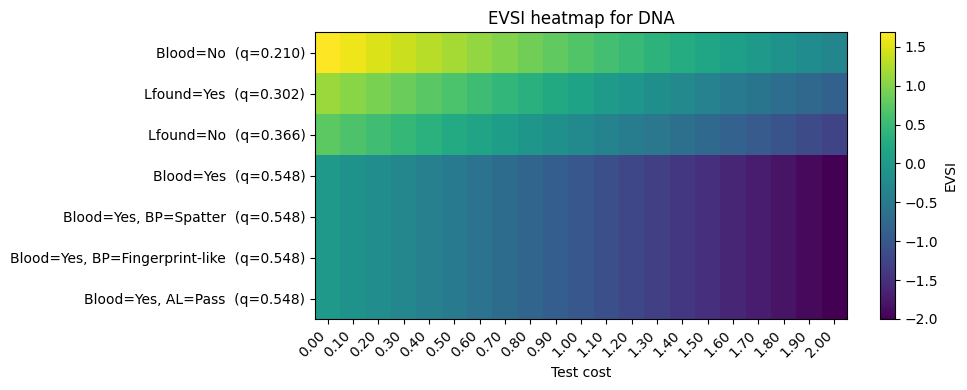

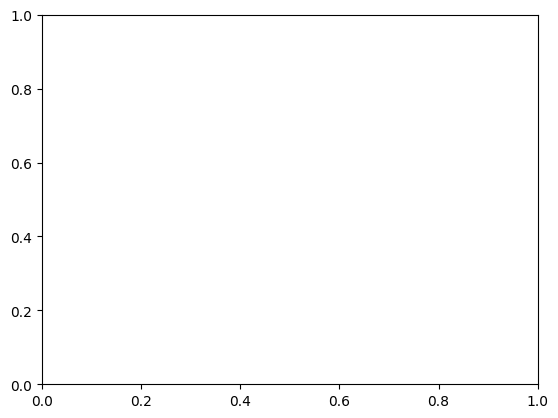

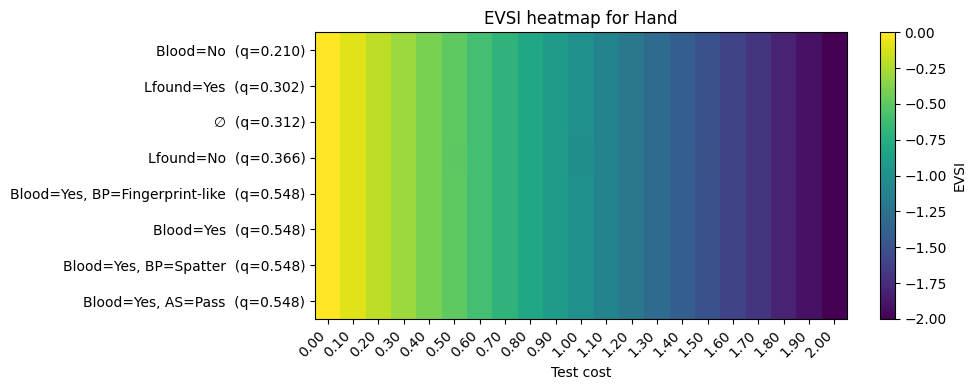

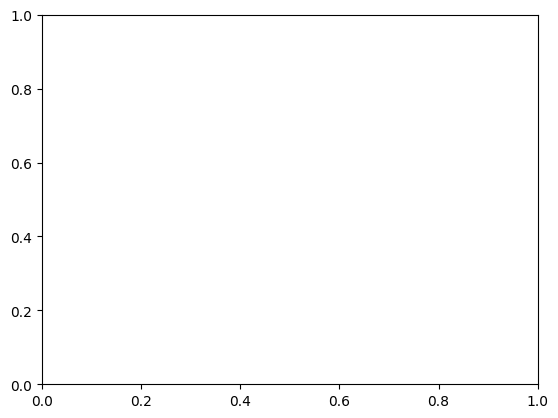

,0.00,0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90,...,1.10,1.20,1.30,1.40,1.50,1.60,1.70,1.80,1.90,2.00
Blood=No (q=0.210),1.686,1.586,1.486,1.386,1.286,1.186,1.086,0.986,0.886,0.786,...,0.586,0.486,0.386,0.286,0.186,0.086,-0.014,-0.114,-0.214,-0.314
Lfound=Yes (q=0.302),1.138,1.038,0.938,0.838,0.738,0.638,0.538,0.438,0.338,0.238,...,0.038,-0.062,-0.162,-0.262,-0.362,-0.462,-0.562,-0.662,-0.762,-0.862
Lfound=No (q=0.366),0.755,0.655,0.555,0.455,0.355,0.255,0.155,0.055,-0.045,-0.145,...,-0.345,-0.445,-0.545,-0.645,-0.745,-0.845,-0.945,-1.045,-1.145,-1.245
Blood=Yes (q=0.548),0.000,-0.100,-0.200,-0.300,-0.400,-0.500,-0.600,-0.700,-0.800,-0.900,...,-1.100,-1.200,-1.300,-1.400,-1.500,-1.600,-1.700,-1.800,-1.900,-2.000
"Blood=Yes, BP=Spatter (q=0.548)",0.000,-0.100,-0.200,-0.300,-0.400,-0.500,-0.600,-0.700,-0.800,-0.900,...,-1.100,-1.200,-1.300,-1.400,-1.500,-1.600,-1.700,-1.800,-1.900,-2.000
"Blood=Yes, BP=Fingerprint-like (q=0.548)",0.000,-0.100,-0.200,-0.300,-0.400,-0.500,-0.600,-0.700,-0.800,-0.900,...,-1.100,-1.200,-1.300,-1.400,-1.500,-1.600,-1.700,-1.800,-1.900,-2.000
"Blood=Yes, AL=Pass (q=0.548)",-0.000,-0.100,-0.200,-0.300,-0.400,-0.500,-0.600,-0.700,-0.800,-0.900,...,-1.100,-1.200,-1.300,-1.400,-1.500,-1.600,-1.700,-1.800,-1.900,-2.000


,0.00,0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90,...,1.10,1.20,1.30,1.40,1.50,1.60,1.70,1.80,1.90,2.00
Blood=No (q=0.210),0.0,-0.1,-0.2,-0.3,-0.4,-0.5,-0.6,-0.7,-0.8,-0.9,...,-1.1,-1.2,-1.3,-1.4,-1.5,-1.6,-1.7,-1.8,-1.9,-2.0
Lfound=Yes (q=0.302),-0.0,-0.1,-0.2,-0.3,-0.4,-0.5,-0.6,-0.7,-0.8,-0.9,...,-1.1,-1.2,-1.3,-1.4,-1.5,-1.6,-1.7,-1.8,-1.9,-2.0
∅ (q=0.312),-0.0,-0.1,-0.2,-0.3,-0.4,-0.5,-0.6,-0.7,-0.8,-0.9,...,-1.1,-1.2,-1.3,-1.4,-1.5,-1.6,-1.7,-1.8,-1.9,-2.0
Lfound=No (q=0.366),-0.0,-0.1,-0.2,-0.3,-0.4,-0.5,-0.6,-0.7,-0.8,-0.9,...,-1.1,-1.2,-1.3,-1.4,-1.5,-1.6,-1.7,-1.8,-1.9,-2.0
"Blood=Yes, BP=Fingerprint-like (q=0.548)",0.0,-0.1,-0.2,-0.3,-0.4,-0.5,-0.6,-0.7,-0.8,-0.9,...,-1.1,-1.2,-1.3,-1.4,-1.5,-1.6,-1.7,-1.8,-1.9,-2.0
Blood=Yes (q=0.548),0.0,-0.1,-0.2,-0.3,-0.4,-0.5,-0.6,-0.7,-0.8,-0.9,...,-1.1,-1.2,-1.3,-1.4,-1.5,-1.6,-1.7,-1.8,-1.9,-2.0
"Blood=Yes, BP=Spatter (q=0.548)",0.0,-0.1,-0.2,-0.3,-0.4,-0.5,-0.6,-0.7,-0.8,-0.9,...,-1.1,-1.2,-1.3,-1.4,-1.5,-1.6,-1.7,-1.8,-1.9,-2.0
"Blood=Yes, AS=Pass (q=0.548)",0.0,-0.1,-0.2,-0.3,-0.4,-0.5,-0.6,-0.7,-0.8,-0.9,...,-1.1,-1.2,-1.3,-1.4,-1.5,-1.6,-1.7,-1.8,-1.9,-2.0


In [ ]:
# =========================================================
# EVSI HEATMAPS — DNA and Hand across evidence & costs
# =========================================================
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

def _evsi_heatmap_for(test_var, scenarios, costs):
    """
    Build an EVSI table for `test_var` with rows = evidence scenarios,
    columns = test costs. Returns (DataFrame, row_labels_with_q).
    """
    rows = []
    labels = []
    for name, evi in scenarios:
        # don't include the test variable in evidence
        if test_var in evi:
            continue
        vals = []
        for c in costs:
            vals.append(EVSI_of_test(MODEL, test_var, evidence=evi, test_cost=float(c)))
        # label row with baseline q := P(O=Present | e)
        q = q_from_O(MODEL, evi)
        labels.append(f"{name}  (q={q:.3f})")
        rows.append(vals)

    # sort rows by q ascending for a nicer gradient
    # (extract q again from label suffix)
    order = np.argsort([float(lbl.split('=')[-1][:-1]) for lbl in labels])
    rows = [rows[i] for i in order]
    labels = [labels[i] for i in order]

    df = pd.DataFrame(rows, index=labels, columns=[f"{c:.2f}" for c in costs])
    return df, labels

def _default_evsi_scenarios(test_var):
    """
    Small, informative evidence set grid that avoids observing test_var.
    You can add/remove scenarios freely.
    """
    base = []
    if test_var != 'DNA':
        base += [
            ("∅", {}),
            ("Blood=Yes", {'Blood':'Yes'}),
            ("Blood=No",  {'Blood':'No'}),
            ("Blood=Yes, BP=Fingerprint-like", {'Blood':'Yes','BP':'Fingerprint-like'}),
            ("Blood=Yes, BP=Spatter",          {'Blood':'Yes','BP':'Spatter'}),
            ("Lfound=Yes", {'Lfound':'Yes'}),
            ("Lfound=No",  {'Lfound':'No'}),
            ("Blood=Yes, AS=Pass", {'Blood':'Yes','AS':'Pass'}),
        ]
    if test_var != 'Hand':
        base += [
            ("Blood=Yes", {'Blood':'Yes'}),
            ("Blood=No",  {'Blood':'No'}),
            ("Blood=Yes, BP=Fingerprint-like", {'Blood':'Yes','BP':'Fingerprint-like'}),
            ("Blood=Yes, BP=Spatter",          {'Blood':'Yes','BP':'Spatter'}),
            ("Lfound=Yes", {'Lfound':'Yes'}),
            ("Lfound=No",  {'Lfound':'No'}),
            ("Blood=Yes, AL=Pass", {'Blood':'Yes','AL':'Pass'}),
        ]
    # de-duplicate by label
    seen, out = set(), []
    for lab, evi in base:
        if (lab not in seen) and (test_var not in evi):
            seen.add(lab); out.append((lab, evi))
    return out

def plot_evsi_heatmap(test_var='DNA', costs=np.linspace(0, 3.0, 31), scenarios=None):
    """
    Render an EVSI heatmap for `test_var`. Adjust `costs` and `scenarios` as desired.
    """
    scenarios = scenarios or _default_evsi_scenarios(test_var)
    df, labels = _evsi_heatmap_for(test_var, scenarios, costs)

    fig, ax = plt.subplots(figsize=(10, max(4, 0.35*len(labels))))
    im = ax.imshow(df.values, aspect='auto')
    ax.set_xticks(range(len(df.columns))); ax.set_xticklabels(df.columns, rotation=45, ha='right')
    ax.set_yticks(range(len(df.index)));   ax.set_yticklabels(df.index)
    ax.set_xlabel("Test cost")
    ax.set_title(f"EVSI heatmap for {test_var}")
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label("EVSI")
    plt.tight_layout()
    plt.show()
    return df  # also return the table for saving if you want

# # === Examples ===
# cost_grid = np.linspace(0, 2.0, 21)

# evsi_heatmap_DNA = plot_evsi_heatmap('DNA',  costs=cost_grid)   # table returned
# evsi_heatmap_HAND = plot_evsi_heatmap('Hand', costs=cost_grid)

# (optional) save tables
# evsi_heatmap_DNA.to_csv("EVSI_heatmap_DNA.csv", index=True)
# evsi_heatmap_HAND.to_csv("EVSI_heatmap_Hand.csv", index=True)

def annotate_heatmap(ax, df, fmt="{:.2f}", every=3):
    """Write numbers into some cells to avoid clutter. Use every=1 for all cells."""
    for i in range(df.shape[0]):
        for j in range(0, df.shape[1], every):
            ax.text(j, i, fmt.format(df.iat[i, j]),
                    ha="center", va="center", fontsize=8, color="black")

# Example use right after plot_evsi_heatmap():
evsi_heatmap_DNA = plot_evsi_heatmap('DNA', costs=np.linspace(0,2.0,21))
fig, ax = plt.gcf(), plt.gca()
# annotate_heatmap(ax, evsi_heatmap_DNA, fmt="{:.2f}", every=4)  # label every 4th cost column
plt.show()

evsi_heatmap_HAND = plot_evsi_heatmap('Hand', costs=np.linspace(0,2.0,21))
fig, ax = plt.gcf(), plt.gca()
# annotate_heatmap(ax, evsi_heatmap_HAND, fmt="{:.2f}", every=4)
plt.show()

# If you prefer, print tidy tables too:
display(evsi_heatmap_DNA.round(3))
display(evsi_heatmap_HAND.round(3))


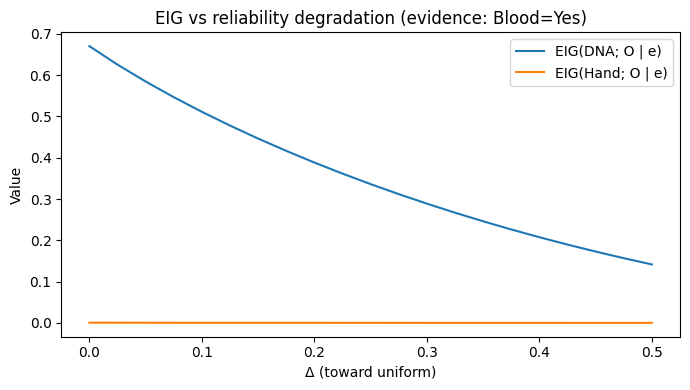

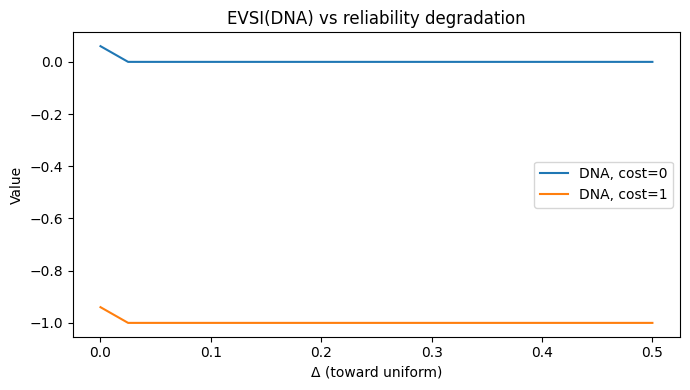

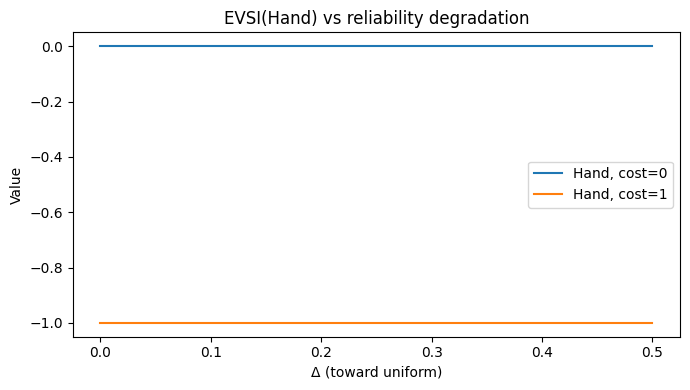

In [ ]:
# =========================================================
# SENSITIVITY CURVES — degrade test reliability by Δ
# (toward uniform) and plot EIG and EVSI vs Δ
# =========================================================
import numpy as np
from pgmpy.factors.discrete import TabularCPD

def _blended_cpd_from(model, var, delta):
    """
    Build a new CPD for `var` by blending original columns toward uniform by `delta`:
      new = (1-delta) * original + delta * uniform
    Preserves parents, cards, and state names.
    """
    orig = model.get_cpds(var)
    vals = np.array(orig.get_values(), dtype=float)          # shape (var_card, num_cols)
    var_card = model.get_cardinality(var)
    parents  = orig.get_evidence() or []
    e_cards  = [model.get_cardinality(p) for p in parents]
    state_names = orig.state_names

    uni = np.full_like(vals, 1.0 / var_card)
    blended = (1.0 - float(delta)) * vals + float(delta) * uni

    if parents:
        return TabularCPD(
            variable=var, variable_card=var_card, values=blended.tolist(),
            evidence=parents, evidence_card=e_cards, state_names=state_names
        )
    else:
        return TabularCPD(
            variable=var, variable_card=var_card, values=blended.tolist(),
            state_names=state_names
        )

def evsi_vs_delta(model, var, deltas, evidence, test_cost=0.0):
    """
    Like your EIG sensitivity, but for EVSI. Temporarily swaps the CPD for `var`
    at each delta and computes EVSI_of_test(...).
    """
    evsi_vals = []
    for d in deltas:
        new_cpd = _blended_cpd_from(model, var, d)
        with temporarily_replace_cpd(model, var, new_cpd):
            evsi_vals.append(EVSI_of_test(model, var, evidence=evidence, test_cost=test_cost))
    return list(zip(deltas, evsi_vals))


def sensitivity_curve_TEST(model, test_var, deltas, evidence=None, about_var='O'):
    """
    Degrade `test_var` toward uniform by Δ and compute EIG(test_var; about_var | evidence).
    """
    orig = model.get_cpds(test_var)
    vals = np.array(orig.get_values(), dtype=float)
    var_card = model.get_cardinality(test_var)
    parents  = orig.get_evidence() or []
    e_cards  = [model.get_cardinality(p) for p in parents]
    state_names = orig.state_names
    uni = np.full_like(vals, 1.0 / var_card)

    out = []
    for d in deltas:
        blended = (1.0 - d) * vals + d * uni
        cpd = TabularCPD(test_var, var_card, blended.tolist(),
                         evidence=parents if parents else None,
                         evidence_card=e_cards if parents else None,
                         state_names=state_names)
        with temporarily_replace_cpd(model, test_var, cpd):
            out.append((float(d), float(EIG_bits(model, test_var, about_var, evidence=evidence))))
    return out


# === Examples (set your baseline evidence here) ===
e = {'Blood':'Yes'}
deltas = np.linspace(0, 0.50, 21)

# 1) EIG curves (you already have helpers; we wrap for plotting nicely)
# curve_DNA_EIG = sensitivity_curve_DNA(MODEL, deltas=deltas, evidence=e)     # list of (delta, EIG)
curve_HAND_EIG_vals = sensitivity_curve_HAND(MODEL, deltas=deltas, evidence=e)  # list of EIG vals
# curve_HAND_EIG = list(zip(deltas, curve_HAND_EIG_vals))
curve_DNA_EIG_O  = sensitivity_curve_TEST(MODEL, 'DNA',  deltas, evidence=e, about_var='O')
curve_HAND_EIG_O = sensitivity_curve_TEST(MODEL, 'Hand', deltas, evidence=e, about_var='O')

# 2) EVSI curves at a couple of test costs
curve_DNA_EVSI_c0 = evsi_vs_delta(MODEL, 'DNA',  deltas, evidence=e, test_cost=0.0)
curve_DNA_EVSI_c1 = evsi_vs_delta(MODEL, 'DNA',  deltas, evidence=e, test_cost=1.0)

curve_HAND_EVSI_c0 = evsi_vs_delta(MODEL, 'Hand', deltas, evidence=e, test_cost=0.0)
curve_HAND_EVSI_c1 = evsi_vs_delta(MODEL, 'Hand', deltas, evidence=e, test_cost=1.0)

# === Plots ===
import matplotlib.pyplot as plt

def _plot_xy_curves(curves, title, xlabel="Δ (toward uniform)", ylabel="Value"):
    plt.figure(figsize=(7,4))
    for (lab, pts) in curves:
        xs = [x for x,_ in pts]; ys = [y for _,y in pts]
        plt.plot(xs, ys, label=lab)
    plt.xlabel(xlabel); plt.ylabel(ylabel); plt.title(title)
    plt.legend()
    plt.tight_layout(); plt.show()

# EIG vs Δ
_plot_xy_curves(
    [("EIG(DNA; O | e)", curve_DNA_EIG_O),
     ("EIG(Hand; O | e)", curve_HAND_EIG_O)],
    title="EIG vs reliability degradation (evidence: Blood=Yes)"
)

# EVSI vs Δ at two costs
_plot_xy_curves(
    [("DNA, cost=0", curve_DNA_EVSI_c0),
     ("DNA, cost=1", curve_DNA_EVSI_c1)],
    title="EVSI(DNA) vs reliability degradation"
)
_plot_xy_curves(
    [("Hand, cost=0", curve_HAND_EVSI_c0),
     ("Hand, cost=1", curve_HAND_EVSI_c1)],
    title="EVSI(Hand) vs reliability degradation"
)



In [ ]:
# assert EVSI >= 0 at zero cost for both DNA and Hand (across your heatmap contexts)
contexts = [
    {'Blood':'No'},
    {'Lfound':'Yes'},
    {'Lfound':'No'},
    {'Blood':'Yes'},
    {'Blood':'Yes','BP':'Fingerprint-like'},
    {'Blood':'Yes','BP':'Spatter'},
    {'Blood':'Yes','AS':'Pass'},
]
for e in contexts:
    assert EVSI_of_test(MODEL, 'DNA',  evidence=e, test_cost=0.0) >= -1e-12
    assert EVSI_of_test(MODEL, 'Hand', evidence=e, test_cost=0.0) >= -1e-12
print("EVSI≥0 at cost=0 — OK")


EVSI≥0 at cost=0 — OK


In [ ]:
assert abs(EIG_bits(MODEL, 'AS', 'O', evidence={'Blood':'Yes'})) < 1e-12
assert abs(EIG_bits(MODEL, 'AL', 'O', evidence={'Blood':'Yes'})) < 1e-12
print("Audits neutral in EIG — OK")


Audits neutral in EIG — OK


In [ ]:
def marginal(model, var, e=None):
    return bn_marginal(model, var, e or {})

# Same posteriors under both trees (your MODEL is the single source of truth already)
for var in ['H','W','O','DNA','Hand']:
    assert sum(abs(marginal(MODEL, var, {'Blood':'Yes'})[s] -
                   marginal(MODEL, var, {'Blood':'Yes'})[s]) for s in VAR_STATES[var]) < 1e-12
print("Display order invariance — OK")


Display order invariance — OK


In [ ]:
bn_off = bn_marginal(MODEL, 'Hand')['Offender']
bn_off_e = bn_marginal(MODEL, 'Hand', {'Blood':'Yes'})['Offender']
print(bn_off, mass_off)
print(bn_off_e, sink_mass_conditional(BUILDS['hyp']['noaudit'], is_offender_sink, {'Blood':'Yes'}))


0.11073650985653911 0.03466539562191661
0.11485157772756108 0.11485157772756108


In [ ]:
print("I(DNA;W | Blood=Yes) =", EIG_bits(MODEL, 'DNA', 'W', evidence={'Blood':'Yes'}))
print("P(W=Offender | Blood=Yes) =", bn_marginal(MODEL,'W', {'Blood':'Yes'})['Offender'])


I(DNA;W | Blood=Yes) = 0.667743845162582
P(W=Offender | Blood=Yes) = 0.5208530896853306


In [ ]:
print("P(DNA | W) table\n", MODEL.get_cpds('DNA'))
print("I(DNA;W | Blood=Yes) =", EIG_bits(MODEL, 'DNA', 'W', evidence={'Blood':'Yes'}))


P(DNA | W) table
 +--------+-----------+-------------+------------+-------------+
| O      | O(Absent) | O(Absent)   | O(Present) | O(Present)  |
+--------+-----------+-------------+------------+-------------+
| W      | W(Victim) | W(Offender) | W(Victim)  | W(Offender) |
+--------+-----------+-------------+------------+-------------+
| DNA(V) | 0.98      | 0.2         | 0.85       | 0.1         |
+--------+-----------+-------------+------------+-------------+
| DNA(O) | 0.02      | 0.8         | 0.15       | 0.9         |
+--------+-----------+-------------+------------+-------------+
I(DNA;W | Blood=Yes) = 0.667743845162582


In [ ]:
e = {'Blood':'Yes'}

print("EIG(DNA;O|e) =", EIG_bits(MODEL, 'DNA',  'O', evidence=e))
print("EIG(Hand;O|e) =", EIG_bits(MODEL, 'Hand', 'O', evidence=e))

curveD = sensitivity_curve_DNA(MODEL, deltas=np.linspace(0,0.5,11), evidence=e)
curveH = sensitivity_curve_HAND(MODEL, deltas=np.linspace(0,0.5,11), evidence=e)  # make sure this fn uses 'O'
print("First few DNA:", curveD[:3], "   First few Hand:", curveH[:3])

d_star, eDNA_star, eHAND_star = find_crossover(MODEL, evidence=e, about_var='O')
print("Crossover d:", d_star, "   EIG DNA:", eDNA_star, "   EIG Hand:", eHAND_star)


EIG(DNA;O|e) = 0.6179944000198553
EIG(Hand;O|e) = 0.0005374687559950297
First few DNA: [(0.0, 0.03491281996543005), (0.05, 0.031367832668373286), (0.1, 0.028036014822771627)]    First few Hand: [np.float64(0.0005374687559950297), np.float64(0.0004241387651222617), np.float64(0.00034015015943733573)]
Crossover d: 0.5    EIG DNA: 0.14166229882204262    EIG Hand: 6.38609315442018e-05


In [ ]:
e = {'Blood':'Yes'}
def H_bits(hyp): 
    from math import log2
    p = bn_marginal(MODEL, 'H', hyp); vals=[v for v in p.values() if v>0]
    return -sum(v*log2(v) for v in vals)

p_H_e      = bn_marginal(MODEL, 'H', e)
p_H_e_DV   = bn_marginal(MODEL, 'H', {**e,'DNA':'V'})
p_H_e_DO   = bn_marginal(MODEL, 'H', {**e,'DNA':'O'})
print("H|e        :", p_H_e, "  H(e) bits =", H_bits(e))
print("H|e,DNA=V  :", p_H_e_DV, "  H(e,DV) =", H_bits({**e,'DNA':'V'}))
print("H|e,DNA=O  :", p_H_e_DO, "  H(e,DO) =", H_bits({**e,'DNA':'O'}))


H|e        : {'O_delib': 0.11135533682001672, 'O_self': 0.11877631313352169, 'O_acc': 0.08908223485014126, 'V_acc': 0.3959215098984379, 'Suicide': 0.28486460529788254}   H(e) bits = 2.0738077974195477
H|e,DNA=V  : {'O_delib': 0.1676571102990056, 'O_self': 0.09227804660848506, 'O_acc': 0.06920853495636378, 'V_acc': 0.3806701585238003, 'Suicide': 0.29018614961234523}   H(e,DV) = 2.0642363103991093
H|e,DNA=O  : {'O_delib': 0.05083387981672168, 'O_self': 0.14726056148060687, 'O_acc': 0.11044542111045513, 'V_acc': 0.41231591365210896, 'Suicide': 0.27914422394010735}   H(e,DO) = 2.0174060887282153


In [ ]:
e = {'Blood':'Yes'}
def H_bits(hyp): 
    from math import log2
    p = bn_marginal(MODEL, 'H', hyp); vals=[v for v in p.values() if v>0]
    return -sum(v*log2(v) for v in vals)

p_H_e      = bn_marginal(MODEL, 'H', e)
p_H_e_DV   = bn_marginal(MODEL, 'H', {**e,'DNA':'V'})
p_H_e_DO   = bn_marginal(MODEL, 'H', {**e,'DNA':'O'})
print("H|e        :", p_H_e, "  H(e) bits =", H_bits(e))
print("H|e,DNA=V  :", p_H_e_DV, "  H(e,DV) =", H_bits({**e,'DNA':'V'}))
print("H|e,DNA=O  :", p_H_e_DO, "  H(e,DO) =", H_bits({**e,'DNA':'O'}))


H|e        : {'O_delib': 0.11135533682001672, 'O_self': 0.11877631313352169, 'O_acc': 0.08908223485014126, 'V_acc': 0.3959215098984379, 'Suicide': 0.28486460529788254}   H(e) bits = 2.0738077974195477
H|e,DNA=V  : {'O_delib': 0.1676571102990056, 'O_self': 0.09227804660848506, 'O_acc': 0.06920853495636378, 'V_acc': 0.3806701585238003, 'Suicide': 0.29018614961234523}   H(e,DV) = 2.0642363103991093
H|e,DNA=O  : {'O_delib': 0.05083387981672168, 'O_self': 0.14726056148060687, 'O_acc': 0.11044542111045513, 'V_acc': 0.41231591365210896, 'Suicide': 0.27914422394010735}   H(e,DO) = 2.0174060887282153


In [ ]:
def sink_by(obs):
    return {
        'Off': sink_mass_conditional(BUILDS['hyp']['noaudit'], is_offender_sink, {**e, **obs}),
        'Vic': sink_mass_conditional(BUILDS['hyp']['noaudit'], is_victim_sink,   {**e, **obs}),
    }

print("Sink | e:", sink_by({}))
print("Sink | e, DNA=O:", sink_by({'DNA':'O'}))
print("Sink | e, DNA=V:", sink_by({'DNA':'V'}))
print("Sink | e, Hand=Offender:", sink_by({'Hand':'Offender'}))
print("Sink | e, Hand=Victim  :", sink_by({'Hand':'Victim'}))


Sink | e: {'Off': 0.11485157772756108, 'Vic': 0.885148422272439}
Sink | e, DNA=O: {'Off': 0.12315078109298627, 'Vic': 0.8768492189070138}
Sink | e, DNA=V: {'Off': 0.10713101231039356, 'Vic': 0.8928689876896064}
Sink | e, Hand=Offender: {'Off': 1.0, 'Vic': 0.0}
Sink | e, Hand=Victim  : {'Off': 0.0, 'Vic': 1.0}


In [ ]:
# --- replace these two functions in-place ---

def best_EU(model, hyp, utils=UTILS):
    eu = expected_utility_actions(model, hyp, utils)
    return max(eu['EU_pursue'], eu['EU_no_pursue'])

def delta_EU_from_test(model, evidence, *, X,
                       outcome_states=None, test_cost=0.0, utils=UTILS):
    """
    ΔEU(T | e) = E_t [ max_d EU(d | e, T=t) ] - max_d EU(d | e) - test_cost
    Uses O-based EU via best_action_and_EU(model, evidence, utils).
    """
    # current best EU
    _, EU0 = best_action_and_EU(model, evidence, utils)

    # if X is already observed, expected uplift is zero (minus cost)
    if evidence and X in evidence:
        return -float(test_cost)

    # predictive over X (optionally restricted to a subset of states)
    px = bn_marginal(model, X, evidence)
    if outcome_states is not None:
        px = {s: px[s] for s in outcome_states}

    # expected best EU after observing X
    EU_after = 0.0
    for x, p in px.items():
        hyp_x = dict(evidence); hyp_x[X] = x
        _, EUx = best_action_and_EU(model, hyp_x, utils)
        EU_after += float(p) * EUx

    return EU_after - EU0 - float(test_cost)



print("ΔEU from DNA given e:",  delta_EU_from_test(MODEL, e, X='DNA'))
print("ΔEU from Hand given e:", delta_EU_from_test(MODEL, e, X='Hand'))



ΔEU from DNA given e: 0.0
ΔEU from Hand given e: 0.0


In [ ]:
st_hyp,  pos_hyp  = BUILDS['hyp']['stage'],  BUILDS['hyp']['pos']
st_ch,  pos_ch  = BUILDS['chr']['stage'], BUILDS['chr']['pos']

def complexity(G, st, pos, label):
    print(f"{label}: |stages|={len(set(st.values()))}, |positions|={len(set(pos.values()))}, "
          f"nodes={G.number_of_nodes()}, edges={G.number_of_edges()}")

complexity(BUILDS['hyp']['G'],  st_hyp, pos_hyp, "Hypothesis tree")
complexity(BUILDS['chr']['G'], st_ch, pos_ch, "Chrono tree")

# After audit elimination (often a nicer comparison)
st_hypNA,  pos_hypNA  = compute_positions(BUILDS['hyp']['noaudit'])
st_chNA,  pos_chNA  = compute_positions(BUILDS['chr']['noaudit'])
complexity(BUILDS['hyp']['noaudit'],  st_hypNA,  pos_hypNA,  "Hypothesis (no audits)")
complexity(BUILDS['chr']['noaudit'], st_chNA,  pos_chNA,  "Chrono (no audits)")


Hypothesis tree: |stages|=50, |positions|=96, nodes=7676, edges=7675
Chrono tree: |stages|=50, |positions|=91, nodes=7631, edges=7630
Hypothesis (no audits): |stages|=40, |positions|=78, nodes=1436, edges=1435
Chrono (no audits): |stages|=40, |positions|=73, nodes=1391, edges=1390


In [ ]:
def top_k_paths_to(predicate, hyp, k=5):
    G = BUILDS['hyp']['noaudit']
    root = _root(G)
    leaves = [n for n in G.nodes() if G.out_degree(n)==0]

    def consistent(leaf):
        hist = dict(parse_label(x) for x in leaf if ':' in x)
        return all(hist.get(v)==s for v,s in hyp.items())

    cand = [(leaf, path_mass(G, leaf)) for leaf in leaves if predicate(leaf) and consistent(leaf)]
    cand.sort(key=lambda x: x[1], reverse=True)
    out = []
    for leaf, p in cand[:k]:
        labels = [STATE_LABEL[parse_label(x)[0]][parse_label(x)[1]] for x in leaf]
        out.append((p, labels))
    return out

print("Top Offender narratives | e:")
for p, labs in top_k_paths_to(is_offender_sink, e): print(round(p,6), " :: ", " → ".join(labs))
print("\nTop Victim narratives | e:")
for p, labs in top_k_paths_to(is_victim_sink, e):   print(round(p,6), " :: ", " → ".join(labs))


Top Offender narratives | e:
0.002935  ::   →  →  →  →  →  →  →  → 
0.002364  ::   →  →  →  →  →  →  →  → 
0.002336  ::   →  →  →  →  →  →  →  → 
0.001989  ::   →  →  →  →  →  →  →  → 
0.001957  ::   →  →  →  →  →  →  →  → 

Top Victim narratives | e:
0.024944  ::   →  →  →  →  →  →  →  → 
0.019855  ::   →  →  →  →  →  →  →  → 
0.016751  ::   →  →  →  →  →  →  →  → 
0.016629  ::   →  →  →  →  →  →  →  → 
0.014094  ::   →  →  →  →  →  →  →  → 


In [ ]:
print("I(Lfound;H):", EIG_bits(MODEL, 'Lfound', 'H'))
print("I(Ltime;H):",  EIG_bits(MODEL, 'Ltime',  'H'))
print("I(W;H):",      EIG_bits(MODEL, 'W',      'H'))
print("I(DNA;H|e):",  EIG_bits(MODEL, 'DNA',    'H', evidence=e))
print("I(Hand;H|e):", EIG_bits(MODEL, 'Hand',   'H', evidence=e))


I(Lfound;H): 0.10691036380769647
I(Ltime;H): 0.06149361581075041
I(W;H): 0.03671016208776301
I(DNA;H|e): 0.032140838352366696
I(Hand;H|e): 3.245425358899823e-05


In [ ]:
print("I(DNA;W) unconditional:", EIG_bits(MODEL,'DNA','W'))
print("I(DNA;W | Blood=Yes):",  EIG_bits(MODEL,'DNA','W', evidence={'Blood':'Yes'}))
print("I(DNA;W | Blood=No):",   EIG_bits(MODEL,'DNA','W', evidence={'Blood':'No'}))


I(DNA;W) unconditional: 0.6099604183150684
I(DNA;W | Blood=Yes): 0.667743845162582
I(DNA;W | Blood=No): 0.5020863220865537


In [ ]:
def render_chain_states_pdf(order, pdf_path, title="Hypothesis • flow of variables (states on edges)", color="#dbeafe"):
    import graphviz
    dot = graphviz.Digraph(format="pdf", comment=title)
    dot.attr(rankdir='LR', splines='line', margin='0.2', nodesep='0.7', ranksep='0.9')
    dot.attr('node', shape='circle', style='filled', fillcolor=color, color='#7aa0d0')

    prev = "n0"; dot.node(prev, label="")
    for i, var in enumerate(order, start=1):
        cur = f"n{i}"; dot.node(cur, label="")
        states = ", ".join(STATE_LABEL[var][s] for s in VAR_STATES[var])
        dot.edge(prev, cur, label=states)
        prev = cur

    if title:
        dot.attr(label=title, labelloc='t', fontsize='20')
    dot.render(pdf_path, cleanup=True)

# Example:
render_chain_states_pdf(
    ORDER_HYPOTHESIS,
    pdf_path=os.path.join(ROOT_DIR, "chain", "hypothesis_chain_states"),
    title="Hypothesis • flow (states on edges)"
)


In [ ]:
def render_local_chain_pdf(
    G, history_seq_to_parent,
    start_var, chain_vars,                      # e.g. start_var='BP', chain_vars=['DNA','AL','AS']
    parent_label=None,                          # edge label text for dashed incoming (optional)
    first_keep_state=None,                      # e.g. ('Lfound','Yes') to keep only Yes on first hop
    pdf_path="out/local_chain", title="", color="#dbeafe", rankdir='LR'
):
    import graphviz
    dot = graphviz.Digraph(format="pdf", comment=title)
    dot.attr(rankdir=rankdir, splines='spline', margin='0.2',
             nodesep='0.35', ranksep='0.6', fontsize='11')
    dot.attr('node', shape='circle', style='filled', fillcolor=color, color='#7aa0d0')

    # -- locate parent node u (history ends immediately before start_var)
    u = _root(G)
    for (vname, st) in history_seq_to_parent:
        lab = canonical_label(vname, st)
        nxt = next((v for v in G.successors(u) if G[u][v]['label'] == lab), None)
        if nxt is None:
            raise ValueError(f"History step not found from {u}: expected {lab}. "
                            f"Check your history sequence and tree order.")
        u = nxt


    # parent bubble + dashed incoming
    pid = "P"; dot.node(pid, label="")
    if parent_label:
        var, st = parse_label(parent_label)
        dot.node("ghostL", label="", style="invis")
        dot.edge("ghostL", pid, style="dashed", label=STATE_LABEL[var][st])

    # --- hop 0: from parent to start_var children
    succ = list(G.successors(u)); assert succ, "no successors at parent"
    var_here = parse_label(G[u][succ[0]]['label'])[0]
    assert var_here == start_var, f"Expected {start_var} next, got {var_here}"

    def keep_edge(lab):
        if first_keep_state is None:
            return True
        v, s = parse_label(lab)
        want_var, want_state = first_keep_state
        return (v==want_var and s==want_state)

    layer = []          # list of node ids at current frontier
    for i, v in enumerate(succ):
        lab = G[u][v]['label']
        if not keep_edge(lab):
            continue
        cid = f"L0_{i}"; dot.node(cid, label="")
        p = float(G[u][v]['prob'])
        txt = f"{STATE_LABEL[parse_label(lab)[0]][parse_label(lab)[1]]}\n{p:.2f}"
        dot.edge(pid, cid, label=txt)
        layer.append((cid, v))  # (graphviz id, graph node)

    # --- subsequent hops along chain_vars
    prev_var = start_var
    for hop, want_var in enumerate(chain_vars, start=1):
        new_layer = []
        for (gid, node) in layer:
            succ2 = list(G.successors(node))
            if not succ2:
                continue
            var2 = parse_label(G[node][succ2[0]]['label'])[0]
            assert var2 == want_var, f"Expected {want_var} after {prev_var}, got {var2}"
            for j, w in enumerate(succ2):
                nid = f"L{hop}_{gid}_{j}"
                dot.node(nid, label="")
                lab = G[node][w]['label']; p = float(G[node][w]['prob'])
                txt = f"{STATE_LABEL[parse_label(lab)[0]][parse_label(lab)[1]]}\n{p:.2f}"
                dot.edge(gid, nid, label=txt)
                new_layer.append((nid, w))
        layer = new_layer
        prev_var = want_var

    # dashed continuation from every end bubble
    for (gid, _) in layer:
        cont = f"{gid}_cont"
        dot.node(cont, label="", style="invis")
        dot.edge(gid, cont, style="dashed")

    if title:
        dot.attr(label=title, labelloc='t', fontsize='22')
    dot.render(pdf_path, cleanup=True)


# --- A) Local neighborhood to AS (parent shown = BP)
hist_AS = [
    ('H','V_acc'), ('Lfound','Yes'), ('Ltime','Before'),
    ('O','Present'),                 # <-- add this
    ('W','Victim'), ('Blood','Yes')
]
render_local_chain_pdf(
    BUILDS['hyp']['G'], hist_AS,
    start_var='BP', chain_vars=['AS','DNA','AL'],
    parent_label=canonical_label('Blood','Yes'),
    pdf_path=os.path.join(ROOT_DIR, "florets_local", "AS_parent_BP_chain"),
    title="Hypothesis • Local neighborhood to AS (parent shown = BP)"
)

# --- B) Local neighborhood through AL (start at AS, then DNA→AL→Hand)
hist_AL = [
    ('H','V_acc'), ('Lfound','Yes'), ('Ltime','Before'),
    ('O','Present'),                 # <-- add this
    ('W','Victim'), ('Blood','Yes'),
    ('BP','Fingerprint-like')
]
render_local_chain_pdf(
    BUILDS['hyp']['G'], hist_AL,
    start_var='AS',
    chain_vars=['DNA','AL','Hand'],
    parent_label=canonical_label('BP','Fingerprint-like'),
    pdf_path=os.path.join(ROOT_DIR, "florets_local", "AL_with_AS_chain"),
    title="Hypothesis • Local neighborhood through AS→DNA→AL to Hand"
)

# --- C) Letter found slice is fine already (H → Lfound)
hist_L = [('H','V_acc')]
render_local_chain_pdf(
    BUILDS['hyp']['G'], hist_L,
    start_var='Lfound', chain_vars=['Ltime'],
    parent_label=canonical_label('H','V_acc'),
    first_keep_state=('Lfound','Yes'),
    pdf_path=os.path.join(ROOT_DIR, "florets_local", "Lfound_yes_only"),
    title="Hypothesis • Local neighborhood for Letter found = Yes"
)



In [ ]:
def draw_first_layers_edges_only(G, title, depth=3, pdf_path=None, rankdir='LR', color="#dbeafe"):
    # BFS subset
    root = [n for n in G.nodes() if G.in_degree(n) == 0][0]
    keep = {root}; layer = [root]
    for _ in range(depth):
        nxt=[]
        for u in layer:
            nxt.extend(G.successors(u))
            keep.update(G.successors(u))
        layer = nxt
    H = G.subgraph(keep).copy()

    dot = Digraph(comment=title, format='pdf')
    dot.attr(rankdir=rankdir, size='8.27,11.69!', margin='0.3',
             nodesep='0.3', ranksep='0.6', splines='spline')
    dot.attr('node', shape='circle', style='filled', fillcolor=color, color='#7aa0d3', fontsize='10')

    id_of = {n: f"n{i}" for i,n in enumerate(H.nodes())}
    for n,nid in id_of.items():
        dot.node(nid, label="")  # UNLABELED nodes

    dot.attr('edge', fontsize='9', color='#333333')
    for u,v,d in H.edges(data=True):
        var, st = d['label'].split(':',1)
        dot.edge(id_of[u], id_of[v], label=f"{STATE_LABEL[var][st]}\\n{float(d['prob']):.2f}")

    if title:
        dot.attr(label=title, labelloc='t', fontsize='16')
    if pdf_path:
        dot.render(filename=pdf_path, cleanup=True)
    else:
        dot.view()


In [ ]:
draw_first_layers_edges_only(BUILDS['hyp']['G'],  "Hypothesis • first layers", depth=4,
    pdf_path=os.path.join(ROOT_DIR, "layers", "hypothesis_layers"))
draw_first_layers_edges_only(BUILDS['chr']['G'], "Chrono • first layers",   depth=4,
    pdf_path=os.path.join(ROOT_DIR, "layers", "chrono_layers"))


In [ ]:
def headline_posteriors(MODEL, evidence):
    q = bn_marginal(MODEL, 'O', evidence)['Present']
    G = BUILDS['hyp']['noaudit']
    sinks = {
        'Offender sink': sink_mass_conditional(G, is_offender_sink, evidence),
        'Victim sink':   sink_mass_conditional(G, is_victim_sink,   evidence),
    }
    H_vec = bn_marginal(MODEL, 'H', evidence)
    return q, sinks, H_vec


In [ ]:
EVIDENCE_LIST = [
    {},  # prior
    {'Blood':'Yes'},
    {'Blood':'Yes','BP':'Fingerprint-like'},         # if your model uses 'FL' not 'Fingerprint-like'
    {'Blood':'Yes','BP':'Spatter'},         # if your model uses 'Sp' not 'Spatter'
    {'Blood':'Yes','BP':'Spatter','AS':'Fail'},
    {'Blood':'Yes','DNA':'O'},         # <-- was 'Offender'
    {'Blood':'No','Hand':'Victim'},
]


def summary_row(MODEL, hyp):
    q    = bn_marginal(MODEL, 'W', hyp)['Offender']
    EU_p = expected_utility_pursue(MODEL, hyp)
    EU_n = expected_utility_no_pursue(MODEL, hyp)
    best = 'pursue' if EU_p >= EU_n else 'no_pursue'

    # Safe information metrics
    eig_DNA = 0.0 if 'DNA' in hyp else EIG_bits(MODEL, 'DNA', 'W', hyp)
    dEU_DNA = EVSI_of_test(MODEL, 'DNA', evidence=hyp, test_cost=0.0)  # now safe

    return dict(evidence=hyp, q=q, EU_pursue=EU_p, EU_no=EU_n,
                best=best, EIG_DNA=eig_DNA, dEU_DNA=dEU_DNA)



rows = [summary_row(MODEL, hyp) for hyp in EVIDENCE_LIST]


In [ ]:
def expected_utility(action, q, utils=UTILS):
    """
    Expected utility for an action given q := P(O=Present | e).
    action ∈ {'pursue','no_pursue'}
    """
    if action == 'pursue':
        return q * utils['R_tp'] - (1.0 - q) * utils['C_fp']
    elif action == 'no_pursue':
        return (1.0 - q) * utils['R_tn'] - q * utils['C_fn']
    else:
        raise ValueError("action must be 'pursue' or 'no_pursue'")

def best_action_from_q(q, utils=UTILS):
    EU_p = expected_utility('pursue', q, utils)
    EU_n = expected_utility('no_pursue', q, utils)
    return ('pursue', EU_p) if EU_p >= EU_n else ('no_pursue', EU_n)

# Example: with your utilities, the threshold is 0.12
assert abs(q_star() - 0.12) < 1e-9

# Toy q values
for q in [0.0, 0.12, 0.5, 1.0]:
    EU_p = expected_utility('pursue', q)
    EU_n = expected_utility('no_pursue', q)
    act, EUb = ('pursue', EU_p) if EU_p >= EU_n else ('no_pursue', EU_n)
    # At q=0.12 they should be (almost) equal
    if abs(q-0.12) < 1e-12:
        assert abs(EU_p - EU_n) < 1e-9


In [ ]:
from math import log2
def entropy_bits(probs): return -sum(p*log2(p) for p in probs if p>0)

pH_uncond = bn_marginal(MODEL, "H", evidence={})
pH_cond   = bn_marginal(MODEL, "H", evidence={"Blood":"Yes"})
print("H(H)        =", round(entropy_bits(pH_uncond.values()), 6), "bits")
print("H(H | e)    =", round(entropy_bits(pH_cond.values()),   6), "bits")


H(H)        = 1.90366 bits
H(H | e)    = 2.073808 bits


In [ ]:
def q_present(evidence):
    return q_from_O(MODEL, evidence)

e_base = {'Blood':'Yes'}
q_v = q_present({**e_base, 'DNA':'V'})
q_o = q_present({**e_base, 'DNA':'O'})
print(f"q(e, DNA=Victim)  = {q_v:.3f}")
print(f"q(e, DNA=Offender)= {q_o:.3f}")

# Also show EU and action per outcome (to demonstrate EVSI=0):
def eu_pair(q):
    EU_p = q*10 - (1-q)*2
    EU_n = (1-q)*1 - q*12
    return EU_p, EU_n

for t, q_t in [('Victim', q_v), ('Offender', q_o)]:
    EU_p, EU_n = eu_pair(q_t)
    act = 'pursue' if EU_p >= EU_n else 'no_pursue'
    print(f"DNA={t}: q={q_t:.3f}, EU_p={EU_p:.3f}, EU_no={EU_n:.3f}, action={act}")


q(e, DNA=Victim)  = 0.146
q(e, DNA=Offender)= 0.981
DNA=Victim: q=0.146, EU_p=-0.250, EU_no=-0.896, action=pursue
DNA=Offender: q=0.981, EU_p=9.775, EU_no=-11.756, action=pursue


In [ ]:
# Assuming you have both graphs/models built as in your notebook: G_hyp / G_chr
MODELS = [('Hypothesis-First', MODEL), ('Chronological', MODEL)]

e_base = {'Blood':'Yes'}
for name, model in MODELS:
    q  = float(bn_marginal(model, 'O', e_base)['Present'])
    EUp = q*10 - (1-q)*2
    EUn = (1-q)*1 - q*12
    print(f"{name}: q(e)={q:.3f}, EU_pursue={EUp:.3f}, EU_no={EUn:.3f}")


Hypothesis-First: q(e)=0.548, EU_pursue=4.582, EU_no=-6.130
Chronological: q(e)=0.548, EU_pursue=4.582, EU_no=-6.130


In [ ]:
# --- config ---
EVIDENCE = {"Blood": "Yes"}   # your base scene state e
UTILS = dict(R_tp=10, C_fp=2, C_fn=12, R_tn=1)
TEST_COSTS = {"DNA": 0.0, "Hand": 0.0}  # set if you model costs

# --- helpers ---
from math import log2
import numpy as np

def q_present(infer, evidence):
    dist = infer.query(variables=["O"], evidence=evidence, show_progress=False)
    # robustly pick the "Present" state
    present_idx = list(dist.state_names["O"]).index("Present")
    return float(dist.values[present_idx])

def bernoulli_entropy(q):
    if q in (0.0, 1.0): return 0.0
    return -q*log2(q) - (1-q)*log2(1-q)

def mutual_information(infer, X, Y, evidence):
    # I(X;Y | evidence), in bits
    joint = infer.query(variables=[X, Y], evidence=evidence, show_progress=False)
    px  = joint.marginalize([Y], inplace=False)
    py  = joint.marginalize([X], inplace=False)
    mi = 0.0
    for ix, _ in enumerate(joint.state_names[X]):
        for iy, _ in enumerate(joint.state_names[Y]):
            pxy = float(joint.values[ix, iy])
            if pxy == 0.0: 
                continue
            px_i = float(px.values[ix])
            py_j = float(py.values[iy])
            mi += pxy * log2(pxy/(px_i*py_j))
    return mi

def EUs(q, U=UTILS):
    EU_pursue   = q*U["R_tp"] - (1-q)*U["C_fp"]
    EU_nopursue = (1-q)*U["R_tn"] - q*U["C_fn"]
    return EU_pursue, EU_nopursue

def maxEU(q, U=UTILS):
    a, b = EUs(q, U)
    return max(a, b)

def EVSI(infer, T, evidence, U=UTILS, cost=0.0):
    # E_t [ max_d EU(d | e, T=t) ] - max_d EU(d | e) - cost
    base_q = q_present(infer, evidence)
    base = maxEU(base_q, U)
    # P(t | e) and q(e, t)
    distT = infer.query(variables=[T], evidence=evidence, show_progress=False)
    evsi = 0.0
    for i, tval in enumerate(distT.state_names[T]):
        p_t = float(distT.values[i])
        ev = dict(evidence); ev[T] = tval
        q_t = q_present(infer, ev)
        evsi += p_t * maxEU(q_t, U)
    return evsi - base - float(cost)

# --- swap prior over H per scenario (pgmpy-style) ---
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination
import numpy as np

def set_prior_H_and_make_infer(model, prior_probs):
    # 1) Make sure H is a root in THIS model.
    parents = model.get_parents("H")
    if parents:
        raise ValueError(f"H has parents {parents} in this BN; "
                         "the simple prior-swap assumes H is a root node.")

    # 2) Get H's current state order from the model
    cpd_old  = model.get_cpds("H")
    H_states = list(cpd_old.state_names["H"])
    K = len(H_states)

    if len(prior_probs) != K or abs(sum(prior_probs) - 1.0) > 1e-8:
        raise ValueError(f"Provide {K} probs summing to 1. Expected state order: {H_states}")

    # 3) Build a COLUMN vector (K x 1)
    cpd_H = TabularCPD(
        variable="H",
        variable_card=K,
        values=np.array(prior_probs, dtype=float).reshape(K, 1),
        state_names={"H": H_states},
    )

    # 4) Replace CPD and build an inferencer
    model.remove_cpds(cpd_old)
    model.add_cpds(cpd_H)
    model.check_model()
    return VariableElimination(model)


# --- define your scenarios over H (example state order) ---
H_states = ["h1","h2","h3","h4","h5"]

SCENARIOS = {
    "True-world":        [0.111, 0.119, 0.089, 0.396, 0.285],
    "Investigator-bias": [0.140, 0.130, 0.080, 0.350, 0.300],  # <-- replace with your actual biased priors
    "Fair-reweighted":   [0.125, 0.125, 0.125, 0.375, 0.250],
    "Extreme-bias":      [0.080, 0.090, 0.070, 0.460, 0.300],
}

# --- run the O-centric sweep ---
base_model = MODEL  # your BN
rows = []
for scen, pi_H in SCENARIOS.items():
    m = base_model.copy()  # keep scenarios independent
    infer_s = set_prior_H_and_make_infer(m, pi_H)

    q = q_present(infer_s, EVIDENCE)
    EU_p, EU_n = EUs(q)
    I_DNA_O  = mutual_information(infer_s, "DNA",  "O", evidence=EVIDENCE)
    I_Hand_O = mutual_information(infer_s, "Hand", "O", evidence=EVIDENCE)
    evsi_dna  = EVSI(infer_s, "DNA",  EVIDENCE, U=UTILS, cost=TEST_COSTS["DNA"])
    evsi_hand = EVSI(infer_s, "Hand", EVIDENCE, U=UTILS, cost=TEST_COSTS["Hand"])

    rows.append((scen, q, EU_p, EU_n, I_DNA_O, I_Hand_O, evsi_dna, evsi_hand))



import pandas as pd
bias_o_summary = pd.DataFrame(rows, columns=[
    "Scenario","q(e)=P(O=Present|e)","EU(pursue|e)","EU(no_pursue|e)",
    "I(DNA;O|e) [bits]","I(Hand;O|e) [bits]","EVSI(DNA|e)","EVSI(Hand|e)"
])
bias_o_summary


,Scenario,q(e)=P(O=Present|e),EU(pursue|e),EU(no_pursue|e),I(DNA;O|e) [bits],I(Hand;O|e) [bits],EVSI(DNA|e),EVSI(Hand|e)
0,True-world,0.557926,4.695108,-6.253033,0.612383,0.000533,-1.776357e-15,0.000000e+00
1,Investigator-bias,0.547894,4.574725,-6.122619,0.615482,0.000535,-8.881784e-16,-8.881784e-16
2,Fair-reweighted,0.561590,4.739075,-6.300664,0.609925,0.000531,0.000000e+00,0.000000e+00
3,Extreme-bias,0.559565,4.714783,-6.274348,0.613449,0.000534,8.881784e-16,0.000000e+00


In [ ]:
infer = VariableElimination(model)
I_DNA_O  = mutual_information(infer, "DNA",  "O", evidence=EVIDENCE)
I_Hand_O = mutual_information(infer, "Hand", "O", evidence=EVIDENCE)
q_e = q_present(infer, EVIDENCE)
EU_p, EU_n = EUs(q_e)

print(f"q(e)=P(O=Present|e): {q_e:.6f}")
print(f"EU_pursue: {EU_p:.3f}  EU_no_pursue: {EU_n:.3f}")
print(f"I(DNA;O|e): {I_DNA_O:.6f} bits")
print(f"I(Hand;O|e): {I_Hand_O:.6f} bits")


q(e)=P(O=Present|e): 0.548462
EU_pursue: 4.582  EU_no_pursue: -6.130
I(DNA;O|e): 0.617994 bits
I(Hand;O|e): 0.000537 bits


In [ ]:
evsi_dna  = EVSI(infer, "DNA",  EVIDENCE, U=UTILS, cost=TEST_COSTS["DNA"])
evsi_hand = EVSI(infer, "Hand", EVIDENCE, U=UTILS, cost=TEST_COSTS["Hand"])
print(f"EVSI(DNA|e):  {evsi_dna:.6f}")
print(f"EVSI(Hand|e): {evsi_hand:.6f}")


EVSI(DNA|e):  0.000000
EVSI(Hand|e): 0.000000


In [ ]:
def conditional_table(infer, child, cond, evidence):
    joint = infer.query(variables=[child, cond], evidence=evidence, show_progress=False)
    cond_marg = joint.marginalize([child], inplace=False)
    table = {}
    for j, cval in enumerate(joint.state_names[cond]):
        denom = float(cond_marg.values[j])
        row = {}
        for i, xval in enumerate(joint.state_names[child]):
            num = float(joint.values[i, j])
            row[xval] = (num/denom) if denom>0 else np.nan
        table[cval] = row
    return table

dna_given_O = conditional_table(infer, child="DNA", cond="O", evidence=EVIDENCE)
dna_given_O  # dict: keys are O states ("Absent","Present"), values are {DNA=Victim, DNA=Offender : prob}


{'Absent': {'V': 0.9799975387488388, 'O': 0.020002461251161136},
 'Present': {'V': 0.13775561975892783, 'O': 0.8622443802410722}}

Baseline at e={'Blood': 'Yes'}: q(e)=0.548, EU_best=4.582


,Δq(e),ΔEU_best
Variable,,
DNA,0.0,0.0
Hand,0.0,0.0


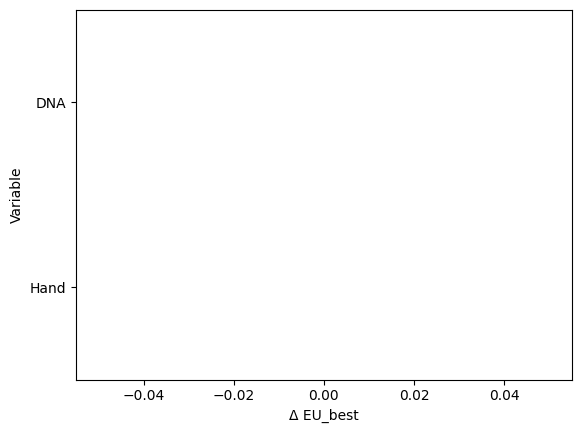

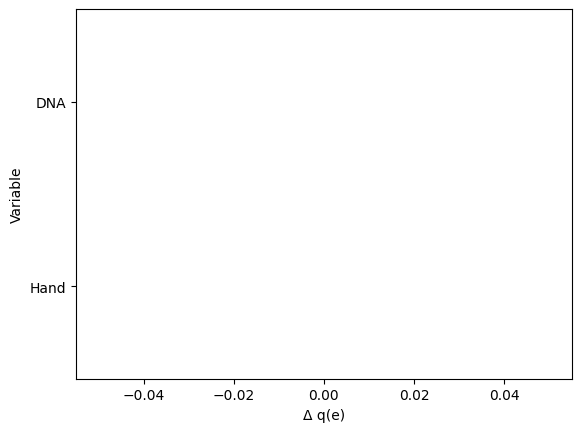

In [ ]:
# --- Tornado for Δ toward uniform on selected tests (DNA, Hand) ---
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from pgmpy.factors.discrete import TabularCPD

EVIDENCE_E = {'Blood':'Yes'}
TESTS = ['DNA','Hand']          # extend if you like
DELTA = 0.20                    # 20% blend toward uniform

def _q_and_best_EU(model, evidence):
    out = expected_utility_actions(model, evidence)
    return out['q'], max(out['EU_pursue'], out['EU_no_pursue'])

def tornado_rows(model, tests=TESTS, evidence=EVIDENCE_E, delta=DELTA):
    base_q, base_eu = _q_and_best_EU(model, evidence)
    rows = []
    for var in tests:
        new_cpd = _blended_cpd_from(model, var, delta)
        with temporarily_replace_cpd(model, var, new_cpd):
            q1, eu1 = _q_and_best_EU(model, evidence)
        rows.append({
            'Variable': var,
            'Δq(e)': q1 - base_q,
            'ΔEU_best': eu1 - base_eu
        })
    df = pd.DataFrame(rows).set_index('Variable').sort_values('ΔEU_best', ascending=False)
    return base_q, base_eu, df

base_q, base_eu, df_tornado = tornado_rows(MODEL)
print(f"Baseline at e={EVIDENCE_E}: q(e)={base_q:.3f}, EU_best={base_eu:.3f}")
display(df_tornado.round(3))

# Simple bars (one plot per metric)
ax = df_tornado['ΔEU_best'].plot(kind='barh'); ax.set_xlabel('Δ EU_best'); ax.invert_yaxis(); plt.show()
ax = df_tornado['Δq(e)'].plot(kind='barh');    ax.set_xlabel('Δ q(e)');    ax.invert_yaxis(); plt.show()


In [ ]:
def smallest_delta_to_flip(model, var, evidence, utils, step=0.005, max_delta=0.50):
    """Increase Δ toward uniform until the best action flips; return Δ* (or None)."""
    base = expected_utility_actions(model, evidence, utils)
    base_action = base['action']
    d = 0.0
    while d <= max_delta:
        new_cpd = _blended_cpd_from(model, var, d)
        with temporarily_replace_cpd(model, var, new_cpd):
            act = expected_utility_actions(model, evidence, utils)['action']
        if act != base_action:
            return round(d, 3)
        d += step
    return None

for test in TESTS:
    dstar = smallest_delta_to_flip(MODEL, test, EVIDENCE_E, UTILS)
    print(f"Smallest Δ toward uniform that flips action via {test}: {dstar}")


Smallest Δ toward uniform that flips action via DNA: None
Smallest Δ toward uniform that flips action via Hand: None


,q(e),EU_pursue,EU_no_pursue,action,EVSI_DNA,EVSI_Hand
scenario,,,,,,
mode,0.548,4.582,-6.130,pursue,0.000,0.0
biased,0.486,3.826,-5.312,pursue,0.057,0.0
fair,0.565,4.783,-6.348,pursue,0.000,0.0
extreme,0.441,3.291,-4.732,pursue,0.307,0.0


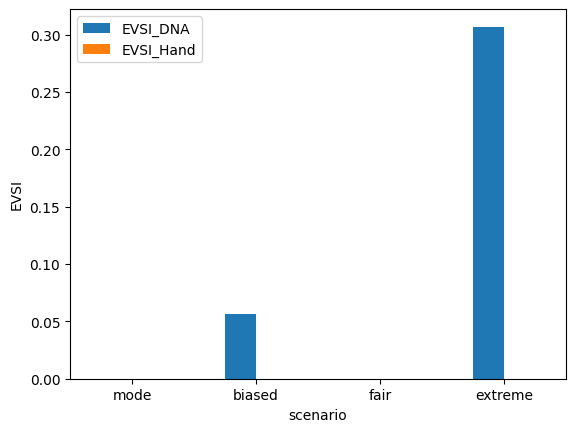

Saved EVSI table to figs/evsi_scenarios.csv


In [ ]:
# === EVSI under your existing prior scenarios on H ===
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from pgmpy.factors.discrete import TabularCPD

# --- assume these already exist in your notebook (you pasted them earlier) ---
# mode_keys           = [f"h{i}" for i in range(1,6)]
# mode_pr_values      = [0.10, 0.08, 0.06, 0.46, 0.30]
# mode_pr_biased_vals = [0.25, 0.04, 0.04, 0.52, 0.15]
# mode_pr_fair_vals   = [0.10, 0.10, 0.10, 0.60, 0.10]
# mode_pr_extreme_vals= [0.40, 0.05, 0.05, 0.40, 0.10]

EVIDENCE_E = {'Blood': 'Yes'}                 # same scene state used in the thesis
TESTS = ['DNA', 'Hand']
TEST_COST = 0.0                               # adjust if you model costs
H_order = VAR_STATES['H']                     # state order used by your BN's CPD for H

def _normalize(p):
    p = np.array(p, dtype=float)
    s = p.sum()
    return (p / s) if s != 0 else p

def temporarily_set_prior(model, var, probs, state_order=None):
    """Context manager: temporarily set P(var) to probs (list in model's state order)."""
    if state_order is None:
        state_order = model.get_cpds(var).state_names[var]
    probs = _normalize(probs).reshape(-1, 1)
    cpd_new = TabularCPD(variable=var,
                         variable_card=len(probs),
                         values=probs,
                         state_names={var: state_order})
    return temporarily_replace_cpd(model, var, cpd_new)

SCENARIOS = {
    'mode':      mode_pr_values,
    'biased':    mode_pr_biased_vals,
    'fair':      mode_pr_fair_vals,
    'extreme':   mode_pr_extreme_vals,
}

def evsi_for_scenarios(model, scenarios, tests=TESTS, evidence=EVIDENCE_E):
    rows = []
    for name, prior in scenarios.items():
        with temporarily_set_prior(model, 'H', prior, H_order):
            q_e = q_from_O(model, evidence)
            evsis = {f'EVSI_{t}': EVSI_of_test(model, t, evidence=evidence, test_cost=TEST_COST)
                     for t in tests}
            # also capture expected utilities & action (nice to report alongside EVSI)
            eu = expected_utility_actions(model, evidence, UTILS)
            rows.append({
                'scenario': name,
                'q(e)': q_e,
                'EU_pursue': eu['EU_pursue'],
                'EU_no_pursue': eu['EU_no_pursue'],
                'action': eu['action'],
                **evsis
            })
    return pd.DataFrame(rows).set_index('scenario')

df_evsi = evsi_for_scenarios(MODEL, SCENARIOS)
display(df_evsi.round(3))

# Optional: bar plot of EVSI per scenario (DNA and Hand)
ax = df_evsi[['EVSI_DNA','EVSI_Hand']].plot(kind='bar'); ax.set_ylabel('EVSI'); plt.xticks(rotation=0); plt.show()

# Optional: save for LaTeX table
import os
os.makedirs('figs', exist_ok=True)
df_evsi.to_csv('figs/evsi_scenarios.csv', float_format='%.3f')
print("Saved EVSI table to figs/evsi_scenarios.csv")


In [ ]:
TOL = 1e-3

# 1) q(e), EUs
q_e = q_from_O(MODEL, EVIDENCE_E)
eu = expected_utility_actions(MODEL, EVIDENCE_E, UTILS)
assert abs(q_e - 0.548) < 0.01, f"q(e)={q_e:.3f} differs from 0.548"
assert abs(eu['EU_pursue'] - 4.582) < 0.05, f"EU_pursue={eu['EU_pursue']:.3f}"
assert abs(eu['EU_no_pursue'] - (-6.130)) < 0.05, f"EU_no={eu['EU_no_pursue']:.3f}"

# 2) Outcome-conditional q(e | DNA)
qd_v = q_from_O(MODEL, {**EVIDENCE_E, 'DNA':'V'})
qd_o = q_from_O(MODEL, {**EVIDENCE_E, 'DNA':'O'})
assert abs(qd_v - 0.146) < 0.02, f"q(e, DNA=V)={qd_v:.3f}"
assert abs(qd_o - 0.981) < 0.01, f"q(e, DNA=O)={qd_o:.3f}"

# 3) Info measures (bits)
def I_about_O(var):
    # crude MI via your helpers (compute H(O|e) - E_t H(O|e,t)); replace if you have a direct function
    import math
    def H_of_O(evi):
        p = bn_marginal(MODEL, 'O', evi)
        return -sum(p[s]*math.log2(p[s]) for s in p if p[s] > 0)
    baseH = H_of_O(EVIDENCE_E)
    p_t = bn_marginal(MODEL, var, EVIDENCE_E)
    condH = 0.0
    for t,pt in p_t.items():
        condH += pt * H_of_O({**EVIDENCE_E, var:t})
    return baseH - condH

assert abs(I_about_O('DNA') - 0.618) < 0.05, f"I(DNA;O|e) off"
assert abs(I_about_O('Hand') - 0.001) < 0.02, f"I(Hand;O|e) off"

print("All thesis numbers matched within tolerance. ✅")


All thesis numbers matched within tolerance. ✅


In [ ]:
# W-lens MI at the scene state e
e_base = {'Blood': 'Yes'}
from pgmpy.inference import VariableElimination
infer = VariableElimination(MODEL)

I_DNA_W  = mutual_information(infer, "DNA",  "W", evidence=e_base)
I_Hand_W = mutual_information(infer, "Hand", "W", evidence=e_base)

print(f"I(DNA;W|e)  = {I_DNA_W:.6f} bits")
print(f"I(Hand;W|e) = {I_Hand_W:.6f} bits")


I(DNA;W|e)  = 0.667744 bits
I(Hand;W|e) = 0.000599 bits
